In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0' 
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.datasets import mnist
from keras.optimizers import Adam

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from util.util import *
from util import importNotebook
from util.dataProcess import *

## Declare the parameters

In [5]:
numEpochs = 20000
sizeBatch = 32
layerDense = [512, 128, 32, 8, 2]
layerDis = [512, 256]
dimOneHot = 10
dimEncode = layerDense[-1]
factNoise = 0
actDense = 'relu'
nameOptim = 'adam'
# nameOptim = Adam(0.0002, 0.5)

## Load the datasets

In [6]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
# xTrain = (xTrain.astype(np.float32) - 127.5) / 127.5
# xTest = (xTest.astype(np.float32) - 127.5) / 127.5
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = np.prod(xTrain.shape[1:])
sizeDigit = xTrain.shape[1]

xTrain = xTrain.reshape(numTrain, dimInput)
xTest = xTest.reshape(numTest, dimInput)
xTrainNoise = addNoise(xTrain, factNoise=factNoise)
xTestNoise = addNoise(xTest, factNoise=factNoise)
print(xTrain.shape)
print(xTest.shape)

(60000, 784)
(10000, 784)


In [7]:
inputsDis = Input(shape=(dimEncode,))
x = inputsDis
for numFilt in layerDis:
    x = Dense(numFilt)(x)
    x = LeakyReLU(alpha=0.2)(x)
validityDis = Dense(1, activation="sigmoid")(x)
discriminator = Model(inputsDis, validityDis, name='discriminator')
discriminator.compile(loss='binary_crossentropy',
                      optimizer=nameOptim,
                      metrics=['accuracy'])
discriminator.trainable = False

## Construct the encoder and decoder

In [8]:
inputs = Input(shape=(dimInput,))
x = inputs
for numFilt in layerDense:
    x = Dense(numFilt)(x)
    x = LeakyReLU(alpha=0.2)(x)
encoder = Model(inputs, x, name='encoder')

inputLatent = Input(shape=(dimEncode,))
inputOneHot = Input(shape=(dimOneHot,))
merged = concatenate([inputLatent, inputOneHot], axis=-1)
x = merged
for numFilt in layerDense[-2::-1]:
    x = Dense(numFilt)(x)
    x = LeakyReLU(alpha=0.2)(x)
x = Dense(dimInput, activation='tanh')(x)
decoder = Model([inputLatent, inputOneHot], x, name='decoder')

encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32)                0         
__________

## Construct the autoencoder

In [9]:
autoencoder = Model([inputs, inputOneHot], [decoder([encoder(inputs), inputOneHot]), discriminator(encoder(inputs))])
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 2)            471994      input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          472856      encoder[1][0]                    
          

## Compile and train

In [10]:
autoencoder.compile(optimizer=nameOptim, loss=['mse', 'binary_crossentropy'], loss_weights=[0.99, 0.01])

tic = time()
# Adversarial ground truths
valid = np.ones((sizeBatch, 1))
fake = np.zeros((sizeBatch, 1))
for epoch in range(numEpochs):
#     for iBatch in range(int(numTrain/sizeBatch)):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of images
    idx = np.random.randint(0, xTrain.shape[0], sizeBatch)
    imgs = xTrain[idx]
    lbl = dummy(yTrain[idx], dimOneHot)

    latent_fake = encoder.predict(imgs)
    latent_real = np.random.normal(size=(sizeBatch, dimEncode))

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(latent_real, valid)
    d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator
    g_loss = autoencoder.train_on_batch([imgs, lbl], [imgs, valid])

    # Plot the progress
    print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))


# history = autoencoder.fit(xTrainNoise, xTrain,
#                 epochs=numEpochs,
#                 sizeBatch=sizeBatch,
#                 shuffle=True,
#                 validation_data=(xTest, xTest))
timeTrain = time() - tic

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.711527, acc: 14.06%] [G loss: 0.123796, mse: 0.118270]
1 [D loss: 0.682974, acc: 50.00%] [G loss: 0.113390, mse: 0.107862]
2 [D loss: 0.647935, acc: 50.00%] [G loss: 0.116033, mse: 0.110172]
3 [D loss: 0.515545, acc: 96.88%] [G loss: 0.103512, mse: 0.095089]
4 [D loss: 0.446265, acc: 87.50%] [G loss: 0.094783, mse: 0.080121]
5 [D loss: 0.318715, acc: 87.50%] [G loss: 0.105078, mse: 0.077657]
6 [D loss: 0.281940, acc: 87.50%] [G loss: 0.107100, mse: 0.075517]
7 [D loss: 0.265795, acc: 89.06%] [G loss: 0.103413, mse: 0.075107]
8 [D loss: 0.355976, acc: 81.25%] [G loss: 0.099492, mse: 0.077762]
9 [D loss: 0.388029, acc: 85.94%] [G loss: 0.083889, mse: 0.069635]
10 [D loss: 0.531372, acc: 81.25%] [G loss: 0.087381, mse: 0.076040]
11 [D loss: 0.505682, acc: 85.94%] [G loss: 0.073620, mse: 0.062818]
12 [D loss: 0.417816, acc: 85.94%] [G loss: 0.079845, mse: 0.067258]
13 [D loss: 0.375783, acc: 87.50%] [G loss: 0.079604, mse: 0.066656]
14 [D loss: 0.451847, acc: 89.06%] [G loss: 

124 [D loss: 0.748439, acc: 35.94%] [G loss: 0.062110, mse: 0.057429]
125 [D loss: 0.792892, acc: 26.56%] [G loss: 0.067185, mse: 0.062264]
126 [D loss: 0.683433, acc: 35.94%] [G loss: 0.064469, mse: 0.059303]
127 [D loss: 0.778582, acc: 28.12%] [G loss: 0.067171, mse: 0.061980]
128 [D loss: 0.738229, acc: 34.38%] [G loss: 0.059091, mse: 0.054013]
129 [D loss: 0.793920, acc: 29.69%] [G loss: 0.063347, mse: 0.058772]
130 [D loss: 0.777092, acc: 34.38%] [G loss: 0.064681, mse: 0.060563]
131 [D loss: 0.849138, acc: 29.69%] [G loss: 0.064439, mse: 0.060621]
132 [D loss: 0.834428, acc: 35.94%] [G loss: 0.063427, mse: 0.059600]
133 [D loss: 0.833916, acc: 37.50%] [G loss: 0.068417, mse: 0.064704]
134 [D loss: 0.857175, acc: 37.50%] [G loss: 0.066459, mse: 0.062660]
135 [D loss: 0.776236, acc: 37.50%] [G loss: 0.059622, mse: 0.055202]
136 [D loss: 0.782964, acc: 29.69%] [G loss: 0.058198, mse: 0.053570]
137 [D loss: 0.739002, acc: 40.62%] [G loss: 0.059260, mse: 0.054664]
138 [D loss: 0.77101

249 [D loss: 0.746353, acc: 45.31%] [G loss: 0.060492, mse: 0.055542]
250 [D loss: 0.703080, acc: 50.00%] [G loss: 0.063659, mse: 0.057797]
251 [D loss: 0.731843, acc: 56.25%] [G loss: 0.064666, mse: 0.058954]
252 [D loss: 0.732991, acc: 50.00%] [G loss: 0.061447, mse: 0.055959]
253 [D loss: 0.771875, acc: 57.81%] [G loss: 0.056950, mse: 0.051874]
254 [D loss: 0.850964, acc: 45.31%] [G loss: 0.056743, mse: 0.051841]
255 [D loss: 0.749558, acc: 48.44%] [G loss: 0.063492, mse: 0.058069]
256 [D loss: 0.716788, acc: 46.88%] [G loss: 0.060717, mse: 0.055174]
257 [D loss: 0.731445, acc: 45.31%] [G loss: 0.056876, mse: 0.051015]
258 [D loss: 0.719688, acc: 45.31%] [G loss: 0.053710, mse: 0.048268]
259 [D loss: 0.724680, acc: 42.19%] [G loss: 0.062410, mse: 0.056724]
260 [D loss: 0.678004, acc: 54.69%] [G loss: 0.053956, mse: 0.047709]
261 [D loss: 0.815104, acc: 45.31%] [G loss: 0.065152, mse: 0.060573]
262 [D loss: 0.741952, acc: 56.25%] [G loss: 0.058242, mse: 0.052735]
263 [D loss: 0.68829

367 [D loss: 0.777893, acc: 42.19%] [G loss: 0.048975, mse: 0.043523]
368 [D loss: 0.729242, acc: 42.19%] [G loss: 0.059445, mse: 0.053668]
369 [D loss: 0.775204, acc: 43.75%] [G loss: 0.054584, mse: 0.049321]
370 [D loss: 0.813800, acc: 34.38%] [G loss: 0.054538, mse: 0.049531]
371 [D loss: 0.799524, acc: 39.06%] [G loss: 0.054265, mse: 0.048813]
372 [D loss: 0.787501, acc: 46.88%] [G loss: 0.057241, mse: 0.052389]
373 [D loss: 0.818517, acc: 23.44%] [G loss: 0.057195, mse: 0.051891]
374 [D loss: 0.826069, acc: 39.06%] [G loss: 0.056397, mse: 0.051538]
375 [D loss: 0.790935, acc: 40.62%] [G loss: 0.052326, mse: 0.046645]
376 [D loss: 0.844269, acc: 35.94%] [G loss: 0.052402, mse: 0.047610]
377 [D loss: 0.795753, acc: 39.06%] [G loss: 0.054453, mse: 0.049321]
378 [D loss: 0.733722, acc: 43.75%] [G loss: 0.054567, mse: 0.048359]
379 [D loss: 0.773424, acc: 42.19%] [G loss: 0.059550, mse: 0.054094]
380 [D loss: 0.738095, acc: 40.62%] [G loss: 0.062406, mse: 0.056471]
381 [D loss: 0.73288

494 [D loss: 0.684730, acc: 54.69%] [G loss: 0.058157, mse: 0.051462]
495 [D loss: 0.689580, acc: 54.69%] [G loss: 0.053360, mse: 0.046790]
496 [D loss: 0.698982, acc: 53.12%] [G loss: 0.054148, mse: 0.047659]
497 [D loss: 0.707955, acc: 43.75%] [G loss: 0.051714, mse: 0.045310]
498 [D loss: 0.657635, acc: 70.31%] [G loss: 0.053788, mse: 0.046849]
499 [D loss: 0.698070, acc: 57.81%] [G loss: 0.057694, mse: 0.051221]
500 [D loss: 0.681693, acc: 59.38%] [G loss: 0.054675, mse: 0.048113]
501 [D loss: 0.694907, acc: 54.69%] [G loss: 0.054895, mse: 0.048286]
502 [D loss: 0.689379, acc: 60.94%] [G loss: 0.053585, mse: 0.047073]
503 [D loss: 0.670095, acc: 60.94%] [G loss: 0.059127, mse: 0.052391]
504 [D loss: 0.703284, acc: 46.88%] [G loss: 0.051760, mse: 0.045151]
505 [D loss: 0.696164, acc: 57.81%] [G loss: 0.056071, mse: 0.049453]
506 [D loss: 0.688579, acc: 62.50%] [G loss: 0.060057, mse: 0.053627]
507 [D loss: 0.682989, acc: 53.12%] [G loss: 0.058046, mse: 0.051386]
508 [D loss: 0.71948

621 [D loss: 0.691276, acc: 53.12%] [G loss: 0.051819, mse: 0.045306]
622 [D loss: 0.687889, acc: 56.25%] [G loss: 0.050473, mse: 0.043929]
623 [D loss: 0.685452, acc: 60.94%] [G loss: 0.049230, mse: 0.042551]
624 [D loss: 0.689874, acc: 45.31%] [G loss: 0.052197, mse: 0.045706]
625 [D loss: 0.695416, acc: 45.31%] [G loss: 0.050858, mse: 0.044482]
626 [D loss: 0.682573, acc: 57.81%] [G loss: 0.050335, mse: 0.043809]
627 [D loss: 0.688676, acc: 54.69%] [G loss: 0.052133, mse: 0.045638]
628 [D loss: 0.693550, acc: 48.44%] [G loss: 0.046261, mse: 0.039703]
629 [D loss: 0.688598, acc: 50.00%] [G loss: 0.053413, mse: 0.046833]
630 [D loss: 0.689188, acc: 59.38%] [G loss: 0.047538, mse: 0.041017]
631 [D loss: 0.684190, acc: 62.50%] [G loss: 0.051484, mse: 0.045002]
632 [D loss: 0.693609, acc: 57.81%] [G loss: 0.051716, mse: 0.045194]
633 [D loss: 0.688059, acc: 56.25%] [G loss: 0.055815, mse: 0.049352]
634 [D loss: 0.695156, acc: 53.12%] [G loss: 0.056299, mse: 0.049959]
635 [D loss: 0.68283

740 [D loss: 0.693106, acc: 48.44%] [G loss: 0.051625, mse: 0.045128]
741 [D loss: 0.681470, acc: 59.38%] [G loss: 0.050577, mse: 0.043868]
742 [D loss: 0.691613, acc: 53.12%] [G loss: 0.049297, mse: 0.042680]
743 [D loss: 0.684366, acc: 56.25%] [G loss: 0.048746, mse: 0.042119]
744 [D loss: 0.690051, acc: 51.56%] [G loss: 0.047728, mse: 0.041204]
745 [D loss: 0.688627, acc: 54.69%] [G loss: 0.045713, mse: 0.039100]
746 [D loss: 0.693698, acc: 46.88%] [G loss: 0.048948, mse: 0.042390]
747 [D loss: 0.688677, acc: 53.12%] [G loss: 0.051539, mse: 0.044996]
748 [D loss: 0.688844, acc: 48.44%] [G loss: 0.047526, mse: 0.040932]
749 [D loss: 0.687154, acc: 54.69%] [G loss: 0.052119, mse: 0.045476]
750 [D loss: 0.692682, acc: 54.69%] [G loss: 0.047813, mse: 0.041240]
751 [D loss: 0.691513, acc: 50.00%] [G loss: 0.046425, mse: 0.039952]
752 [D loss: 0.688229, acc: 57.81%] [G loss: 0.045237, mse: 0.038641]
753 [D loss: 0.691120, acc: 51.56%] [G loss: 0.047773, mse: 0.041267]
754 [D loss: 0.69280

867 [D loss: 0.687251, acc: 60.94%] [G loss: 0.048735, mse: 0.042090]
868 [D loss: 0.674403, acc: 68.75%] [G loss: 0.051476, mse: 0.044743]
869 [D loss: 0.682574, acc: 57.81%] [G loss: 0.046424, mse: 0.039714]
870 [D loss: 0.694853, acc: 45.31%] [G loss: 0.048725, mse: 0.042089]
871 [D loss: 0.677349, acc: 64.06%] [G loss: 0.050042, mse: 0.043463]
872 [D loss: 0.681862, acc: 60.94%] [G loss: 0.051607, mse: 0.045012]
873 [D loss: 0.672033, acc: 65.62%] [G loss: 0.048917, mse: 0.042128]
874 [D loss: 0.681723, acc: 60.94%] [G loss: 0.048960, mse: 0.042427]
875 [D loss: 0.694843, acc: 50.00%] [G loss: 0.053043, mse: 0.046455]
876 [D loss: 0.694923, acc: 50.00%] [G loss: 0.048142, mse: 0.041840]
877 [D loss: 0.690527, acc: 56.25%] [G loss: 0.045491, mse: 0.038952]
878 [D loss: 0.684160, acc: 53.12%] [G loss: 0.048046, mse: 0.041438]
879 [D loss: 0.703721, acc: 45.31%] [G loss: 0.045824, mse: 0.039318]
880 [D loss: 0.685954, acc: 54.69%] [G loss: 0.047101, mse: 0.040447]
881 [D loss: 0.68946

997 [D loss: 0.693523, acc: 51.56%] [G loss: 0.046949, mse: 0.040345]
998 [D loss: 0.682054, acc: 59.38%] [G loss: 0.042029, mse: 0.035320]
999 [D loss: 0.689173, acc: 48.44%] [G loss: 0.045011, mse: 0.038297]
1000 [D loss: 0.716561, acc: 35.94%] [G loss: 0.052773, mse: 0.046385]
1001 [D loss: 0.685849, acc: 60.94%] [G loss: 0.047527, mse: 0.040839]
1002 [D loss: 0.689720, acc: 57.81%] [G loss: 0.048146, mse: 0.041577]
1003 [D loss: 0.707937, acc: 42.19%] [G loss: 0.045419, mse: 0.038949]
1004 [D loss: 0.690218, acc: 53.12%] [G loss: 0.051487, mse: 0.044894]
1005 [D loss: 0.707616, acc: 43.75%] [G loss: 0.045835, mse: 0.039291]
1006 [D loss: 0.691300, acc: 46.88%] [G loss: 0.047533, mse: 0.040926]
1007 [D loss: 0.696687, acc: 51.56%] [G loss: 0.051536, mse: 0.045028]
1008 [D loss: 0.687723, acc: 62.50%] [G loss: 0.049861, mse: 0.043186]
1009 [D loss: 0.697875, acc: 46.88%] [G loss: 0.039391, mse: 0.032865]
1010 [D loss: 0.686617, acc: 56.25%] [G loss: 0.048618, mse: 0.042094]
1011 [D l

1124 [D loss: 0.701267, acc: 43.75%] [G loss: 0.043528, mse: 0.036990]
1125 [D loss: 0.688174, acc: 56.25%] [G loss: 0.046856, mse: 0.040179]
1126 [D loss: 0.682199, acc: 56.25%] [G loss: 0.051810, mse: 0.045149]
1127 [D loss: 0.700048, acc: 46.88%] [G loss: 0.043768, mse: 0.037134]
1128 [D loss: 0.695922, acc: 48.44%] [G loss: 0.048638, mse: 0.042061]
1129 [D loss: 0.678368, acc: 59.38%] [G loss: 0.046413, mse: 0.039660]
1130 [D loss: 0.686278, acc: 54.69%] [G loss: 0.050183, mse: 0.043499]
1131 [D loss: 0.687556, acc: 60.94%] [G loss: 0.048370, mse: 0.041554]
1132 [D loss: 0.695366, acc: 53.12%] [G loss: 0.045861, mse: 0.039255]
1133 [D loss: 0.679650, acc: 56.25%] [G loss: 0.049662, mse: 0.042950]
1134 [D loss: 0.694140, acc: 53.12%] [G loss: 0.046605, mse: 0.040022]
1135 [D loss: 0.716417, acc: 35.94%] [G loss: 0.047714, mse: 0.041239]
1136 [D loss: 0.699165, acc: 46.88%] [G loss: 0.046891, mse: 0.040297]
1137 [D loss: 0.702159, acc: 46.88%] [G loss: 0.045792, mse: 0.039323]
1138 [

1241 [D loss: 0.695068, acc: 46.88%] [G loss: 0.040983, mse: 0.034180]
1242 [D loss: 0.696030, acc: 53.12%] [G loss: 0.045337, mse: 0.038665]
1243 [D loss: 0.687961, acc: 48.44%] [G loss: 0.048687, mse: 0.041913]
1244 [D loss: 0.707571, acc: 39.06%] [G loss: 0.046027, mse: 0.039421]
1245 [D loss: 0.687044, acc: 53.12%] [G loss: 0.044809, mse: 0.038240]
1246 [D loss: 0.675275, acc: 68.75%] [G loss: 0.043901, mse: 0.037112]
1247 [D loss: 0.682345, acc: 64.06%] [G loss: 0.051130, mse: 0.044393]
1248 [D loss: 0.690665, acc: 54.69%] [G loss: 0.044953, mse: 0.038170]
1249 [D loss: 0.718608, acc: 32.81%] [G loss: 0.046446, mse: 0.040103]
1250 [D loss: 0.686878, acc: 56.25%] [G loss: 0.045945, mse: 0.039241]
1251 [D loss: 0.667373, acc: 59.38%] [G loss: 0.047237, mse: 0.040422]
1252 [D loss: 0.664683, acc: 70.31%] [G loss: 0.046217, mse: 0.039177]
1253 [D loss: 0.680306, acc: 56.25%] [G loss: 0.050626, mse: 0.043879]
1254 [D loss: 0.697058, acc: 46.88%] [G loss: 0.040873, mse: 0.034515]
1255 [

1364 [D loss: 0.716904, acc: 42.19%] [G loss: 0.044113, mse: 0.037877]
1365 [D loss: 0.700091, acc: 53.12%] [G loss: 0.047560, mse: 0.041039]
1366 [D loss: 0.697557, acc: 50.00%] [G loss: 0.048261, mse: 0.041756]
1367 [D loss: 0.674287, acc: 65.62%] [G loss: 0.051491, mse: 0.044726]
1368 [D loss: 0.706435, acc: 42.19%] [G loss: 0.051779, mse: 0.045315]
1369 [D loss: 0.693554, acc: 53.12%] [G loss: 0.044881, mse: 0.038180]
1370 [D loss: 0.690608, acc: 53.12%] [G loss: 0.045631, mse: 0.039068]
1371 [D loss: 0.690994, acc: 54.69%] [G loss: 0.050268, mse: 0.043704]
1372 [D loss: 0.693443, acc: 51.56%] [G loss: 0.042244, mse: 0.035710]
1373 [D loss: 0.703208, acc: 45.31%] [G loss: 0.047737, mse: 0.041349]
1374 [D loss: 0.690143, acc: 56.25%] [G loss: 0.048291, mse: 0.041597]
1375 [D loss: 0.696901, acc: 43.75%] [G loss: 0.045850, mse: 0.039323]
1376 [D loss: 0.690405, acc: 53.12%] [G loss: 0.044444, mse: 0.037829]
1377 [D loss: 0.690753, acc: 56.25%] [G loss: 0.045600, mse: 0.039028]
1378 [

1489 [D loss: 0.696260, acc: 54.69%] [G loss: 0.044345, mse: 0.037795]
1490 [D loss: 0.688642, acc: 56.25%] [G loss: 0.046067, mse: 0.039457]
1491 [D loss: 0.693774, acc: 51.56%] [G loss: 0.041305, mse: 0.034750]
1492 [D loss: 0.693151, acc: 50.00%] [G loss: 0.044098, mse: 0.037555]
1493 [D loss: 0.697962, acc: 48.44%] [G loss: 0.047736, mse: 0.041099]
1494 [D loss: 0.698394, acc: 43.75%] [G loss: 0.042839, mse: 0.036289]
1495 [D loss: 0.688924, acc: 53.12%] [G loss: 0.053017, mse: 0.046381]
1496 [D loss: 0.693369, acc: 48.44%] [G loss: 0.049391, mse: 0.042793]
1497 [D loss: 0.695473, acc: 48.44%] [G loss: 0.048279, mse: 0.041669]
1498 [D loss: 0.692069, acc: 56.25%] [G loss: 0.045308, mse: 0.038592]
1499 [D loss: 0.698693, acc: 51.56%] [G loss: 0.045832, mse: 0.039342]
1500 [D loss: 0.697902, acc: 43.75%] [G loss: 0.050388, mse: 0.043776]
1501 [D loss: 0.697835, acc: 51.56%] [G loss: 0.050671, mse: 0.044217]
1502 [D loss: 0.693089, acc: 51.56%] [G loss: 0.046615, mse: 0.040028]
1503 [

1610 [D loss: 0.688680, acc: 54.69%] [G loss: 0.038149, mse: 0.031487]
1611 [D loss: 0.682608, acc: 64.06%] [G loss: 0.046666, mse: 0.040027]
1612 [D loss: 0.697049, acc: 48.44%] [G loss: 0.045239, mse: 0.038676]
1613 [D loss: 0.683369, acc: 65.62%] [G loss: 0.042164, mse: 0.035468]
1614 [D loss: 0.694654, acc: 50.00%] [G loss: 0.041914, mse: 0.035377]
1615 [D loss: 0.689755, acc: 53.12%] [G loss: 0.044515, mse: 0.037923]
1616 [D loss: 0.694314, acc: 53.12%] [G loss: 0.049650, mse: 0.043091]
1617 [D loss: 0.697268, acc: 46.88%] [G loss: 0.046187, mse: 0.039646]
1618 [D loss: 0.687674, acc: 50.00%] [G loss: 0.044133, mse: 0.037514]
1619 [D loss: 0.678972, acc: 65.62%] [G loss: 0.042261, mse: 0.035480]
1620 [D loss: 0.689822, acc: 48.44%] [G loss: 0.043402, mse: 0.036688]
1621 [D loss: 0.682482, acc: 65.62%] [G loss: 0.048714, mse: 0.042017]
1622 [D loss: 0.700437, acc: 54.69%] [G loss: 0.044636, mse: 0.038135]
1623 [D loss: 0.697508, acc: 45.31%] [G loss: 0.047425, mse: 0.040931]
1624 [

1734 [D loss: 0.688463, acc: 57.81%] [G loss: 0.044885, mse: 0.038227]
1735 [D loss: 0.682401, acc: 51.56%] [G loss: 0.040877, mse: 0.034057]
1736 [D loss: 0.690918, acc: 48.44%] [G loss: 0.046492, mse: 0.039832]
1737 [D loss: 0.696166, acc: 48.44%] [G loss: 0.042566, mse: 0.035942]
1738 [D loss: 0.695917, acc: 53.12%] [G loss: 0.044535, mse: 0.037979]
1739 [D loss: 0.697320, acc: 51.56%] [G loss: 0.046934, mse: 0.040386]
1740 [D loss: 0.695588, acc: 42.19%] [G loss: 0.045376, mse: 0.038859]
1741 [D loss: 0.696338, acc: 46.88%] [G loss: 0.048143, mse: 0.041602]
1742 [D loss: 0.701701, acc: 43.75%] [G loss: 0.050410, mse: 0.043959]
1743 [D loss: 0.692369, acc: 53.12%] [G loss: 0.043852, mse: 0.037270]
1744 [D loss: 0.690700, acc: 56.25%] [G loss: 0.046205, mse: 0.039690]
1745 [D loss: 0.694076, acc: 53.12%] [G loss: 0.045830, mse: 0.039427]
1746 [D loss: 0.701042, acc: 48.44%] [G loss: 0.045818, mse: 0.039258]
1747 [D loss: 0.693461, acc: 51.56%] [G loss: 0.048253, mse: 0.041721]
1748 [

1861 [D loss: 0.690896, acc: 54.69%] [G loss: 0.048676, mse: 0.042181]
1862 [D loss: 0.690736, acc: 56.25%] [G loss: 0.046411, mse: 0.039801]
1863 [D loss: 0.695705, acc: 48.44%] [G loss: 0.045808, mse: 0.039313]
1864 [D loss: 0.697223, acc: 46.88%] [G loss: 0.044431, mse: 0.037942]
1865 [D loss: 0.685511, acc: 64.06%] [G loss: 0.048495, mse: 0.041964]
1866 [D loss: 0.692409, acc: 51.56%] [G loss: 0.046110, mse: 0.039587]
1867 [D loss: 0.696194, acc: 50.00%] [G loss: 0.049062, mse: 0.042608]
1868 [D loss: 0.691637, acc: 51.56%] [G loss: 0.038120, mse: 0.031500]
1869 [D loss: 0.696358, acc: 48.44%] [G loss: 0.044488, mse: 0.037979]
1870 [D loss: 0.686226, acc: 60.94%] [G loss: 0.046033, mse: 0.039375]
1871 [D loss: 0.697575, acc: 42.19%] [G loss: 0.041039, mse: 0.034471]
1872 [D loss: 0.688203, acc: 53.12%] [G loss: 0.042611, mse: 0.036043]
1873 [D loss: 0.685982, acc: 60.94%] [G loss: 0.045872, mse: 0.039205]
1874 [D loss: 0.694072, acc: 42.19%] [G loss: 0.045950, mse: 0.039394]
1875 [

1980 [D loss: 0.682825, acc: 64.06%] [G loss: 0.044944, mse: 0.038168]
1981 [D loss: 0.692621, acc: 56.25%] [G loss: 0.046099, mse: 0.039421]
1982 [D loss: 0.687281, acc: 56.25%] [G loss: 0.045032, mse: 0.038370]
1983 [D loss: 0.684632, acc: 56.25%] [G loss: 0.044443, mse: 0.037576]
1984 [D loss: 0.693105, acc: 53.12%] [G loss: 0.044950, mse: 0.038300]
1985 [D loss: 0.699005, acc: 51.56%] [G loss: 0.046260, mse: 0.039615]
1986 [D loss: 0.692799, acc: 51.56%] [G loss: 0.043766, mse: 0.037183]
1987 [D loss: 0.684328, acc: 56.25%] [G loss: 0.045567, mse: 0.038834]
1988 [D loss: 0.679026, acc: 65.62%] [G loss: 0.046153, mse: 0.039389]
1989 [D loss: 0.690242, acc: 56.25%] [G loss: 0.048295, mse: 0.041792]
1990 [D loss: 0.687872, acc: 50.00%] [G loss: 0.045386, mse: 0.038876]
1991 [D loss: 0.705649, acc: 37.50%] [G loss: 0.047453, mse: 0.041031]
1992 [D loss: 0.686078, acc: 62.50%] [G loss: 0.045660, mse: 0.039086]
1993 [D loss: 0.681476, acc: 65.62%] [G loss: 0.041379, mse: 0.034593]
1994 [

2106 [D loss: 0.687708, acc: 56.25%] [G loss: 0.044451, mse: 0.037828]
2107 [D loss: 0.688734, acc: 50.00%] [G loss: 0.045045, mse: 0.038422]
2108 [D loss: 0.689178, acc: 50.00%] [G loss: 0.045846, mse: 0.039239]
2109 [D loss: 0.692841, acc: 59.38%] [G loss: 0.047883, mse: 0.041345]
2110 [D loss: 0.699164, acc: 42.19%] [G loss: 0.043454, mse: 0.036883]
2111 [D loss: 0.688475, acc: 60.94%] [G loss: 0.047935, mse: 0.041375]
2112 [D loss: 0.692233, acc: 50.00%] [G loss: 0.041680, mse: 0.035035]
2113 [D loss: 0.696198, acc: 50.00%] [G loss: 0.044738, mse: 0.038048]
2114 [D loss: 0.693834, acc: 50.00%] [G loss: 0.041558, mse: 0.034945]
2115 [D loss: 0.686431, acc: 57.81%] [G loss: 0.047699, mse: 0.041114]
2116 [D loss: 0.696993, acc: 42.19%] [G loss: 0.043510, mse: 0.036965]
2117 [D loss: 0.691342, acc: 53.12%] [G loss: 0.045782, mse: 0.039113]
2118 [D loss: 0.690239, acc: 59.38%] [G loss: 0.046871, mse: 0.040266]
2119 [D loss: 0.683226, acc: 62.50%] [G loss: 0.049881, mse: 0.043114]
2120 [

2228 [D loss: 0.688782, acc: 51.56%] [G loss: 0.046061, mse: 0.039392]
2229 [D loss: 0.689740, acc: 53.12%] [G loss: 0.047392, mse: 0.040807]
2230 [D loss: 0.682775, acc: 64.06%] [G loss: 0.051413, mse: 0.044770]
2231 [D loss: 0.692991, acc: 51.56%] [G loss: 0.044113, mse: 0.037403]
2232 [D loss: 0.687841, acc: 59.38%] [G loss: 0.048312, mse: 0.041734]
2233 [D loss: 0.697252, acc: 50.00%] [G loss: 0.040574, mse: 0.034027]
2234 [D loss: 0.688457, acc: 53.12%] [G loss: 0.046307, mse: 0.039692]
2235 [D loss: 0.692434, acc: 43.75%] [G loss: 0.039344, mse: 0.032723]
2236 [D loss: 0.689482, acc: 54.69%] [G loss: 0.039534, mse: 0.032795]
2237 [D loss: 0.693172, acc: 53.12%] [G loss: 0.040275, mse: 0.033640]
2238 [D loss: 0.699378, acc: 51.56%] [G loss: 0.048250, mse: 0.041730]
2239 [D loss: 0.700891, acc: 45.31%] [G loss: 0.043464, mse: 0.037091]
2240 [D loss: 0.690292, acc: 59.38%] [G loss: 0.046633, mse: 0.040084]
2241 [D loss: 0.691420, acc: 54.69%] [G loss: 0.043505, mse: 0.036968]
2242 [

2347 [D loss: 0.693219, acc: 51.56%] [G loss: 0.043875, mse: 0.037160]
2348 [D loss: 0.695415, acc: 48.44%] [G loss: 0.045954, mse: 0.039377]
2349 [D loss: 0.698898, acc: 46.88%] [G loss: 0.045724, mse: 0.039101]
2350 [D loss: 0.702817, acc: 48.44%] [G loss: 0.041110, mse: 0.034595]
2351 [D loss: 0.703738, acc: 48.44%] [G loss: 0.044363, mse: 0.037895]
2352 [D loss: 0.687336, acc: 56.25%] [G loss: 0.043195, mse: 0.036643]
2353 [D loss: 0.709506, acc: 35.94%] [G loss: 0.043312, mse: 0.036842]
2354 [D loss: 0.693726, acc: 45.31%] [G loss: 0.040627, mse: 0.034042]
2355 [D loss: 0.701977, acc: 39.06%] [G loss: 0.044612, mse: 0.038100]
2356 [D loss: 0.692512, acc: 50.00%] [G loss: 0.042487, mse: 0.035832]
2357 [D loss: 0.700890, acc: 42.19%] [G loss: 0.042683, mse: 0.036074]
2358 [D loss: 0.695146, acc: 50.00%] [G loss: 0.045068, mse: 0.038492]
2359 [D loss: 0.694938, acc: 53.12%] [G loss: 0.046330, mse: 0.039780]
2360 [D loss: 0.702015, acc: 45.31%] [G loss: 0.046879, mse: 0.040386]
2361 [

2469 [D loss: 0.685563, acc: 59.38%] [G loss: 0.044142, mse: 0.037516]
2470 [D loss: 0.693398, acc: 51.56%] [G loss: 0.046229, mse: 0.039693]
2471 [D loss: 0.715805, acc: 37.50%] [G loss: 0.040256, mse: 0.033835]
2472 [D loss: 0.697338, acc: 50.00%] [G loss: 0.045435, mse: 0.038820]
2473 [D loss: 0.687100, acc: 56.25%] [G loss: 0.048355, mse: 0.041711]
2474 [D loss: 0.690687, acc: 48.44%] [G loss: 0.039019, mse: 0.032321]
2475 [D loss: 0.683021, acc: 59.38%] [G loss: 0.042710, mse: 0.035904]
2476 [D loss: 0.696281, acc: 50.00%] [G loss: 0.041887, mse: 0.035215]
2477 [D loss: 0.686458, acc: 60.94%] [G loss: 0.044174, mse: 0.037535]
2478 [D loss: 0.682610, acc: 60.94%] [G loss: 0.043421, mse: 0.036837]
2479 [D loss: 0.692638, acc: 50.00%] [G loss: 0.045444, mse: 0.038848]
2480 [D loss: 0.706991, acc: 42.19%] [G loss: 0.041586, mse: 0.035089]
2481 [D loss: 0.681099, acc: 62.50%] [G loss: 0.043349, mse: 0.036548]
2482 [D loss: 0.697612, acc: 50.00%] [G loss: 0.042474, mse: 0.035842]
2483 [

2587 [D loss: 0.694003, acc: 53.12%] [G loss: 0.043400, mse: 0.036847]
2588 [D loss: 0.702019, acc: 43.75%] [G loss: 0.041058, mse: 0.034518]
2589 [D loss: 0.692336, acc: 53.12%] [G loss: 0.038756, mse: 0.032045]
2590 [D loss: 0.683392, acc: 59.38%] [G loss: 0.047751, mse: 0.041102]
2591 [D loss: 0.697635, acc: 45.31%] [G loss: 0.050337, mse: 0.043874]
2592 [D loss: 0.701126, acc: 37.50%] [G loss: 0.048404, mse: 0.041992]
2593 [D loss: 0.689469, acc: 53.12%] [G loss: 0.042633, mse: 0.036032]
2594 [D loss: 0.692162, acc: 48.44%] [G loss: 0.046153, mse: 0.039579]
2595 [D loss: 0.690340, acc: 53.12%] [G loss: 0.039562, mse: 0.032872]
2596 [D loss: 0.699799, acc: 39.06%] [G loss: 0.043500, mse: 0.036894]
2597 [D loss: 0.695168, acc: 48.44%] [G loss: 0.045565, mse: 0.039061]
2598 [D loss: 0.694653, acc: 46.88%] [G loss: 0.041491, mse: 0.034900]
2599 [D loss: 0.686805, acc: 53.12%] [G loss: 0.040764, mse: 0.034021]
2600 [D loss: 0.694813, acc: 51.56%] [G loss: 0.047391, mse: 0.040848]
2601 [

2710 [D loss: 0.690747, acc: 51.56%] [G loss: 0.040288, mse: 0.033610]
2711 [D loss: 0.692442, acc: 51.56%] [G loss: 0.044597, mse: 0.037890]
2712 [D loss: 0.686565, acc: 60.94%] [G loss: 0.045170, mse: 0.038477]
2713 [D loss: 0.689581, acc: 56.25%] [G loss: 0.050522, mse: 0.043866]
2714 [D loss: 0.701279, acc: 48.44%] [G loss: 0.046948, mse: 0.040459]
2715 [D loss: 0.681640, acc: 62.50%] [G loss: 0.042921, mse: 0.036074]
2716 [D loss: 0.688919, acc: 54.69%] [G loss: 0.039621, mse: 0.032673]
2717 [D loss: 0.688995, acc: 57.81%] [G loss: 0.048873, mse: 0.042258]
2718 [D loss: 0.690310, acc: 62.50%] [G loss: 0.047120, mse: 0.040518]
2719 [D loss: 0.688590, acc: 53.12%] [G loss: 0.039053, mse: 0.032304]
2720 [D loss: 0.695532, acc: 51.56%] [G loss: 0.037989, mse: 0.031340]
2721 [D loss: 0.699678, acc: 43.75%] [G loss: 0.047533, mse: 0.041050]
2722 [D loss: 0.701476, acc: 43.75%] [G loss: 0.041838, mse: 0.035298]
2723 [D loss: 0.690313, acc: 57.81%] [G loss: 0.039489, mse: 0.032804]
2724 [

2833 [D loss: 0.683497, acc: 57.81%] [G loss: 0.039680, mse: 0.032964]
2834 [D loss: 0.700625, acc: 43.75%] [G loss: 0.039919, mse: 0.033372]
2835 [D loss: 0.694268, acc: 46.88%] [G loss: 0.044063, mse: 0.037529]
2836 [D loss: 0.678584, acc: 65.62%] [G loss: 0.045149, mse: 0.038437]
2837 [D loss: 0.693575, acc: 45.31%] [G loss: 0.044459, mse: 0.037934]
2838 [D loss: 0.691792, acc: 53.12%] [G loss: 0.043428, mse: 0.036903]
2839 [D loss: 0.679413, acc: 68.75%] [G loss: 0.051359, mse: 0.044701]
2840 [D loss: 0.690476, acc: 50.00%] [G loss: 0.039981, mse: 0.033343]
2841 [D loss: 0.696350, acc: 50.00%] [G loss: 0.044616, mse: 0.038003]
2842 [D loss: 0.692351, acc: 53.12%] [G loss: 0.040142, mse: 0.033490]
2843 [D loss: 0.689168, acc: 60.94%] [G loss: 0.043531, mse: 0.036884]
2844 [D loss: 0.692172, acc: 56.25%] [G loss: 0.050583, mse: 0.044084]
2845 [D loss: 0.685613, acc: 64.06%] [G loss: 0.040663, mse: 0.034026]
2846 [D loss: 0.694873, acc: 51.56%] [G loss: 0.047839, mse: 0.041365]
2847 [

2961 [D loss: 0.705789, acc: 39.06%] [G loss: 0.043210, mse: 0.036685]
2962 [D loss: 0.688642, acc: 46.88%] [G loss: 0.042486, mse: 0.035876]
2963 [D loss: 0.693145, acc: 59.38%] [G loss: 0.042486, mse: 0.035857]
2964 [D loss: 0.690436, acc: 51.56%] [G loss: 0.042714, mse: 0.036093]
2965 [D loss: 0.695249, acc: 50.00%] [G loss: 0.047357, mse: 0.040802]
2966 [D loss: 0.692045, acc: 51.56%] [G loss: 0.036792, mse: 0.030176]
2967 [D loss: 0.683125, acc: 65.62%] [G loss: 0.044930, mse: 0.038214]
2968 [D loss: 0.686452, acc: 60.94%] [G loss: 0.044561, mse: 0.037937]
2969 [D loss: 0.697125, acc: 48.44%] [G loss: 0.040852, mse: 0.034261]
2970 [D loss: 0.698251, acc: 48.44%] [G loss: 0.038469, mse: 0.031881]
2971 [D loss: 0.696191, acc: 51.56%] [G loss: 0.048838, mse: 0.042411]
2972 [D loss: 0.693024, acc: 48.44%] [G loss: 0.037881, mse: 0.031185]
2973 [D loss: 0.687464, acc: 59.38%] [G loss: 0.044985, mse: 0.038389]
2974 [D loss: 0.681096, acc: 60.94%] [G loss: 0.039378, mse: 0.032509]
2975 [

3080 [D loss: 0.700081, acc: 43.75%] [G loss: 0.044577, mse: 0.038124]
3081 [D loss: 0.690594, acc: 51.56%] [G loss: 0.043377, mse: 0.036692]
3082 [D loss: 0.692845, acc: 50.00%] [G loss: 0.041816, mse: 0.035153]
3083 [D loss: 0.689318, acc: 56.25%] [G loss: 0.043233, mse: 0.036571]
3084 [D loss: 0.685452, acc: 64.06%] [G loss: 0.044619, mse: 0.037917]
3085 [D loss: 0.692520, acc: 48.44%] [G loss: 0.045721, mse: 0.039170]
3086 [D loss: 0.691416, acc: 57.81%] [G loss: 0.041560, mse: 0.034832]
3087 [D loss: 0.688326, acc: 62.50%] [G loss: 0.040661, mse: 0.033933]
3088 [D loss: 0.688426, acc: 51.56%] [G loss: 0.041758, mse: 0.035137]
3089 [D loss: 0.705400, acc: 37.50%] [G loss: 0.046329, mse: 0.039908]
3090 [D loss: 0.700855, acc: 54.69%] [G loss: 0.043032, mse: 0.036470]
3091 [D loss: 0.693481, acc: 56.25%] [G loss: 0.044105, mse: 0.037543]
3092 [D loss: 0.691093, acc: 56.25%] [G loss: 0.039975, mse: 0.033320]
3093 [D loss: 0.690662, acc: 54.69%] [G loss: 0.046275, mse: 0.039692]
3094 [

3205 [D loss: 0.677498, acc: 60.94%] [G loss: 0.044835, mse: 0.037646]
3206 [D loss: 0.693189, acc: 48.44%] [G loss: 0.044577, mse: 0.037924]
3207 [D loss: 0.697233, acc: 46.88%] [G loss: 0.044783, mse: 0.038207]
3208 [D loss: 0.682812, acc: 51.56%] [G loss: 0.044813, mse: 0.037873]
3209 [D loss: 0.686485, acc: 59.38%] [G loss: 0.046649, mse: 0.039983]
3210 [D loss: 0.702891, acc: 48.44%] [G loss: 0.039824, mse: 0.032970]
3211 [D loss: 0.708063, acc: 42.19%] [G loss: 0.038674, mse: 0.032115]
3212 [D loss: 0.700899, acc: 39.06%] [G loss: 0.040754, mse: 0.034180]
3213 [D loss: 0.686852, acc: 60.94%] [G loss: 0.042564, mse: 0.035917]
3214 [D loss: 0.681567, acc: 59.38%] [G loss: 0.044303, mse: 0.037491]
3215 [D loss: 0.692112, acc: 56.25%] [G loss: 0.036925, mse: 0.030240]
3216 [D loss: 0.697020, acc: 50.00%] [G loss: 0.044639, mse: 0.038013]
3217 [D loss: 0.684867, acc: 50.00%] [G loss: 0.036028, mse: 0.029265]
3218 [D loss: 0.693500, acc: 56.25%] [G loss: 0.042896, mse: 0.036269]
3219 [

3329 [D loss: 0.703591, acc: 40.62%] [G loss: 0.040778, mse: 0.034229]
3330 [D loss: 0.700044, acc: 37.50%] [G loss: 0.041950, mse: 0.035439]
3331 [D loss: 0.684915, acc: 60.94%] [G loss: 0.038553, mse: 0.031787]
3332 [D loss: 0.693208, acc: 54.69%] [G loss: 0.042222, mse: 0.035643]
3333 [D loss: 0.703996, acc: 45.31%] [G loss: 0.048858, mse: 0.042408]
3334 [D loss: 0.691046, acc: 54.69%] [G loss: 0.043387, mse: 0.036780]
3335 [D loss: 0.682454, acc: 59.38%] [G loss: 0.040648, mse: 0.033932]
3336 [D loss: 0.689793, acc: 59.38%] [G loss: 0.037051, mse: 0.030328]
3337 [D loss: 0.682739, acc: 62.50%] [G loss: 0.046093, mse: 0.039427]
3338 [D loss: 0.695142, acc: 53.12%] [G loss: 0.044765, mse: 0.038161]
3339 [D loss: 0.700742, acc: 43.75%] [G loss: 0.047425, mse: 0.040948]
3340 [D loss: 0.686876, acc: 57.81%] [G loss: 0.043175, mse: 0.036546]
3341 [D loss: 0.693320, acc: 51.56%] [G loss: 0.039214, mse: 0.032609]
3342 [D loss: 0.687264, acc: 54.69%] [G loss: 0.041029, mse: 0.034339]
3343 [

3449 [D loss: 0.694348, acc: 46.88%] [G loss: 0.046851, mse: 0.040268]
3450 [D loss: 0.691125, acc: 45.31%] [G loss: 0.042430, mse: 0.035967]
3451 [D loss: 0.693937, acc: 54.69%] [G loss: 0.044451, mse: 0.038016]
3452 [D loss: 0.693197, acc: 53.12%] [G loss: 0.042444, mse: 0.035967]
3453 [D loss: 0.691465, acc: 46.88%] [G loss: 0.042884, mse: 0.036326]
3454 [D loss: 0.683022, acc: 62.50%] [G loss: 0.042715, mse: 0.036099]
3455 [D loss: 0.695041, acc: 51.56%] [G loss: 0.042227, mse: 0.035662]
3456 [D loss: 0.684251, acc: 60.94%] [G loss: 0.040106, mse: 0.033407]
3457 [D loss: 0.695977, acc: 54.69%] [G loss: 0.047461, mse: 0.041048]
3458 [D loss: 0.694586, acc: 46.88%] [G loss: 0.043891, mse: 0.037366]
3459 [D loss: 0.695003, acc: 50.00%] [G loss: 0.044115, mse: 0.037660]
3460 [D loss: 0.696872, acc: 45.31%] [G loss: 0.045862, mse: 0.039436]
3461 [D loss: 0.689044, acc: 59.38%] [G loss: 0.050390, mse: 0.043861]
3462 [D loss: 0.691860, acc: 46.88%] [G loss: 0.041832, mse: 0.035257]
3463 [

3575 [D loss: 0.686768, acc: 60.94%] [G loss: 0.045098, mse: 0.038476]
3576 [D loss: 0.692012, acc: 45.31%] [G loss: 0.039961, mse: 0.033239]
3577 [D loss: 0.693169, acc: 53.12%] [G loss: 0.042211, mse: 0.035607]
3578 [D loss: 0.696800, acc: 43.75%] [G loss: 0.046298, mse: 0.039701]
3579 [D loss: 0.694518, acc: 46.88%] [G loss: 0.045543, mse: 0.038933]
3580 [D loss: 0.692280, acc: 51.56%] [G loss: 0.046468, mse: 0.039926]
3581 [D loss: 0.692106, acc: 46.88%] [G loss: 0.039331, mse: 0.032548]
3582 [D loss: 0.695650, acc: 46.88%] [G loss: 0.043161, mse: 0.036498]
3583 [D loss: 0.694520, acc: 50.00%] [G loss: 0.040501, mse: 0.033869]
3584 [D loss: 0.697250, acc: 42.19%] [G loss: 0.044625, mse: 0.038126]
3585 [D loss: 0.690569, acc: 50.00%] [G loss: 0.037943, mse: 0.031232]
3586 [D loss: 0.693274, acc: 43.75%] [G loss: 0.038307, mse: 0.031596]
3587 [D loss: 0.683192, acc: 62.50%] [G loss: 0.043820, mse: 0.036993]
3588 [D loss: 0.697897, acc: 43.75%] [G loss: 0.041935, mse: 0.035378]
3589 [

3692 [D loss: 0.712795, acc: 40.62%] [G loss: 0.039523, mse: 0.033004]
3693 [D loss: 0.689653, acc: 54.69%] [G loss: 0.047201, mse: 0.040648]
3694 [D loss: 0.694830, acc: 56.25%] [G loss: 0.044107, mse: 0.037537]
3695 [D loss: 0.697183, acc: 51.56%] [G loss: 0.047271, mse: 0.040839]
3696 [D loss: 0.692203, acc: 56.25%] [G loss: 0.048999, mse: 0.042453]
3697 [D loss: 0.693927, acc: 50.00%] [G loss: 0.047417, mse: 0.040870]
3698 [D loss: 0.693824, acc: 48.44%] [G loss: 0.043984, mse: 0.037540]
3699 [D loss: 0.703422, acc: 42.19%] [G loss: 0.047010, mse: 0.040641]
3700 [D loss: 0.688117, acc: 60.94%] [G loss: 0.036923, mse: 0.030260]
3701 [D loss: 0.692752, acc: 51.56%] [G loss: 0.037746, mse: 0.031107]
3702 [D loss: 0.695345, acc: 57.81%] [G loss: 0.044475, mse: 0.037967]
3703 [D loss: 0.689410, acc: 57.81%] [G loss: 0.042788, mse: 0.036186]
3704 [D loss: 0.694740, acc: 46.88%] [G loss: 0.042232, mse: 0.035598]
3705 [D loss: 0.695982, acc: 53.12%] [G loss: 0.041318, mse: 0.034672]
3706 [

3816 [D loss: 0.684839, acc: 64.06%] [G loss: 0.036143, mse: 0.029358]
3817 [D loss: 0.697081, acc: 50.00%] [G loss: 0.037774, mse: 0.031161]
3818 [D loss: 0.693103, acc: 53.12%] [G loss: 0.043609, mse: 0.037074]
3819 [D loss: 0.698384, acc: 48.44%] [G loss: 0.049232, mse: 0.042744]
3820 [D loss: 0.697193, acc: 46.88%] [G loss: 0.046817, mse: 0.040356]
3821 [D loss: 0.691377, acc: 48.44%] [G loss: 0.041511, mse: 0.034889]
3822 [D loss: 0.694750, acc: 56.25%] [G loss: 0.044307, mse: 0.037796]
3823 [D loss: 0.689387, acc: 51.56%] [G loss: 0.041844, mse: 0.035169]
3824 [D loss: 0.686690, acc: 59.38%] [G loss: 0.040894, mse: 0.034219]
3825 [D loss: 0.698490, acc: 48.44%] [G loss: 0.038111, mse: 0.031454]
3826 [D loss: 0.697542, acc: 48.44%] [G loss: 0.038091, mse: 0.031389]
3827 [D loss: 0.688295, acc: 60.94%] [G loss: 0.044873, mse: 0.038237]
3828 [D loss: 0.696654, acc: 42.19%] [G loss: 0.041848, mse: 0.035228]
3829 [D loss: 0.690967, acc: 51.56%] [G loss: 0.047730, mse: 0.041133]
3830 [

3941 [D loss: 0.690051, acc: 54.69%] [G loss: 0.041292, mse: 0.034620]
3942 [D loss: 0.699243, acc: 45.31%] [G loss: 0.042395, mse: 0.035771]
3943 [D loss: 0.697116, acc: 42.19%] [G loss: 0.037962, mse: 0.031303]
3944 [D loss: 0.688305, acc: 50.00%] [G loss: 0.039725, mse: 0.033002]
3945 [D loss: 0.700938, acc: 40.62%] [G loss: 0.049313, mse: 0.042736]
3946 [D loss: 0.694680, acc: 48.44%] [G loss: 0.040062, mse: 0.033527]
3947 [D loss: 0.683009, acc: 60.94%] [G loss: 0.041767, mse: 0.035045]
3948 [D loss: 0.684750, acc: 54.69%] [G loss: 0.045244, mse: 0.038442]
3949 [D loss: 0.689430, acc: 53.12%] [G loss: 0.046262, mse: 0.039566]
3950 [D loss: 0.686710, acc: 53.12%] [G loss: 0.040687, mse: 0.033758]
3951 [D loss: 0.703991, acc: 40.62%] [G loss: 0.045963, mse: 0.039477]
3952 [D loss: 0.697352, acc: 53.12%] [G loss: 0.036385, mse: 0.029629]
3953 [D loss: 0.690571, acc: 53.12%] [G loss: 0.044622, mse: 0.037970]
3954 [D loss: 0.691772, acc: 48.44%] [G loss: 0.042816, mse: 0.036084]
3955 [

4059 [D loss: 0.696896, acc: 43.75%] [G loss: 0.043986, mse: 0.037307]
4060 [D loss: 0.682923, acc: 68.75%] [G loss: 0.040658, mse: 0.033845]
4061 [D loss: 0.683454, acc: 59.38%] [G loss: 0.040393, mse: 0.033606]
4062 [D loss: 0.700297, acc: 46.88%] [G loss: 0.044193, mse: 0.037459]
4063 [D loss: 0.691668, acc: 57.81%] [G loss: 0.042184, mse: 0.035491]
4064 [D loss: 0.695204, acc: 56.25%] [G loss: 0.048795, mse: 0.042241]
4065 [D loss: 0.704629, acc: 42.19%] [G loss: 0.042105, mse: 0.035402]
4066 [D loss: 0.694234, acc: 48.44%] [G loss: 0.042498, mse: 0.035902]
4067 [D loss: 0.685186, acc: 60.94%] [G loss: 0.043261, mse: 0.036450]
4068 [D loss: 0.692010, acc: 51.56%] [G loss: 0.040837, mse: 0.034080]
4069 [D loss: 0.697909, acc: 48.44%] [G loss: 0.040096, mse: 0.033410]
4070 [D loss: 0.691363, acc: 53.12%] [G loss: 0.040839, mse: 0.034269]
4071 [D loss: 0.698192, acc: 45.31%] [G loss: 0.044954, mse: 0.038337]
4072 [D loss: 0.689506, acc: 54.69%] [G loss: 0.037478, mse: 0.030776]
4073 [

4183 [D loss: 0.696240, acc: 51.56%] [G loss: 0.038118, mse: 0.031442]
4184 [D loss: 0.697883, acc: 43.75%] [G loss: 0.041821, mse: 0.035154]
4185 [D loss: 0.692914, acc: 51.56%] [G loss: 0.045804, mse: 0.039277]
4186 [D loss: 0.694131, acc: 48.44%] [G loss: 0.043578, mse: 0.036968]
4187 [D loss: 0.694620, acc: 50.00%] [G loss: 0.047555, mse: 0.041060]
4188 [D loss: 0.694987, acc: 45.31%] [G loss: 0.042169, mse: 0.035517]
4189 [D loss: 0.698361, acc: 45.31%] [G loss: 0.044646, mse: 0.038109]
4190 [D loss: 0.696221, acc: 46.88%] [G loss: 0.042366, mse: 0.035710]
4191 [D loss: 0.692774, acc: 53.12%] [G loss: 0.037090, mse: 0.030476]
4192 [D loss: 0.689433, acc: 57.81%] [G loss: 0.039211, mse: 0.032558]
4193 [D loss: 0.694898, acc: 48.44%] [G loss: 0.045195, mse: 0.038630]
4194 [D loss: 0.695163, acc: 56.25%] [G loss: 0.040316, mse: 0.033709]
4195 [D loss: 0.687306, acc: 51.56%] [G loss: 0.042639, mse: 0.035943]
4196 [D loss: 0.694515, acc: 51.56%] [G loss: 0.044244, mse: 0.037549]
4197 [

4307 [D loss: 0.689027, acc: 62.50%] [G loss: 0.041574, mse: 0.034911]
4308 [D loss: 0.688788, acc: 56.25%] [G loss: 0.039863, mse: 0.033195]
4309 [D loss: 0.691286, acc: 57.81%] [G loss: 0.042098, mse: 0.035554]
4310 [D loss: 0.692013, acc: 54.69%] [G loss: 0.043528, mse: 0.036918]
4311 [D loss: 0.693170, acc: 43.75%] [G loss: 0.045920, mse: 0.039325]
4312 [D loss: 0.703320, acc: 43.75%] [G loss: 0.044335, mse: 0.037782]
4313 [D loss: 0.687746, acc: 60.94%] [G loss: 0.047289, mse: 0.040689]
4314 [D loss: 0.694211, acc: 51.56%] [G loss: 0.035653, mse: 0.029016]
4315 [D loss: 0.691618, acc: 53.12%] [G loss: 0.036554, mse: 0.029820]
4316 [D loss: 0.696065, acc: 56.25%] [G loss: 0.041374, mse: 0.034770]
4317 [D loss: 0.694907, acc: 43.75%] [G loss: 0.044163, mse: 0.037501]
4318 [D loss: 0.687528, acc: 53.12%] [G loss: 0.047104, mse: 0.040419]
4319 [D loss: 0.696080, acc: 57.81%] [G loss: 0.046118, mse: 0.039505]
4320 [D loss: 0.693219, acc: 53.12%] [G loss: 0.041991, mse: 0.035196]
4321 [

4423 [D loss: 0.689823, acc: 54.69%] [G loss: 0.040636, mse: 0.034048]
4424 [D loss: 0.691750, acc: 51.56%] [G loss: 0.044556, mse: 0.037982]
4425 [D loss: 0.689240, acc: 53.12%] [G loss: 0.044842, mse: 0.038136]
4426 [D loss: 0.677944, acc: 62.50%] [G loss: 0.039928, mse: 0.033100]
4427 [D loss: 0.695845, acc: 42.19%] [G loss: 0.037962, mse: 0.031343]
4428 [D loss: 0.690466, acc: 53.12%] [G loss: 0.041708, mse: 0.035076]
4429 [D loss: 0.697673, acc: 48.44%] [G loss: 0.041990, mse: 0.035470]
4430 [D loss: 0.692697, acc: 51.56%] [G loss: 0.042952, mse: 0.036222]
4431 [D loss: 0.686908, acc: 53.12%] [G loss: 0.037599, mse: 0.030917]
4432 [D loss: 0.697255, acc: 51.56%] [G loss: 0.039792, mse: 0.033188]
4433 [D loss: 0.686590, acc: 53.12%] [G loss: 0.044192, mse: 0.037457]
4434 [D loss: 0.696506, acc: 56.25%] [G loss: 0.045509, mse: 0.038890]
4435 [D loss: 0.689306, acc: 48.44%] [G loss: 0.041648, mse: 0.035046]
4436 [D loss: 0.693447, acc: 48.44%] [G loss: 0.041467, mse: 0.034755]
4437 [

4543 [D loss: 0.703355, acc: 48.44%] [G loss: 0.047605, mse: 0.041088]
4544 [D loss: 0.693202, acc: 46.88%] [G loss: 0.043620, mse: 0.037020]
4545 [D loss: 0.708709, acc: 37.50%] [G loss: 0.042552, mse: 0.036033]
4546 [D loss: 0.693503, acc: 48.44%] [G loss: 0.037878, mse: 0.031150]
4547 [D loss: 0.693166, acc: 54.69%] [G loss: 0.041643, mse: 0.035088]
4548 [D loss: 0.691119, acc: 56.25%] [G loss: 0.039596, mse: 0.032825]
4549 [D loss: 0.691305, acc: 46.88%] [G loss: 0.050234, mse: 0.043650]
4550 [D loss: 0.695928, acc: 48.44%] [G loss: 0.040797, mse: 0.034189]
4551 [D loss: 0.696646, acc: 50.00%] [G loss: 0.039094, mse: 0.032535]
4552 [D loss: 0.691781, acc: 54.69%] [G loss: 0.044958, mse: 0.038295]
4553 [D loss: 0.685207, acc: 60.94%] [G loss: 0.045655, mse: 0.038956]
4554 [D loss: 0.689075, acc: 54.69%] [G loss: 0.038831, mse: 0.032164]
4555 [D loss: 0.689833, acc: 51.56%] [G loss: 0.039552, mse: 0.032837]
4556 [D loss: 0.692855, acc: 53.12%] [G loss: 0.038140, mse: 0.031418]
4557 [

4663 [D loss: 0.694563, acc: 53.12%] [G loss: 0.038272, mse: 0.031627]
4664 [D loss: 0.694852, acc: 50.00%] [G loss: 0.045308, mse: 0.038631]
4665 [D loss: 0.692192, acc: 51.56%] [G loss: 0.045768, mse: 0.039087]
4666 [D loss: 0.701471, acc: 48.44%] [G loss: 0.042684, mse: 0.036120]
4667 [D loss: 0.692285, acc: 50.00%] [G loss: 0.041778, mse: 0.034997]
4668 [D loss: 0.690248, acc: 53.12%] [G loss: 0.045661, mse: 0.039032]
4669 [D loss: 0.700538, acc: 46.88%] [G loss: 0.041823, mse: 0.035155]
4670 [D loss: 0.695498, acc: 48.44%] [G loss: 0.039191, mse: 0.032532]
4671 [D loss: 0.694954, acc: 54.69%] [G loss: 0.045531, mse: 0.038969]
4672 [D loss: 0.688801, acc: 56.25%] [G loss: 0.044320, mse: 0.037695]
4673 [D loss: 0.693514, acc: 45.31%] [G loss: 0.043225, mse: 0.036618]
4674 [D loss: 0.689804, acc: 56.25%] [G loss: 0.045286, mse: 0.038591]
4675 [D loss: 0.707893, acc: 37.50%] [G loss: 0.044452, mse: 0.037994]
4676 [D loss: 0.697333, acc: 50.00%] [G loss: 0.044746, mse: 0.038115]
4677 [

4783 [D loss: 0.688506, acc: 48.44%] [G loss: 0.048688, mse: 0.042089]
4784 [D loss: 0.689908, acc: 57.81%] [G loss: 0.037889, mse: 0.031268]
4785 [D loss: 0.696555, acc: 43.75%] [G loss: 0.042997, mse: 0.036417]
4786 [D loss: 0.696749, acc: 42.19%] [G loss: 0.044788, mse: 0.038262]
4787 [D loss: 0.697821, acc: 45.31%] [G loss: 0.045912, mse: 0.039366]
4788 [D loss: 0.692780, acc: 53.12%] [G loss: 0.041972, mse: 0.035347]
4789 [D loss: 0.689001, acc: 51.56%] [G loss: 0.036265, mse: 0.029474]
4790 [D loss: 0.695209, acc: 54.69%] [G loss: 0.042126, mse: 0.035561]
4791 [D loss: 0.683989, acc: 53.12%] [G loss: 0.043516, mse: 0.036684]
4792 [D loss: 0.703499, acc: 43.75%] [G loss: 0.040580, mse: 0.033988]
4793 [D loss: 0.693201, acc: 54.69%] [G loss: 0.039767, mse: 0.033074]
4794 [D loss: 0.698772, acc: 48.44%] [G loss: 0.044783, mse: 0.038190]
4795 [D loss: 0.686239, acc: 59.38%] [G loss: 0.040813, mse: 0.034038]
4796 [D loss: 0.697380, acc: 51.56%] [G loss: 0.040956, mse: 0.034363]
4797 [

4905 [D loss: 0.698541, acc: 43.75%] [G loss: 0.040535, mse: 0.033943]
4906 [D loss: 0.688623, acc: 53.12%] [G loss: 0.042818, mse: 0.036210]
4907 [D loss: 0.688853, acc: 57.81%] [G loss: 0.037639, mse: 0.030954]
4908 [D loss: 0.689777, acc: 53.12%] [G loss: 0.045991, mse: 0.039499]
4909 [D loss: 0.693186, acc: 54.69%] [G loss: 0.039419, mse: 0.032806]
4910 [D loss: 0.694319, acc: 48.44%] [G loss: 0.043007, mse: 0.036516]
4911 [D loss: 0.686900, acc: 54.69%] [G loss: 0.037495, mse: 0.030767]
4912 [D loss: 0.684231, acc: 57.81%] [G loss: 0.041603, mse: 0.034991]
4913 [D loss: 0.693128, acc: 46.88%] [G loss: 0.042220, mse: 0.035678]
4914 [D loss: 0.693451, acc: 50.00%] [G loss: 0.044748, mse: 0.038071]
4915 [D loss: 0.690171, acc: 45.31%] [G loss: 0.038101, mse: 0.031327]
4916 [D loss: 0.691531, acc: 54.69%] [G loss: 0.048964, mse: 0.042430]
4917 [D loss: 0.694867, acc: 40.62%] [G loss: 0.045092, mse: 0.038513]
4918 [D loss: 0.694133, acc: 53.12%] [G loss: 0.038188, mse: 0.031452]
4919 [

5027 [D loss: 0.691829, acc: 46.88%] [G loss: 0.038691, mse: 0.032035]
5028 [D loss: 0.696242, acc: 51.56%] [G loss: 0.043456, mse: 0.036932]
5029 [D loss: 0.675987, acc: 59.38%] [G loss: 0.045584, mse: 0.038530]
5030 [D loss: 0.714363, acc: 45.31%] [G loss: 0.039345, mse: 0.032677]
5031 [D loss: 0.695713, acc: 51.56%] [G loss: 0.041922, mse: 0.035392]
5032 [D loss: 0.686865, acc: 45.31%] [G loss: 0.049082, mse: 0.042285]
5033 [D loss: 0.692925, acc: 56.25%] [G loss: 0.039908, mse: 0.033256]
5034 [D loss: 0.696001, acc: 50.00%] [G loss: 0.039719, mse: 0.033249]
5035 [D loss: 0.701999, acc: 48.44%] [G loss: 0.043963, mse: 0.037442]
5036 [D loss: 0.688885, acc: 57.81%] [G loss: 0.041770, mse: 0.035282]
5037 [D loss: 0.689649, acc: 53.12%] [G loss: 0.045582, mse: 0.039128]
5038 [D loss: 0.697880, acc: 48.44%] [G loss: 0.041066, mse: 0.034519]
5039 [D loss: 0.700243, acc: 53.12%] [G loss: 0.041248, mse: 0.034839]
5040 [D loss: 0.702321, acc: 53.12%] [G loss: 0.042038, mse: 0.035541]
5041 [

5143 [D loss: 0.690722, acc: 59.38%] [G loss: 0.039553, mse: 0.032842]
5144 [D loss: 0.687294, acc: 48.44%] [G loss: 0.042098, mse: 0.035305]
5145 [D loss: 0.688084, acc: 57.81%] [G loss: 0.042215, mse: 0.035601]
5146 [D loss: 0.699864, acc: 48.44%] [G loss: 0.046278, mse: 0.039692]
5147 [D loss: 0.675919, acc: 57.81%] [G loss: 0.047277, mse: 0.040234]
5148 [D loss: 0.683946, acc: 60.94%] [G loss: 0.042793, mse: 0.035528]
5149 [D loss: 0.672112, acc: 60.94%] [G loss: 0.047457, mse: 0.040367]
5150 [D loss: 0.677796, acc: 53.12%] [G loss: 0.040570, mse: 0.033442]
5151 [D loss: 0.699437, acc: 51.56%] [G loss: 0.044642, mse: 0.038063]
5152 [D loss: 0.679206, acc: 53.12%] [G loss: 0.045189, mse: 0.038171]
5153 [D loss: 0.708753, acc: 48.44%] [G loss: 0.040043, mse: 0.033437]
5154 [D loss: 0.689154, acc: 54.69%] [G loss: 0.048789, mse: 0.041426]
5155 [D loss: 0.732610, acc: 46.88%] [G loss: 0.042377, mse: 0.035564]
5156 [D loss: 0.695327, acc: 50.00%] [G loss: 0.039445, mse: 0.032902]
5157 [

5267 [D loss: 0.685269, acc: 56.25%] [G loss: 0.042140, mse: 0.035421]
5268 [D loss: 0.695567, acc: 48.44%] [G loss: 0.047296, mse: 0.040790]
5269 [D loss: 0.691899, acc: 51.56%] [G loss: 0.040486, mse: 0.033847]
5270 [D loss: 0.697672, acc: 48.44%] [G loss: 0.039189, mse: 0.032570]
5271 [D loss: 0.687420, acc: 54.69%] [G loss: 0.039451, mse: 0.032737]
5272 [D loss: 0.687427, acc: 48.44%] [G loss: 0.045447, mse: 0.038880]
5273 [D loss: 0.695345, acc: 42.19%] [G loss: 0.044127, mse: 0.037639]
5274 [D loss: 0.699946, acc: 37.50%] [G loss: 0.042419, mse: 0.035906]
5275 [D loss: 0.682462, acc: 60.94%] [G loss: 0.043057, mse: 0.036385]
5276 [D loss: 0.696599, acc: 42.19%] [G loss: 0.045224, mse: 0.038666]
5277 [D loss: 0.696355, acc: 54.69%] [G loss: 0.038210, mse: 0.031527]
5278 [D loss: 0.692345, acc: 57.81%] [G loss: 0.044549, mse: 0.037977]
5279 [D loss: 0.686841, acc: 59.38%] [G loss: 0.040880, mse: 0.034232]
5280 [D loss: 0.692615, acc: 54.69%] [G loss: 0.043660, mse: 0.037087]
5281 [

5385 [D loss: 0.695558, acc: 45.31%] [G loss: 0.045828, mse: 0.039326]
5386 [D loss: 0.684777, acc: 60.94%] [G loss: 0.039938, mse: 0.033131]
5387 [D loss: 0.679278, acc: 53.12%] [G loss: 0.044027, mse: 0.037219]
5388 [D loss: 0.691316, acc: 51.56%] [G loss: 0.040777, mse: 0.034092]
5389 [D loss: 0.703567, acc: 50.00%] [G loss: 0.041220, mse: 0.034604]
5390 [D loss: 0.705671, acc: 48.44%] [G loss: 0.040133, mse: 0.033484]
5391 [D loss: 0.679351, acc: 54.69%] [G loss: 0.039234, mse: 0.032389]
5392 [D loss: 0.690960, acc: 53.12%] [G loss: 0.040216, mse: 0.033553]
5393 [D loss: 0.701273, acc: 51.56%] [G loss: 0.044087, mse: 0.037519]
5394 [D loss: 0.688700, acc: 60.94%] [G loss: 0.042839, mse: 0.036047]
5395 [D loss: 0.688556, acc: 48.44%] [G loss: 0.039517, mse: 0.032883]
5396 [D loss: 0.694966, acc: 53.12%] [G loss: 0.044016, mse: 0.037268]
5397 [D loss: 0.698789, acc: 48.44%] [G loss: 0.036010, mse: 0.029505]
5398 [D loss: 0.686016, acc: 45.31%] [G loss: 0.042327, mse: 0.035621]
5399 [

5511 [D loss: 0.690657, acc: 50.00%] [G loss: 0.038193, mse: 0.031547]
5512 [D loss: 0.687255, acc: 50.00%] [G loss: 0.041485, mse: 0.034612]
5513 [D loss: 0.688567, acc: 48.44%] [G loss: 0.039989, mse: 0.033153]
5514 [D loss: 0.675601, acc: 59.38%] [G loss: 0.041110, mse: 0.034217]
5515 [D loss: 0.694959, acc: 50.00%] [G loss: 0.040811, mse: 0.034192]
5516 [D loss: 0.691616, acc: 50.00%] [G loss: 0.044130, mse: 0.037506]
5517 [D loss: 0.690530, acc: 51.56%] [G loss: 0.044584, mse: 0.037876]
5518 [D loss: 0.688178, acc: 54.69%] [G loss: 0.043553, mse: 0.036991]
5519 [D loss: 0.689885, acc: 56.25%] [G loss: 0.038418, mse: 0.031719]
5520 [D loss: 0.683829, acc: 59.38%] [G loss: 0.040074, mse: 0.033424]
5521 [D loss: 0.690877, acc: 54.69%] [G loss: 0.039714, mse: 0.033137]
5522 [D loss: 0.686127, acc: 56.25%] [G loss: 0.038040, mse: 0.031330]
5523 [D loss: 0.683426, acc: 57.81%] [G loss: 0.039264, mse: 0.032646]
5524 [D loss: 0.692116, acc: 51.56%] [G loss: 0.043598, mse: 0.037032]
5525 [

5636 [D loss: 0.698223, acc: 48.44%] [G loss: 0.044913, mse: 0.038424]
5637 [D loss: 0.696984, acc: 50.00%] [G loss: 0.045750, mse: 0.039312]
5638 [D loss: 0.698353, acc: 46.88%] [G loss: 0.037092, mse: 0.030467]
5639 [D loss: 0.695835, acc: 40.62%] [G loss: 0.045421, mse: 0.038881]
5640 [D loss: 0.689931, acc: 54.69%] [G loss: 0.038219, mse: 0.031509]
5641 [D loss: 0.685382, acc: 60.94%] [G loss: 0.043180, mse: 0.036528]
5642 [D loss: 0.702639, acc: 50.00%] [G loss: 0.039700, mse: 0.033079]
5643 [D loss: 0.680516, acc: 60.94%] [G loss: 0.041022, mse: 0.034283]
5644 [D loss: 0.694414, acc: 50.00%] [G loss: 0.042556, mse: 0.035914]
5645 [D loss: 0.688410, acc: 57.81%] [G loss: 0.042911, mse: 0.036260]
5646 [D loss: 0.690324, acc: 51.56%] [G loss: 0.039331, mse: 0.032703]
5647 [D loss: 0.690456, acc: 54.69%] [G loss: 0.040235, mse: 0.033562]
5648 [D loss: 0.694595, acc: 50.00%] [G loss: 0.045184, mse: 0.038594]
5649 [D loss: 0.688901, acc: 54.69%] [G loss: 0.044755, mse: 0.038113]
5650 [

5765 [D loss: 0.697195, acc: 48.44%] [G loss: 0.039909, mse: 0.033330]
5766 [D loss: 0.692897, acc: 50.00%] [G loss: 0.042161, mse: 0.035588]
5767 [D loss: 0.687957, acc: 57.81%] [G loss: 0.047691, mse: 0.041070]
5768 [D loss: 0.691066, acc: 51.56%] [G loss: 0.040954, mse: 0.034342]
5769 [D loss: 0.682880, acc: 54.69%] [G loss: 0.041631, mse: 0.034912]
5770 [D loss: 0.698211, acc: 39.06%] [G loss: 0.045591, mse: 0.039148]
5771 [D loss: 0.696611, acc: 51.56%] [G loss: 0.043040, mse: 0.036525]
5772 [D loss: 0.690642, acc: 54.69%] [G loss: 0.041031, mse: 0.034416]
5773 [D loss: 0.693506, acc: 45.31%] [G loss: 0.042411, mse: 0.035745]
5774 [D loss: 0.693636, acc: 53.12%] [G loss: 0.044970, mse: 0.038370]
5775 [D loss: 0.684651, acc: 50.00%] [G loss: 0.044061, mse: 0.037279]
5776 [D loss: 0.694729, acc: 51.56%] [G loss: 0.039015, mse: 0.032499]
5777 [D loss: 0.692213, acc: 56.25%] [G loss: 0.046433, mse: 0.040028]
5778 [D loss: 0.700490, acc: 45.31%] [G loss: 0.044033, mse: 0.037388]
5779 [

5886 [D loss: 0.685006, acc: 54.69%] [G loss: 0.039638, mse: 0.032951]
5887 [D loss: 0.693119, acc: 51.56%] [G loss: 0.038223, mse: 0.031566]
5888 [D loss: 0.696926, acc: 37.50%] [G loss: 0.039134, mse: 0.032571]
5889 [D loss: 0.701656, acc: 40.62%] [G loss: 0.041758, mse: 0.035162]
5890 [D loss: 0.684910, acc: 62.50%] [G loss: 0.040767, mse: 0.034039]
5891 [D loss: 0.698951, acc: 40.62%] [G loss: 0.044513, mse: 0.037960]
5892 [D loss: 0.691954, acc: 56.25%] [G loss: 0.043574, mse: 0.037021]
5893 [D loss: 0.688503, acc: 51.56%] [G loss: 0.037166, mse: 0.030433]
5894 [D loss: 0.687238, acc: 50.00%] [G loss: 0.041583, mse: 0.034904]
5895 [D loss: 0.686459, acc: 60.94%] [G loss: 0.037487, mse: 0.030719]
5896 [D loss: 0.690816, acc: 56.25%] [G loss: 0.038141, mse: 0.031479]
5897 [D loss: 0.696812, acc: 53.12%] [G loss: 0.047233, mse: 0.040767]
5898 [D loss: 0.701409, acc: 40.62%] [G loss: 0.044439, mse: 0.037947]
5899 [D loss: 0.697129, acc: 46.88%] [G loss: 0.044319, mse: 0.037768]
5900 [

6010 [D loss: 0.689375, acc: 56.25%] [G loss: 0.042700, mse: 0.036216]
6011 [D loss: 0.694195, acc: 48.44%] [G loss: 0.041145, mse: 0.034624]
6012 [D loss: 0.692490, acc: 53.12%] [G loss: 0.040464, mse: 0.033904]
6013 [D loss: 0.699884, acc: 45.31%] [G loss: 0.038140, mse: 0.031544]
6014 [D loss: 0.696512, acc: 48.44%] [G loss: 0.036465, mse: 0.029866]
6015 [D loss: 0.693827, acc: 48.44%] [G loss: 0.036230, mse: 0.029563]
6016 [D loss: 0.693256, acc: 48.44%] [G loss: 0.036747, mse: 0.030098]
6017 [D loss: 0.693375, acc: 53.12%] [G loss: 0.050709, mse: 0.044266]
6018 [D loss: 0.691449, acc: 50.00%] [G loss: 0.045363, mse: 0.038816]
6019 [D loss: 0.692942, acc: 51.56%] [G loss: 0.042696, mse: 0.036066]
6020 [D loss: 0.693506, acc: 54.69%] [G loss: 0.041688, mse: 0.035155]
6021 [D loss: 0.686509, acc: 64.06%] [G loss: 0.041171, mse: 0.034479]
6022 [D loss: 0.690276, acc: 50.00%] [G loss: 0.038880, mse: 0.032156]
6023 [D loss: 0.692503, acc: 53.12%] [G loss: 0.047422, mse: 0.040767]
6024 [

6132 [D loss: 0.699570, acc: 40.62%] [G loss: 0.047377, mse: 0.040902]
6133 [D loss: 0.690915, acc: 53.12%] [G loss: 0.040874, mse: 0.034310]
6134 [D loss: 0.688972, acc: 57.81%] [G loss: 0.043523, mse: 0.036873]
6135 [D loss: 0.689820, acc: 51.56%] [G loss: 0.038469, mse: 0.031839]
6136 [D loss: 0.692941, acc: 50.00%] [G loss: 0.044182, mse: 0.037641]
6137 [D loss: 0.685710, acc: 62.50%] [G loss: 0.045294, mse: 0.038666]
6138 [D loss: 0.693363, acc: 46.88%] [G loss: 0.037122, mse: 0.030403]
6139 [D loss: 0.684668, acc: 54.69%] [G loss: 0.044480, mse: 0.037635]
6140 [D loss: 0.692398, acc: 51.56%] [G loss: 0.039795, mse: 0.033189]
6141 [D loss: 0.691023, acc: 53.12%] [G loss: 0.039746, mse: 0.033139]
6142 [D loss: 0.688264, acc: 57.81%] [G loss: 0.041785, mse: 0.035137]
6143 [D loss: 0.696855, acc: 50.00%] [G loss: 0.041911, mse: 0.035377]
6144 [D loss: 0.691538, acc: 54.69%] [G loss: 0.037006, mse: 0.030362]
6145 [D loss: 0.696394, acc: 48.44%] [G loss: 0.042411, mse: 0.035878]
6146 [

6252 [D loss: 0.693184, acc: 56.25%] [G loss: 0.040791, mse: 0.034178]
6253 [D loss: 0.691239, acc: 56.25%] [G loss: 0.040181, mse: 0.033551]
6254 [D loss: 0.693140, acc: 48.44%] [G loss: 0.041721, mse: 0.035119]
6255 [D loss: 0.690036, acc: 54.69%] [G loss: 0.042192, mse: 0.035635]
6256 [D loss: 0.693281, acc: 45.31%] [G loss: 0.039536, mse: 0.032946]
6257 [D loss: 0.700545, acc: 39.06%] [G loss: 0.042898, mse: 0.036390]
6258 [D loss: 0.699094, acc: 37.50%] [G loss: 0.044131, mse: 0.037672]
6259 [D loss: 0.692488, acc: 48.44%] [G loss: 0.040256, mse: 0.033668]
6260 [D loss: 0.694558, acc: 50.00%] [G loss: 0.047281, mse: 0.040831]
6261 [D loss: 0.690635, acc: 50.00%] [G loss: 0.036713, mse: 0.030093]
6262 [D loss: 0.694968, acc: 46.88%] [G loss: 0.043367, mse: 0.036836]
6263 [D loss: 0.693334, acc: 48.44%] [G loss: 0.039469, mse: 0.032904]
6264 [D loss: 0.697784, acc: 45.31%] [G loss: 0.045425, mse: 0.038907]
6265 [D loss: 0.693231, acc: 50.00%] [G loss: 0.041325, mse: 0.034718]
6266 [

6369 [D loss: 0.691682, acc: 53.12%] [G loss: 0.040564, mse: 0.033937]
6370 [D loss: 0.689090, acc: 53.12%] [G loss: 0.040652, mse: 0.033959]
6371 [D loss: 0.709277, acc: 32.81%] [G loss: 0.050080, mse: 0.043776]
6372 [D loss: 0.685008, acc: 59.38%] [G loss: 0.041684, mse: 0.034930]
6373 [D loss: 0.690646, acc: 57.81%] [G loss: 0.039846, mse: 0.033232]
6374 [D loss: 0.685975, acc: 51.56%] [G loss: 0.044899, mse: 0.038231]
6375 [D loss: 0.704878, acc: 42.19%] [G loss: 0.042275, mse: 0.035790]
6376 [D loss: 0.693007, acc: 54.69%] [G loss: 0.044494, mse: 0.037933]
6377 [D loss: 0.699331, acc: 42.19%] [G loss: 0.040287, mse: 0.033684]
6378 [D loss: 0.696767, acc: 50.00%] [G loss: 0.043992, mse: 0.037506]
6379 [D loss: 0.688214, acc: 50.00%] [G loss: 0.038679, mse: 0.031979]
6380 [D loss: 0.696838, acc: 39.06%] [G loss: 0.043416, mse: 0.036929]
6381 [D loss: 0.691712, acc: 59.38%] [G loss: 0.038494, mse: 0.031903]
6382 [D loss: 0.691708, acc: 54.69%] [G loss: 0.040417, mse: 0.033790]
6383 [

6499 [D loss: 0.692789, acc: 51.56%] [G loss: 0.044795, mse: 0.038235]
6500 [D loss: 0.690122, acc: 60.94%] [G loss: 0.040919, mse: 0.034300]
6501 [D loss: 0.688199, acc: 56.25%] [G loss: 0.039924, mse: 0.033187]
6502 [D loss: 0.697007, acc: 46.88%] [G loss: 0.041871, mse: 0.035354]
6503 [D loss: 0.702755, acc: 37.50%] [G loss: 0.040724, mse: 0.034211]
6504 [D loss: 0.691159, acc: 48.44%] [G loss: 0.042454, mse: 0.035909]
6505 [D loss: 0.701429, acc: 43.75%] [G loss: 0.046869, mse: 0.040448]
6506 [D loss: 0.692114, acc: 53.12%] [G loss: 0.042599, mse: 0.035928]
6507 [D loss: 0.693975, acc: 51.56%] [G loss: 0.040760, mse: 0.034128]
6508 [D loss: 0.694267, acc: 53.12%] [G loss: 0.042339, mse: 0.035729]
6509 [D loss: 0.697164, acc: 43.75%] [G loss: 0.039824, mse: 0.033265]
6510 [D loss: 0.691701, acc: 53.12%] [G loss: 0.039820, mse: 0.033219]
6511 [D loss: 0.695422, acc: 46.88%] [G loss: 0.041470, mse: 0.034840]
6512 [D loss: 0.695381, acc: 40.62%] [G loss: 0.037687, mse: 0.031042]
6513 [

6622 [D loss: 0.694377, acc: 50.00%] [G loss: 0.039330, mse: 0.032750]
6623 [D loss: 0.689873, acc: 56.25%] [G loss: 0.041688, mse: 0.035048]
6624 [D loss: 0.688620, acc: 59.38%] [G loss: 0.038019, mse: 0.031315]
6625 [D loss: 0.690571, acc: 62.50%] [G loss: 0.039262, mse: 0.032567]
6626 [D loss: 0.697157, acc: 45.31%] [G loss: 0.041393, mse: 0.034788]
6627 [D loss: 0.696278, acc: 51.56%] [G loss: 0.043144, mse: 0.036547]
6628 [D loss: 0.691739, acc: 50.00%] [G loss: 0.039425, mse: 0.032815]
6629 [D loss: 0.694169, acc: 48.44%] [G loss: 0.042448, mse: 0.035738]
6630 [D loss: 0.694704, acc: 50.00%] [G loss: 0.039257, mse: 0.032615]
6631 [D loss: 0.694295, acc: 50.00%] [G loss: 0.041653, mse: 0.035061]
6632 [D loss: 0.694031, acc: 53.12%] [G loss: 0.046091, mse: 0.039550]
6633 [D loss: 0.694302, acc: 46.88%] [G loss: 0.041855, mse: 0.035200]
6634 [D loss: 0.694787, acc: 50.00%] [G loss: 0.040082, mse: 0.033400]
6635 [D loss: 0.694193, acc: 46.88%] [G loss: 0.046436, mse: 0.039932]
6636 [

6748 [D loss: 0.682468, acc: 67.19%] [G loss: 0.040651, mse: 0.033915]
6749 [D loss: 0.686238, acc: 48.44%] [G loss: 0.043718, mse: 0.037086]
6750 [D loss: 0.691341, acc: 50.00%] [G loss: 0.043497, mse: 0.036896]
6751 [D loss: 0.686694, acc: 51.56%] [G loss: 0.037791, mse: 0.030922]
6752 [D loss: 0.691923, acc: 54.69%] [G loss: 0.041874, mse: 0.035260]
6753 [D loss: 0.694138, acc: 50.00%] [G loss: 0.041841, mse: 0.035295]
6754 [D loss: 0.706155, acc: 46.88%] [G loss: 0.040123, mse: 0.033652]
6755 [D loss: 0.698931, acc: 42.19%] [G loss: 0.042896, mse: 0.036346]
6756 [D loss: 0.688738, acc: 59.38%] [G loss: 0.043407, mse: 0.036884]
6757 [D loss: 0.694575, acc: 54.69%] [G loss: 0.040454, mse: 0.033894]
6758 [D loss: 0.690905, acc: 54.69%] [G loss: 0.046112, mse: 0.039598]
6759 [D loss: 0.687795, acc: 50.00%] [G loss: 0.043382, mse: 0.036756]
6760 [D loss: 0.682667, acc: 65.62%] [G loss: 0.041914, mse: 0.035213]
6761 [D loss: 0.692663, acc: 51.56%] [G loss: 0.042345, mse: 0.035721]
6762 [

6870 [D loss: 0.688585, acc: 59.38%] [G loss: 0.041594, mse: 0.034910]
6871 [D loss: 0.696919, acc: 46.88%] [G loss: 0.044024, mse: 0.037443]
6872 [D loss: 0.693459, acc: 50.00%] [G loss: 0.043108, mse: 0.036427]
6873 [D loss: 0.691546, acc: 53.12%] [G loss: 0.044156, mse: 0.037538]
6874 [D loss: 0.704638, acc: 42.19%] [G loss: 0.039088, mse: 0.032559]
6875 [D loss: 0.682680, acc: 59.38%] [G loss: 0.041217, mse: 0.034489]
6876 [D loss: 0.700082, acc: 42.19%] [G loss: 0.042756, mse: 0.036262]
6877 [D loss: 0.694061, acc: 48.44%] [G loss: 0.045653, mse: 0.039002]
6878 [D loss: 0.695887, acc: 46.88%] [G loss: 0.044294, mse: 0.037689]
6879 [D loss: 0.693300, acc: 51.56%] [G loss: 0.039899, mse: 0.033268]
6880 [D loss: 0.693169, acc: 54.69%] [G loss: 0.042771, mse: 0.036228]
6881 [D loss: 0.691275, acc: 51.56%] [G loss: 0.041343, mse: 0.034722]
6882 [D loss: 0.689480, acc: 59.38%] [G loss: 0.045048, mse: 0.038464]
6883 [D loss: 0.692049, acc: 53.12%] [G loss: 0.044067, mse: 0.037506]
6884 [

6990 [D loss: 0.695597, acc: 46.88%] [G loss: 0.045484, mse: 0.039056]
6991 [D loss: 0.694892, acc: 51.56%] [G loss: 0.040975, mse: 0.034446]
6992 [D loss: 0.695559, acc: 51.56%] [G loss: 0.043069, mse: 0.036556]
6993 [D loss: 0.684934, acc: 71.88%] [G loss: 0.036130, mse: 0.029410]
6994 [D loss: 0.690598, acc: 54.69%] [G loss: 0.038393, mse: 0.031750]
6995 [D loss: 0.690545, acc: 53.12%] [G loss: 0.037160, mse: 0.030544]
6996 [D loss: 0.699638, acc: 40.62%] [G loss: 0.044266, mse: 0.037794]
6997 [D loss: 0.690787, acc: 60.94%] [G loss: 0.041768, mse: 0.035206]
6998 [D loss: 0.692655, acc: 54.69%] [G loss: 0.041811, mse: 0.035190]
6999 [D loss: 0.698410, acc: 42.19%] [G loss: 0.040869, mse: 0.034382]
7000 [D loss: 0.682285, acc: 67.19%] [G loss: 0.043161, mse: 0.036591]
7001 [D loss: 0.691039, acc: 54.69%] [G loss: 0.042443, mse: 0.035958]
7002 [D loss: 0.698113, acc: 45.31%] [G loss: 0.042289, mse: 0.035720]
7003 [D loss: 0.685309, acc: 62.50%] [G loss: 0.042734, mse: 0.036075]
7004 [

7115 [D loss: 0.700164, acc: 48.44%] [G loss: 0.041520, mse: 0.034926]
7116 [D loss: 0.685934, acc: 54.69%] [G loss: 0.045157, mse: 0.038431]
7117 [D loss: 0.693020, acc: 45.31%] [G loss: 0.041586, mse: 0.034881]
7118 [D loss: 0.695861, acc: 51.56%] [G loss: 0.040251, mse: 0.033617]
7119 [D loss: 0.689902, acc: 57.81%] [G loss: 0.041249, mse: 0.034639]
7120 [D loss: 0.689981, acc: 57.81%] [G loss: 0.041136, mse: 0.034447]
7121 [D loss: 0.687930, acc: 53.12%] [G loss: 0.042791, mse: 0.036088]
7122 [D loss: 0.689096, acc: 53.12%] [G loss: 0.038802, mse: 0.032079]
7123 [D loss: 0.695380, acc: 54.69%] [G loss: 0.040523, mse: 0.033952]
7124 [D loss: 0.689211, acc: 53.12%] [G loss: 0.039686, mse: 0.033039]
7125 [D loss: 0.689509, acc: 54.69%] [G loss: 0.041543, mse: 0.034889]
7126 [D loss: 0.691637, acc: 59.38%] [G loss: 0.044742, mse: 0.038146]
7127 [D loss: 0.696223, acc: 46.88%] [G loss: 0.042751, mse: 0.036137]
7128 [D loss: 0.698165, acc: 46.88%] [G loss: 0.043434, mse: 0.036910]
7129 [

7231 [D loss: 0.687896, acc: 56.25%] [G loss: 0.047165, mse: 0.040481]
7232 [D loss: 0.692455, acc: 53.12%] [G loss: 0.041510, mse: 0.034909]
7233 [D loss: 0.700597, acc: 45.31%] [G loss: 0.041762, mse: 0.035195]
7234 [D loss: 0.691761, acc: 53.12%] [G loss: 0.045167, mse: 0.038621]
7235 [D loss: 0.701933, acc: 42.19%] [G loss: 0.042797, mse: 0.036298]
7236 [D loss: 0.703092, acc: 43.75%] [G loss: 0.036624, mse: 0.030072]
7237 [D loss: 0.680405, acc: 70.31%] [G loss: 0.040635, mse: 0.033920]
7238 [D loss: 0.692710, acc: 53.12%] [G loss: 0.039560, mse: 0.032925]
7239 [D loss: 0.692177, acc: 51.56%] [G loss: 0.037697, mse: 0.031069]
7240 [D loss: 0.692180, acc: 54.69%] [G loss: 0.038657, mse: 0.031959]
7241 [D loss: 0.687683, acc: 53.12%] [G loss: 0.042202, mse: 0.035447]
7242 [D loss: 0.691152, acc: 50.00%] [G loss: 0.036062, mse: 0.029225]
7243 [D loss: 0.690093, acc: 51.56%] [G loss: 0.035955, mse: 0.029213]
7244 [D loss: 0.693948, acc: 48.44%] [G loss: 0.039800, mse: 0.033021]
7245 [

7353 [D loss: 0.696797, acc: 50.00%] [G loss: 0.041000, mse: 0.034349]
7354 [D loss: 0.694199, acc: 50.00%] [G loss: 0.040254, mse: 0.033620]
7355 [D loss: 0.696847, acc: 43.75%] [G loss: 0.042452, mse: 0.035791]
7356 [D loss: 0.688709, acc: 54.69%] [G loss: 0.046142, mse: 0.039443]
7357 [D loss: 0.692810, acc: 46.88%] [G loss: 0.043577, mse: 0.036961]
7358 [D loss: 0.689634, acc: 54.69%] [G loss: 0.040645, mse: 0.033966]
7359 [D loss: 0.685950, acc: 67.19%] [G loss: 0.047079, mse: 0.040398]
7360 [D loss: 0.695229, acc: 50.00%] [G loss: 0.045524, mse: 0.038948]
7361 [D loss: 0.694453, acc: 51.56%] [G loss: 0.042613, mse: 0.035999]
7362 [D loss: 0.689597, acc: 60.94%] [G loss: 0.040139, mse: 0.033491]
7363 [D loss: 0.695464, acc: 53.12%] [G loss: 0.038170, mse: 0.031519]
7364 [D loss: 0.690354, acc: 57.81%] [G loss: 0.039526, mse: 0.032809]
7365 [D loss: 0.689784, acc: 51.56%] [G loss: 0.040890, mse: 0.034192]
7366 [D loss: 0.687600, acc: 56.25%] [G loss: 0.039819, mse: 0.033111]
7367 [

7472 [D loss: 0.693366, acc: 43.75%] [G loss: 0.045797, mse: 0.039189]
7473 [D loss: 0.685122, acc: 60.94%] [G loss: 0.038769, mse: 0.031983]
7474 [D loss: 0.694519, acc: 46.88%] [G loss: 0.045985, mse: 0.039470]
7475 [D loss: 0.693180, acc: 48.44%] [G loss: 0.042485, mse: 0.035856]
7476 [D loss: 0.689404, acc: 51.56%] [G loss: 0.041124, mse: 0.034496]
7477 [D loss: 0.693738, acc: 51.56%] [G loss: 0.043618, mse: 0.036974]
7478 [D loss: 0.695837, acc: 48.44%] [G loss: 0.044015, mse: 0.037408]
7479 [D loss: 0.688687, acc: 56.25%] [G loss: 0.033238, mse: 0.026409]
7480 [D loss: 0.689331, acc: 53.12%] [G loss: 0.041121, mse: 0.034478]
7481 [D loss: 0.694317, acc: 48.44%] [G loss: 0.038171, mse: 0.031479]
7482 [D loss: 0.692164, acc: 50.00%] [G loss: 0.041582, mse: 0.035113]
7483 [D loss: 0.687363, acc: 57.81%] [G loss: 0.040328, mse: 0.033657]
7484 [D loss: 0.693675, acc: 48.44%] [G loss: 0.039209, mse: 0.032516]
7485 [D loss: 0.694448, acc: 46.88%] [G loss: 0.043251, mse: 0.036728]
7486 [

7592 [D loss: 0.692865, acc: 45.31%] [G loss: 0.045123, mse: 0.038456]
7593 [D loss: 0.710720, acc: 48.44%] [G loss: 0.036375, mse: 0.029744]
7594 [D loss: 0.690115, acc: 53.12%] [G loss: 0.038818, mse: 0.032116]
7595 [D loss: 0.686034, acc: 56.25%] [G loss: 0.044730, mse: 0.038023]
7596 [D loss: 0.693596, acc: 51.56%] [G loss: 0.041157, mse: 0.034539]
7597 [D loss: 0.702843, acc: 45.31%] [G loss: 0.037402, mse: 0.030791]
7598 [D loss: 0.693758, acc: 39.06%] [G loss: 0.035903, mse: 0.029207]
7599 [D loss: 0.696673, acc: 46.88%] [G loss: 0.044783, mse: 0.038206]
7600 [D loss: 0.693552, acc: 53.12%] [G loss: 0.039042, mse: 0.032429]
7601 [D loss: 0.691825, acc: 48.44%] [G loss: 0.044684, mse: 0.038085]
7602 [D loss: 0.700501, acc: 42.19%] [G loss: 0.041929, mse: 0.035448]
7603 [D loss: 0.691792, acc: 56.25%] [G loss: 0.040910, mse: 0.034297]
7604 [D loss: 0.697576, acc: 43.75%] [G loss: 0.044078, mse: 0.037578]
7605 [D loss: 0.689634, acc: 60.94%] [G loss: 0.039850, mse: 0.033251]
7606 [

7710 [D loss: 0.690719, acc: 46.88%] [G loss: 0.038011, mse: 0.031344]
7711 [D loss: 0.694137, acc: 54.69%] [G loss: 0.043723, mse: 0.037094]
7712 [D loss: 0.690170, acc: 56.25%] [G loss: 0.038501, mse: 0.031894]
7713 [D loss: 0.697376, acc: 45.31%] [G loss: 0.035955, mse: 0.029216]
7714 [D loss: 0.694288, acc: 54.69%] [G loss: 0.037201, mse: 0.030467]
7715 [D loss: 0.686248, acc: 59.38%] [G loss: 0.043446, mse: 0.036645]
7716 [D loss: 0.710793, acc: 40.62%] [G loss: 0.040281, mse: 0.033806]
7717 [D loss: 0.694626, acc: 48.44%] [G loss: 0.041506, mse: 0.034905]
7718 [D loss: 0.694986, acc: 51.56%] [G loss: 0.045274, mse: 0.038676]
7719 [D loss: 0.695827, acc: 51.56%] [G loss: 0.040440, mse: 0.033806]
7720 [D loss: 0.696151, acc: 46.88%] [G loss: 0.040473, mse: 0.033790]
7721 [D loss: 0.693194, acc: 45.31%] [G loss: 0.040791, mse: 0.034144]
7722 [D loss: 0.692466, acc: 51.56%] [G loss: 0.038191, mse: 0.031436]
7723 [D loss: 0.690148, acc: 45.31%] [G loss: 0.045412, mse: 0.038752]
7724 [

7834 [D loss: 0.694490, acc: 51.56%] [G loss: 0.040677, mse: 0.034019]
7835 [D loss: 0.696973, acc: 46.88%] [G loss: 0.041793, mse: 0.035153]
7836 [D loss: 0.689979, acc: 56.25%] [G loss: 0.041651, mse: 0.034944]
7837 [D loss: 0.684361, acc: 57.81%] [G loss: 0.039670, mse: 0.032903]
7838 [D loss: 0.697970, acc: 56.25%] [G loss: 0.038692, mse: 0.032014]
7839 [D loss: 0.699159, acc: 56.25%] [G loss: 0.039357, mse: 0.032742]
7840 [D loss: 0.691167, acc: 46.88%] [G loss: 0.041714, mse: 0.035116]
7841 [D loss: 0.690862, acc: 53.12%] [G loss: 0.043911, mse: 0.037190]
7842 [D loss: 0.703960, acc: 40.62%] [G loss: 0.039787, mse: 0.033267]
7843 [D loss: 0.693937, acc: 50.00%] [G loss: 0.043950, mse: 0.037230]
7844 [D loss: 0.692795, acc: 56.25%] [G loss: 0.042525, mse: 0.035834]
7845 [D loss: 0.691445, acc: 51.56%] [G loss: 0.041218, mse: 0.034656]
7846 [D loss: 0.691822, acc: 50.00%] [G loss: 0.040724, mse: 0.033990]
7847 [D loss: 0.683809, acc: 64.06%] [G loss: 0.041221, mse: 0.034444]
7848 [

7961 [D loss: 0.691200, acc: 53.12%] [G loss: 0.041105, mse: 0.034514]
7962 [D loss: 0.688292, acc: 53.12%] [G loss: 0.042150, mse: 0.035559]
7963 [D loss: 0.686844, acc: 57.81%] [G loss: 0.046717, mse: 0.040109]
7964 [D loss: 0.694155, acc: 50.00%] [G loss: 0.044556, mse: 0.037954]
7965 [D loss: 0.696428, acc: 46.88%] [G loss: 0.037192, mse: 0.030591]
7966 [D loss: 0.700579, acc: 50.00%] [G loss: 0.036505, mse: 0.029936]
7967 [D loss: 0.702290, acc: 37.50%] [G loss: 0.044249, mse: 0.037759]
7968 [D loss: 0.695160, acc: 42.19%] [G loss: 0.038787, mse: 0.032104]
7969 [D loss: 0.695938, acc: 43.75%] [G loss: 0.043783, mse: 0.037261]
7970 [D loss: 0.696132, acc: 53.12%] [G loss: 0.041533, mse: 0.034893]
7971 [D loss: 0.697356, acc: 42.19%] [G loss: 0.041753, mse: 0.035107]
7972 [D loss: 0.690397, acc: 56.25%] [G loss: 0.037584, mse: 0.030924]
7973 [D loss: 0.698574, acc: 40.62%] [G loss: 0.037819, mse: 0.031212]
7974 [D loss: 0.687693, acc: 54.69%] [G loss: 0.044136, mse: 0.037434]
7975 [

8080 [D loss: 0.705109, acc: 40.62%] [G loss: 0.043479, mse: 0.036845]
8081 [D loss: 0.697301, acc: 48.44%] [G loss: 0.040259, mse: 0.033651]
8082 [D loss: 0.689416, acc: 51.56%] [G loss: 0.041749, mse: 0.035103]
8083 [D loss: 0.688879, acc: 51.56%] [G loss: 0.043477, mse: 0.036688]
8084 [D loss: 0.692912, acc: 54.69%] [G loss: 0.037228, mse: 0.030480]
8085 [D loss: 0.691015, acc: 51.56%] [G loss: 0.048641, mse: 0.042042]
8086 [D loss: 0.701506, acc: 40.62%] [G loss: 0.040400, mse: 0.033873]
8087 [D loss: 0.690609, acc: 50.00%] [G loss: 0.046276, mse: 0.039606]
8088 [D loss: 0.697967, acc: 51.56%] [G loss: 0.042910, mse: 0.036421]
8089 [D loss: 0.694681, acc: 54.69%] [G loss: 0.040917, mse: 0.034311]
8090 [D loss: 0.704206, acc: 37.50%] [G loss: 0.041427, mse: 0.034986]
8091 [D loss: 0.692034, acc: 46.88%] [G loss: 0.037961, mse: 0.031149]
8092 [D loss: 0.688619, acc: 48.44%] [G loss: 0.036677, mse: 0.029941]
8093 [D loss: 0.688088, acc: 51.56%] [G loss: 0.044628, mse: 0.038010]
8094 [

8203 [D loss: 0.697656, acc: 40.62%] [G loss: 0.042311, mse: 0.035757]
8204 [D loss: 0.695341, acc: 50.00%] [G loss: 0.041126, mse: 0.034570]
8205 [D loss: 0.692878, acc: 48.44%] [G loss: 0.045017, mse: 0.038499]
8206 [D loss: 0.697344, acc: 48.44%] [G loss: 0.051288, mse: 0.044911]
8207 [D loss: 0.692175, acc: 50.00%] [G loss: 0.037168, mse: 0.030449]
8208 [D loss: 0.695947, acc: 48.44%] [G loss: 0.044440, mse: 0.037899]
8209 [D loss: 0.686556, acc: 57.81%] [G loss: 0.040308, mse: 0.033555]
8210 [D loss: 0.699560, acc: 43.75%] [G loss: 0.040257, mse: 0.033739]
8211 [D loss: 0.682124, acc: 54.69%] [G loss: 0.041224, mse: 0.034545]
8212 [D loss: 0.684687, acc: 59.38%] [G loss: 0.038553, mse: 0.031899]
8213 [D loss: 0.692038, acc: 53.12%] [G loss: 0.040713, mse: 0.034138]
8214 [D loss: 0.692867, acc: 48.44%] [G loss: 0.035386, mse: 0.028654]
8215 [D loss: 0.687719, acc: 59.38%] [G loss: 0.038997, mse: 0.032243]
8216 [D loss: 0.686246, acc: 64.06%] [G loss: 0.041548, mse: 0.034890]
8217 [

8333 [D loss: 0.690535, acc: 54.69%] [G loss: 0.038224, mse: 0.031479]
8334 [D loss: 0.700551, acc: 45.31%] [G loss: 0.039823, mse: 0.033246]
8335 [D loss: 0.696607, acc: 50.00%] [G loss: 0.039411, mse: 0.032757]
8336 [D loss: 0.692953, acc: 50.00%] [G loss: 0.040014, mse: 0.033391]
8337 [D loss: 0.691257, acc: 51.56%] [G loss: 0.041639, mse: 0.034951]
8338 [D loss: 0.685556, acc: 57.81%] [G loss: 0.039305, mse: 0.032588]
8339 [D loss: 0.688029, acc: 56.25%] [G loss: 0.039235, mse: 0.032494]
8340 [D loss: 0.695652, acc: 50.00%] [G loss: 0.041816, mse: 0.035237]
8341 [D loss: 0.693049, acc: 48.44%] [G loss: 0.044487, mse: 0.037891]
8342 [D loss: 0.685293, acc: 46.88%] [G loss: 0.042172, mse: 0.035496]
8343 [D loss: 0.688364, acc: 62.50%] [G loss: 0.037268, mse: 0.030660]
8344 [D loss: 0.685423, acc: 60.94%] [G loss: 0.037166, mse: 0.030405]
8345 [D loss: 0.688127, acc: 57.81%] [G loss: 0.042163, mse: 0.035510]
8346 [D loss: 0.695234, acc: 50.00%] [G loss: 0.040832, mse: 0.034189]
8347 [

8449 [D loss: 0.692306, acc: 54.69%] [G loss: 0.043357, mse: 0.036730]
8450 [D loss: 0.690728, acc: 56.25%] [G loss: 0.042908, mse: 0.036243]
8451 [D loss: 0.699801, acc: 37.50%] [G loss: 0.041665, mse: 0.035048]
8452 [D loss: 0.689182, acc: 59.38%] [G loss: 0.041591, mse: 0.034992]
8453 [D loss: 0.691057, acc: 59.38%] [G loss: 0.039877, mse: 0.033254]
8454 [D loss: 0.691466, acc: 57.81%] [G loss: 0.040862, mse: 0.034288]
8455 [D loss: 0.692043, acc: 53.12%] [G loss: 0.041402, mse: 0.034876]
8456 [D loss: 0.696995, acc: 53.12%] [G loss: 0.043464, mse: 0.036837]
8457 [D loss: 0.693466, acc: 48.44%] [G loss: 0.038125, mse: 0.031540]
8458 [D loss: 0.700928, acc: 45.31%] [G loss: 0.040799, mse: 0.034226]
8459 [D loss: 0.692628, acc: 60.94%] [G loss: 0.041977, mse: 0.035485]
8460 [D loss: 0.686585, acc: 51.56%] [G loss: 0.040063, mse: 0.033241]
8461 [D loss: 0.693262, acc: 56.25%] [G loss: 0.041049, mse: 0.034457]
8462 [D loss: 0.688152, acc: 59.38%] [G loss: 0.035527, mse: 0.028842]
8463 [

8568 [D loss: 0.685489, acc: 51.56%] [G loss: 0.040047, mse: 0.033276]
8569 [D loss: 0.690721, acc: 60.94%] [G loss: 0.039221, mse: 0.032554]
8570 [D loss: 0.692897, acc: 54.69%] [G loss: 0.033604, mse: 0.026844]
8571 [D loss: 0.695066, acc: 43.75%] [G loss: 0.037753, mse: 0.031087]
8572 [D loss: 0.695213, acc: 37.50%] [G loss: 0.038590, mse: 0.031998]
8573 [D loss: 0.693265, acc: 57.81%] [G loss: 0.040021, mse: 0.033333]
8574 [D loss: 0.691861, acc: 45.31%] [G loss: 0.039485, mse: 0.032791]
8575 [D loss: 0.692201, acc: 56.25%] [G loss: 0.042414, mse: 0.035825]
8576 [D loss: 0.687579, acc: 54.69%] [G loss: 0.039754, mse: 0.033066]
8577 [D loss: 0.689131, acc: 62.50%] [G loss: 0.042413, mse: 0.035779]
8578 [D loss: 0.687553, acc: 59.38%] [G loss: 0.034242, mse: 0.027524]
8579 [D loss: 0.694332, acc: 45.31%] [G loss: 0.038411, mse: 0.031838]
8580 [D loss: 0.684860, acc: 59.38%] [G loss: 0.036923, mse: 0.030179]
8581 [D loss: 0.681267, acc: 60.94%] [G loss: 0.036581, mse: 0.029819]
8582 [

8697 [D loss: 0.694708, acc: 50.00%] [G loss: 0.039912, mse: 0.033320]
8698 [D loss: 0.684982, acc: 57.81%] [G loss: 0.041144, mse: 0.034461]
8699 [D loss: 0.687099, acc: 59.38%] [G loss: 0.039268, mse: 0.032639]
8700 [D loss: 0.692182, acc: 50.00%] [G loss: 0.038625, mse: 0.031951]
8701 [D loss: 0.689254, acc: 51.56%] [G loss: 0.043600, mse: 0.036926]
8702 [D loss: 0.690503, acc: 56.25%] [G loss: 0.039708, mse: 0.033084]
8703 [D loss: 0.691732, acc: 53.12%] [G loss: 0.040933, mse: 0.034291]
8704 [D loss: 0.700026, acc: 46.88%] [G loss: 0.037778, mse: 0.031120]
8705 [D loss: 0.699347, acc: 45.31%] [G loss: 0.041397, mse: 0.034861]
8706 [D loss: 0.691648, acc: 51.56%] [G loss: 0.040340, mse: 0.033753]
8707 [D loss: 0.691756, acc: 53.12%] [G loss: 0.040159, mse: 0.033534]
8708 [D loss: 0.680508, acc: 68.75%] [G loss: 0.038282, mse: 0.031560]
8709 [D loss: 0.679035, acc: 68.75%] [G loss: 0.039987, mse: 0.033196]
8710 [D loss: 0.697567, acc: 51.56%] [G loss: 0.044703, mse: 0.038199]
8711 [

8822 [D loss: 0.695368, acc: 48.44%] [G loss: 0.042051, mse: 0.035436]
8823 [D loss: 0.687768, acc: 57.81%] [G loss: 0.040164, mse: 0.033505]
8824 [D loss: 0.694126, acc: 50.00%] [G loss: 0.039465, mse: 0.032842]
8825 [D loss: 0.692941, acc: 51.56%] [G loss: 0.039624, mse: 0.032985]
8826 [D loss: 0.687498, acc: 62.50%] [G loss: 0.041411, mse: 0.034747]
8827 [D loss: 0.696220, acc: 42.19%] [G loss: 0.043813, mse: 0.037220]
8828 [D loss: 0.689394, acc: 59.38%] [G loss: 0.042314, mse: 0.035666]
8829 [D loss: 0.690137, acc: 54.69%] [G loss: 0.038536, mse: 0.031843]
8830 [D loss: 0.691586, acc: 51.56%] [G loss: 0.036918, mse: 0.030213]
8831 [D loss: 0.694341, acc: 51.56%] [G loss: 0.041785, mse: 0.035139]
8832 [D loss: 0.690998, acc: 51.56%] [G loss: 0.041680, mse: 0.034982]
8833 [D loss: 0.691246, acc: 50.00%] [G loss: 0.040965, mse: 0.034290]
8834 [D loss: 0.693158, acc: 54.69%] [G loss: 0.044745, mse: 0.038151]
8835 [D loss: 0.696693, acc: 51.56%] [G loss: 0.038396, mse: 0.031814]
8836 [

8946 [D loss: 0.690067, acc: 59.38%] [G loss: 0.040511, mse: 0.033855]
8947 [D loss: 0.699725, acc: 46.88%] [G loss: 0.037963, mse: 0.031351]
8948 [D loss: 0.694257, acc: 50.00%] [G loss: 0.035162, mse: 0.028458]
8949 [D loss: 0.692619, acc: 54.69%] [G loss: 0.038452, mse: 0.031803]
8950 [D loss: 0.687935, acc: 56.25%] [G loss: 0.042372, mse: 0.035743]
8951 [D loss: 0.702517, acc: 42.19%] [G loss: 0.042350, mse: 0.035863]
8952 [D loss: 0.698723, acc: 51.56%] [G loss: 0.037047, mse: 0.030381]
8953 [D loss: 0.687707, acc: 54.69%] [G loss: 0.039088, mse: 0.032399]
8954 [D loss: 0.680062, acc: 60.94%] [G loss: 0.039530, mse: 0.032764]
8955 [D loss: 0.683506, acc: 57.81%] [G loss: 0.032658, mse: 0.025719]
8956 [D loss: 0.686918, acc: 56.25%] [G loss: 0.037622, mse: 0.030886]
8957 [D loss: 0.695228, acc: 51.56%] [G loss: 0.037071, mse: 0.030333]
8958 [D loss: 0.685869, acc: 56.25%] [G loss: 0.039666, mse: 0.032844]
8959 [D loss: 0.684304, acc: 60.94%] [G loss: 0.039777, mse: 0.033076]
8960 [

9063 [D loss: 0.692843, acc: 53.12%] [G loss: 0.036843, mse: 0.030205]
9064 [D loss: 0.704265, acc: 45.31%] [G loss: 0.043832, mse: 0.037316]
9065 [D loss: 0.689842, acc: 59.38%] [G loss: 0.040567, mse: 0.033942]
9066 [D loss: 0.697534, acc: 42.19%] [G loss: 0.036610, mse: 0.029928]
9067 [D loss: 0.700557, acc: 48.44%] [G loss: 0.038294, mse: 0.031783]
9068 [D loss: 0.688576, acc: 56.25%] [G loss: 0.033403, mse: 0.026577]
9069 [D loss: 0.696143, acc: 45.31%] [G loss: 0.035585, mse: 0.028966]
9070 [D loss: 0.702685, acc: 46.88%] [G loss: 0.037787, mse: 0.031094]
9071 [D loss: 0.686908, acc: 57.81%] [G loss: 0.041788, mse: 0.035090]
9072 [D loss: 0.694060, acc: 48.44%] [G loss: 0.039567, mse: 0.032962]
9073 [D loss: 0.692061, acc: 57.81%] [G loss: 0.040754, mse: 0.034069]
9074 [D loss: 0.690403, acc: 51.56%] [G loss: 0.039487, mse: 0.032811]
9075 [D loss: 0.688506, acc: 56.25%] [G loss: 0.042227, mse: 0.035555]
9076 [D loss: 0.693404, acc: 48.44%] [G loss: 0.038033, mse: 0.031318]
9077 [

9179 [D loss: 0.681035, acc: 62.50%] [G loss: 0.038825, mse: 0.031982]
9180 [D loss: 0.697148, acc: 48.44%] [G loss: 0.043935, mse: 0.037305]
9181 [D loss: 0.688636, acc: 54.69%] [G loss: 0.041017, mse: 0.034312]
9182 [D loss: 0.679448, acc: 64.06%] [G loss: 0.040818, mse: 0.033928]
9183 [D loss: 0.693685, acc: 48.44%] [G loss: 0.044287, mse: 0.037678]
9184 [D loss: 0.686354, acc: 56.25%] [G loss: 0.042796, mse: 0.035987]
9185 [D loss: 0.691758, acc: 54.69%] [G loss: 0.040607, mse: 0.033919]
9186 [D loss: 0.688546, acc: 59.38%] [G loss: 0.040663, mse: 0.033937]
9187 [D loss: 0.688299, acc: 51.56%] [G loss: 0.040320, mse: 0.033580]
9188 [D loss: 0.691451, acc: 51.56%] [G loss: 0.041863, mse: 0.035155]
9189 [D loss: 0.696752, acc: 43.75%] [G loss: 0.044752, mse: 0.038192]
9190 [D loss: 0.695883, acc: 45.31%] [G loss: 0.043683, mse: 0.037005]
9191 [D loss: 0.692758, acc: 45.31%] [G loss: 0.037966, mse: 0.031196]
9192 [D loss: 0.698061, acc: 45.31%] [G loss: 0.043050, mse: 0.036415]
9193 [

9295 [D loss: 0.688590, acc: 51.56%] [G loss: 0.042323, mse: 0.035738]
9296 [D loss: 0.693440, acc: 43.75%] [G loss: 0.039255, mse: 0.032667]
9297 [D loss: 0.689976, acc: 57.81%] [G loss: 0.042950, mse: 0.036292]
9298 [D loss: 0.687307, acc: 51.56%] [G loss: 0.044466, mse: 0.037775]
9299 [D loss: 0.685598, acc: 64.06%] [G loss: 0.040241, mse: 0.033493]
9300 [D loss: 0.692863, acc: 53.12%] [G loss: 0.036388, mse: 0.029746]
9301 [D loss: 0.698309, acc: 45.31%] [G loss: 0.045044, mse: 0.038564]
9302 [D loss: 0.685100, acc: 57.81%] [G loss: 0.042918, mse: 0.036207]
9303 [D loss: 0.687922, acc: 57.81%] [G loss: 0.037781, mse: 0.031084]
9304 [D loss: 0.691951, acc: 46.88%] [G loss: 0.044448, mse: 0.037823]
9305 [D loss: 0.693650, acc: 51.56%] [G loss: 0.041494, mse: 0.034832]
9306 [D loss: 0.695020, acc: 42.19%] [G loss: 0.042472, mse: 0.035880]
9307 [D loss: 0.701538, acc: 48.44%] [G loss: 0.042340, mse: 0.035843]
9308 [D loss: 0.695757, acc: 48.44%] [G loss: 0.039665, mse: 0.033079]
9309 [

9417 [D loss: 0.694926, acc: 37.50%] [G loss: 0.039619, mse: 0.033026]
9418 [D loss: 0.696459, acc: 40.62%] [G loss: 0.040783, mse: 0.034258]
9419 [D loss: 0.695504, acc: 46.88%] [G loss: 0.036381, mse: 0.029711]
9420 [D loss: 0.694694, acc: 53.12%] [G loss: 0.041290, mse: 0.034735]
9421 [D loss: 0.690974, acc: 59.38%] [G loss: 0.037179, mse: 0.030506]
9422 [D loss: 0.696679, acc: 46.88%] [G loss: 0.039475, mse: 0.032854]
9423 [D loss: 0.700224, acc: 43.75%] [G loss: 0.040000, mse: 0.033479]
9424 [D loss: 0.697097, acc: 48.44%] [G loss: 0.036135, mse: 0.029506]
9425 [D loss: 0.689060, acc: 51.56%] [G loss: 0.042352, mse: 0.035731]
9426 [D loss: 0.694471, acc: 46.88%] [G loss: 0.042586, mse: 0.035988]
9427 [D loss: 0.694774, acc: 54.69%] [G loss: 0.037208, mse: 0.030600]
9428 [D loss: 0.700216, acc: 46.88%] [G loss: 0.038803, mse: 0.032301]
9429 [D loss: 0.696363, acc: 46.88%] [G loss: 0.044579, mse: 0.038154]
9430 [D loss: 0.692377, acc: 54.69%] [G loss: 0.039397, mse: 0.032788]
9431 [

9540 [D loss: 0.687851, acc: 54.69%] [G loss: 0.042498, mse: 0.035891]
9541 [D loss: 0.696558, acc: 50.00%] [G loss: 0.036439, mse: 0.029746]
9542 [D loss: 0.681276, acc: 65.62%] [G loss: 0.031227, mse: 0.024402]
9543 [D loss: 0.709110, acc: 39.06%] [G loss: 0.041640, mse: 0.035275]
9544 [D loss: 0.694694, acc: 53.12%] [G loss: 0.040411, mse: 0.033773]
9545 [D loss: 0.689492, acc: 54.69%] [G loss: 0.041676, mse: 0.035054]
9546 [D loss: 0.693151, acc: 51.56%] [G loss: 0.040412, mse: 0.033762]
9547 [D loss: 0.688325, acc: 48.44%] [G loss: 0.039602, mse: 0.032946]
9548 [D loss: 0.688430, acc: 53.12%] [G loss: 0.040388, mse: 0.033684]
9549 [D loss: 0.692289, acc: 51.56%] [G loss: 0.037408, mse: 0.030648]
9550 [D loss: 0.685187, acc: 59.38%] [G loss: 0.043186, mse: 0.036530]
9551 [D loss: 0.684761, acc: 60.94%] [G loss: 0.041692, mse: 0.034996]
9552 [D loss: 0.690848, acc: 56.25%] [G loss: 0.038649, mse: 0.031956]
9553 [D loss: 0.691478, acc: 53.12%] [G loss: 0.037519, mse: 0.030832]
9554 [

9657 [D loss: 0.684408, acc: 54.69%] [G loss: 0.041075, mse: 0.034356]
9658 [D loss: 0.683497, acc: 60.94%] [G loss: 0.037151, mse: 0.030381]
9659 [D loss: 0.691820, acc: 53.12%] [G loss: 0.039529, mse: 0.032957]
9660 [D loss: 0.694044, acc: 50.00%] [G loss: 0.043182, mse: 0.036636]
9661 [D loss: 0.686312, acc: 53.12%] [G loss: 0.042798, mse: 0.036036]
9662 [D loss: 0.693050, acc: 40.62%] [G loss: 0.044070, mse: 0.037430]
9663 [D loss: 0.691773, acc: 50.00%] [G loss: 0.040920, mse: 0.034327]
9664 [D loss: 0.701137, acc: 32.81%] [G loss: 0.038170, mse: 0.031598]
9665 [D loss: 0.697135, acc: 42.19%] [G loss: 0.040797, mse: 0.034221]
9666 [D loss: 0.694547, acc: 45.31%] [G loss: 0.040951, mse: 0.034219]
9667 [D loss: 0.701682, acc: 31.25%] [G loss: 0.044296, mse: 0.037747]
9668 [D loss: 0.698474, acc: 42.19%] [G loss: 0.042282, mse: 0.035727]
9669 [D loss: 0.697865, acc: 37.50%] [G loss: 0.041956, mse: 0.035327]
9670 [D loss: 0.692085, acc: 54.69%] [G loss: 0.040457, mse: 0.033803]
9671 [

9776 [D loss: 0.687898, acc: 57.81%] [G loss: 0.039185, mse: 0.032471]
9777 [D loss: 0.693831, acc: 53.12%] [G loss: 0.040538, mse: 0.033856]
9778 [D loss: 0.689843, acc: 54.69%] [G loss: 0.031671, mse: 0.024847]
9779 [D loss: 0.697385, acc: 42.19%] [G loss: 0.040254, mse: 0.033652]
9780 [D loss: 0.690528, acc: 57.81%] [G loss: 0.039592, mse: 0.032820]
9781 [D loss: 0.687709, acc: 50.00%] [G loss: 0.043254, mse: 0.036594]
9782 [D loss: 0.695238, acc: 48.44%] [G loss: 0.038287, mse: 0.031639]
9783 [D loss: 0.699321, acc: 42.19%] [G loss: 0.047050, mse: 0.040583]
9784 [D loss: 0.693640, acc: 50.00%] [G loss: 0.043652, mse: 0.036944]
9785 [D loss: 0.693732, acc: 50.00%] [G loss: 0.042800, mse: 0.036186]
9786 [D loss: 0.695661, acc: 37.50%] [G loss: 0.042094, mse: 0.035553]
9787 [D loss: 0.691313, acc: 54.69%] [G loss: 0.039482, mse: 0.032765]
9788 [D loss: 0.696023, acc: 46.88%] [G loss: 0.043260, mse: 0.036645]
9789 [D loss: 0.694552, acc: 51.56%] [G loss: 0.046169, mse: 0.039638]
9790 [

9904 [D loss: 0.698873, acc: 48.44%] [G loss: 0.042399, mse: 0.035782]
9905 [D loss: 0.697859, acc: 45.31%] [G loss: 0.038300, mse: 0.031728]
9906 [D loss: 0.698809, acc: 45.31%] [G loss: 0.043398, mse: 0.036870]
9907 [D loss: 0.696919, acc: 43.75%] [G loss: 0.040243, mse: 0.033686]
9908 [D loss: 0.683314, acc: 64.06%] [G loss: 0.036569, mse: 0.029908]
9909 [D loss: 0.692189, acc: 50.00%] [G loss: 0.038576, mse: 0.031863]
9910 [D loss: 0.693154, acc: 51.56%] [G loss: 0.038341, mse: 0.031687]
9911 [D loss: 0.693203, acc: 48.44%] [G loss: 0.036129, mse: 0.029456]
9912 [D loss: 0.695239, acc: 48.44%] [G loss: 0.042514, mse: 0.035928]
9913 [D loss: 0.691997, acc: 48.44%] [G loss: 0.041859, mse: 0.035241]
9914 [D loss: 0.691257, acc: 53.12%] [G loss: 0.044886, mse: 0.038294]
9915 [D loss: 0.695687, acc: 50.00%] [G loss: 0.042991, mse: 0.036378]
9916 [D loss: 0.693597, acc: 53.12%] [G loss: 0.044046, mse: 0.037472]
9917 [D loss: 0.692562, acc: 53.12%] [G loss: 0.035894, mse: 0.029221]
9918 [

10022 [D loss: 0.694599, acc: 53.12%] [G loss: 0.037903, mse: 0.031275]
10023 [D loss: 0.698171, acc: 45.31%] [G loss: 0.042243, mse: 0.035676]
10024 [D loss: 0.692230, acc: 53.12%] [G loss: 0.042288, mse: 0.035659]
10025 [D loss: 0.688938, acc: 57.81%] [G loss: 0.043743, mse: 0.037080]
10026 [D loss: 0.691045, acc: 59.38%] [G loss: 0.045565, mse: 0.038971]
10027 [D loss: 0.691584, acc: 56.25%] [G loss: 0.043228, mse: 0.036618]
10028 [D loss: 0.692663, acc: 56.25%] [G loss: 0.042762, mse: 0.036085]
10029 [D loss: 0.689174, acc: 54.69%] [G loss: 0.038198, mse: 0.031521]
10030 [D loss: 0.689399, acc: 50.00%] [G loss: 0.044457, mse: 0.037723]
10031 [D loss: 0.694779, acc: 51.56%] [G loss: 0.043883, mse: 0.037360]
10032 [D loss: 0.682150, acc: 65.62%] [G loss: 0.045477, mse: 0.038779]
10033 [D loss: 0.688688, acc: 53.12%] [G loss: 0.044811, mse: 0.038123]
10034 [D loss: 0.694802, acc: 50.00%] [G loss: 0.037635, mse: 0.031118]
10035 [D loss: 0.697933, acc: 43.75%] [G loss: 0.044024, mse: 0.

10142 [D loss: 0.684885, acc: 60.94%] [G loss: 0.037105, mse: 0.030338]
10143 [D loss: 0.691585, acc: 57.81%] [G loss: 0.038350, mse: 0.031679]
10144 [D loss: 0.699480, acc: 43.75%] [G loss: 0.044256, mse: 0.037703]
10145 [D loss: 0.690652, acc: 56.25%] [G loss: 0.036932, mse: 0.030294]
10146 [D loss: 0.691994, acc: 46.88%] [G loss: 0.039044, mse: 0.032338]
10147 [D loss: 0.695384, acc: 46.88%] [G loss: 0.045316, mse: 0.038857]
10148 [D loss: 0.699307, acc: 37.50%] [G loss: 0.041500, mse: 0.034936]
10149 [D loss: 0.693118, acc: 46.88%] [G loss: 0.039960, mse: 0.033350]
10150 [D loss: 0.698307, acc: 48.44%] [G loss: 0.041493, mse: 0.034952]
10151 [D loss: 0.692539, acc: 51.56%] [G loss: 0.037585, mse: 0.030936]
10152 [D loss: 0.702346, acc: 45.31%] [G loss: 0.038837, mse: 0.032226]
10153 [D loss: 0.698054, acc: 45.31%] [G loss: 0.038615, mse: 0.032114]
10154 [D loss: 0.687411, acc: 57.81%] [G loss: 0.039328, mse: 0.032681]
10155 [D loss: 0.688424, acc: 64.06%] [G loss: 0.046279, mse: 0.

10264 [D loss: 0.696029, acc: 46.88%] [G loss: 0.038865, mse: 0.032242]
10265 [D loss: 0.693725, acc: 53.12%] [G loss: 0.049139, mse: 0.042692]
10266 [D loss: 0.689441, acc: 54.69%] [G loss: 0.038499, mse: 0.031810]
10267 [D loss: 0.695620, acc: 45.31%] [G loss: 0.038660, mse: 0.032116]
10268 [D loss: 0.694049, acc: 51.56%] [G loss: 0.037526, mse: 0.030780]
10269 [D loss: 0.698845, acc: 39.06%] [G loss: 0.038089, mse: 0.031485]
10270 [D loss: 0.688593, acc: 54.69%] [G loss: 0.042428, mse: 0.035817]
10271 [D loss: 0.689879, acc: 60.94%] [G loss: 0.044384, mse: 0.037836]
10272 [D loss: 0.695681, acc: 45.31%] [G loss: 0.037316, mse: 0.030717]
10273 [D loss: 0.691015, acc: 54.69%] [G loss: 0.043271, mse: 0.036781]
10274 [D loss: 0.692698, acc: 59.38%] [G loss: 0.041165, mse: 0.034569]
10275 [D loss: 0.698964, acc: 42.19%] [G loss: 0.039457, mse: 0.032958]
10276 [D loss: 0.689096, acc: 64.06%] [G loss: 0.040193, mse: 0.033517]
10277 [D loss: 0.694641, acc: 46.88%] [G loss: 0.038616, mse: 0.

10391 [D loss: 0.697881, acc: 50.00%] [G loss: 0.039137, mse: 0.032518]
10392 [D loss: 0.709150, acc: 46.88%] [G loss: 0.040392, mse: 0.033849]
10393 [D loss: 0.689270, acc: 60.94%] [G loss: 0.036979, mse: 0.030284]
10394 [D loss: 0.692708, acc: 43.75%] [G loss: 0.038411, mse: 0.031727]
10395 [D loss: 0.691955, acc: 53.12%] [G loss: 0.037708, mse: 0.031082]
10396 [D loss: 0.690569, acc: 56.25%] [G loss: 0.040477, mse: 0.033857]
10397 [D loss: 0.689803, acc: 53.12%] [G loss: 0.038024, mse: 0.031302]
10398 [D loss: 0.697464, acc: 45.31%] [G loss: 0.044333, mse: 0.037879]
10399 [D loss: 0.696025, acc: 46.88%] [G loss: 0.040332, mse: 0.033725]
10400 [D loss: 0.691442, acc: 56.25%] [G loss: 0.043642, mse: 0.037017]
10401 [D loss: 0.695317, acc: 45.31%] [G loss: 0.042674, mse: 0.036084]
10402 [D loss: 0.690539, acc: 50.00%] [G loss: 0.037023, mse: 0.030294]
10403 [D loss: 0.696359, acc: 43.75%] [G loss: 0.037533, mse: 0.030907]
10404 [D loss: 0.699779, acc: 42.19%] [G loss: 0.041862, mse: 0.

10505 [D loss: 0.689521, acc: 53.12%] [G loss: 0.041215, mse: 0.034670]
10506 [D loss: 0.693388, acc: 50.00%] [G loss: 0.043145, mse: 0.036583]
10507 [D loss: 0.695253, acc: 40.62%] [G loss: 0.040556, mse: 0.033954]
10508 [D loss: 0.689800, acc: 50.00%] [G loss: 0.037174, mse: 0.030502]
10509 [D loss: 0.688959, acc: 57.81%] [G loss: 0.038620, mse: 0.031987]
10510 [D loss: 0.691300, acc: 50.00%] [G loss: 0.038848, mse: 0.032215]
10511 [D loss: 0.688022, acc: 54.69%] [G loss: 0.036063, mse: 0.029366]
10512 [D loss: 0.695565, acc: 45.31%] [G loss: 0.043172, mse: 0.036625]
10513 [D loss: 0.690486, acc: 53.12%] [G loss: 0.048272, mse: 0.041695]
10514 [D loss: 0.694023, acc: 48.44%] [G loss: 0.042145, mse: 0.035577]
10515 [D loss: 0.689558, acc: 51.56%] [G loss: 0.043020, mse: 0.036453]
10516 [D loss: 0.696962, acc: 51.56%] [G loss: 0.041603, mse: 0.035015]
10517 [D loss: 0.693247, acc: 51.56%] [G loss: 0.041359, mse: 0.034782]
10518 [D loss: 0.686789, acc: 65.62%] [G loss: 0.042010, mse: 0.

10624 [D loss: 0.698902, acc: 43.75%] [G loss: 0.039724, mse: 0.033057]
10625 [D loss: 0.673569, acc: 75.00%] [G loss: 0.041276, mse: 0.034484]
10626 [D loss: 0.688648, acc: 51.56%] [G loss: 0.039862, mse: 0.033203]
10627 [D loss: 0.692979, acc: 53.12%] [G loss: 0.038597, mse: 0.031831]
10628 [D loss: 0.683409, acc: 62.50%] [G loss: 0.035328, mse: 0.028566]
10629 [D loss: 0.700586, acc: 40.62%] [G loss: 0.039504, mse: 0.032901]
10630 [D loss: 0.702518, acc: 42.19%] [G loss: 0.042345, mse: 0.035767]
10631 [D loss: 0.686948, acc: 57.81%] [G loss: 0.044653, mse: 0.038040]
10632 [D loss: 0.693400, acc: 54.69%] [G loss: 0.043104, mse: 0.036476]
10633 [D loss: 0.700887, acc: 46.88%] [G loss: 0.042620, mse: 0.035929]
10634 [D loss: 0.687732, acc: 57.81%] [G loss: 0.041340, mse: 0.034627]
10635 [D loss: 0.689448, acc: 59.38%] [G loss: 0.041073, mse: 0.034451]
10636 [D loss: 0.685708, acc: 62.50%] [G loss: 0.043147, mse: 0.036495]
10637 [D loss: 0.700416, acc: 46.88%] [G loss: 0.039076, mse: 0.

10740 [D loss: 0.699905, acc: 46.88%] [G loss: 0.040234, mse: 0.033558]
10741 [D loss: 0.689748, acc: 51.56%] [G loss: 0.037780, mse: 0.031120]
10742 [D loss: 0.693714, acc: 46.88%] [G loss: 0.043810, mse: 0.037133]
10743 [D loss: 0.681217, acc: 62.50%] [G loss: 0.039318, mse: 0.032581]
10744 [D loss: 0.689651, acc: 56.25%] [G loss: 0.038096, mse: 0.031447]
10745 [D loss: 0.683628, acc: 57.81%] [G loss: 0.040428, mse: 0.033702]
10746 [D loss: 0.694099, acc: 45.31%] [G loss: 0.037808, mse: 0.031282]
10747 [D loss: 0.695653, acc: 53.12%] [G loss: 0.039137, mse: 0.032491]
10748 [D loss: 0.687471, acc: 59.38%] [G loss: 0.038875, mse: 0.032167]
10749 [D loss: 0.687114, acc: 54.69%] [G loss: 0.045292, mse: 0.038615]
10750 [D loss: 0.703158, acc: 53.12%] [G loss: 0.039694, mse: 0.033004]
10751 [D loss: 0.680085, acc: 57.81%] [G loss: 0.041381, mse: 0.034489]
10752 [D loss: 0.687352, acc: 59.38%] [G loss: 0.038809, mse: 0.032127]
10753 [D loss: 0.691171, acc: 53.12%] [G loss: 0.039942, mse: 0.

10862 [D loss: 0.694852, acc: 46.88%] [G loss: 0.043208, mse: 0.036593]
10863 [D loss: 0.692205, acc: 53.12%] [G loss: 0.041784, mse: 0.035221]
10864 [D loss: 0.697978, acc: 46.88%] [G loss: 0.045031, mse: 0.038528]
10865 [D loss: 0.694604, acc: 48.44%] [G loss: 0.041531, mse: 0.034941]
10866 [D loss: 0.693841, acc: 53.12%] [G loss: 0.036913, mse: 0.030289]
10867 [D loss: 0.693559, acc: 53.12%] [G loss: 0.038895, mse: 0.032215]
10868 [D loss: 0.691797, acc: 51.56%] [G loss: 0.041042, mse: 0.034456]
10869 [D loss: 0.694801, acc: 50.00%] [G loss: 0.037909, mse: 0.031276]
10870 [D loss: 0.692563, acc: 51.56%] [G loss: 0.042649, mse: 0.036093]
10871 [D loss: 0.696270, acc: 40.62%] [G loss: 0.037705, mse: 0.031117]
10872 [D loss: 0.696885, acc: 43.75%] [G loss: 0.042084, mse: 0.035567]
10873 [D loss: 0.697342, acc: 46.88%] [G loss: 0.038045, mse: 0.031464]
10874 [D loss: 0.691265, acc: 53.12%] [G loss: 0.043388, mse: 0.036827]
10875 [D loss: 0.692577, acc: 48.44%] [G loss: 0.039233, mse: 0.

10984 [D loss: 0.690285, acc: 51.56%] [G loss: 0.038836, mse: 0.032141]
10985 [D loss: 0.687201, acc: 67.19%] [G loss: 0.039040, mse: 0.032348]
10986 [D loss: 0.694036, acc: 56.25%] [G loss: 0.039506, mse: 0.032899]
10987 [D loss: 0.688255, acc: 57.81%] [G loss: 0.041346, mse: 0.034659]
10988 [D loss: 0.693910, acc: 59.38%] [G loss: 0.039723, mse: 0.033081]
10989 [D loss: 0.683293, acc: 64.06%] [G loss: 0.041618, mse: 0.034870]
10990 [D loss: 0.696023, acc: 45.31%] [G loss: 0.042585, mse: 0.036011]
10991 [D loss: 0.688182, acc: 54.69%] [G loss: 0.042338, mse: 0.035687]
10992 [D loss: 0.690165, acc: 50.00%] [G loss: 0.041222, mse: 0.034540]
10993 [D loss: 0.690009, acc: 51.56%] [G loss: 0.035369, mse: 0.028607]
10994 [D loss: 0.694788, acc: 48.44%] [G loss: 0.040222, mse: 0.033574]
10995 [D loss: 0.697585, acc: 46.88%] [G loss: 0.046447, mse: 0.039965]
10996 [D loss: 0.682766, acc: 65.62%] [G loss: 0.042794, mse: 0.036052]
10997 [D loss: 0.686793, acc: 54.69%] [G loss: 0.040317, mse: 0.

11100 [D loss: 0.692570, acc: 51.56%] [G loss: 0.041913, mse: 0.035371]
11101 [D loss: 0.697015, acc: 45.31%] [G loss: 0.042647, mse: 0.036147]
11102 [D loss: 0.694098, acc: 48.44%] [G loss: 0.045769, mse: 0.039282]
11103 [D loss: 0.692615, acc: 48.44%] [G loss: 0.035855, mse: 0.029233]
11104 [D loss: 0.698534, acc: 51.56%] [G loss: 0.038364, mse: 0.031770]
11105 [D loss: 0.695995, acc: 51.56%] [G loss: 0.040560, mse: 0.033988]
11106 [D loss: 0.694629, acc: 50.00%] [G loss: 0.044103, mse: 0.037574]
11107 [D loss: 0.685007, acc: 67.19%] [G loss: 0.039483, mse: 0.032866]
11108 [D loss: 0.696040, acc: 48.44%] [G loss: 0.041411, mse: 0.034887]
11109 [D loss: 0.689973, acc: 54.69%] [G loss: 0.038236, mse: 0.031613]
11110 [D loss: 0.693586, acc: 54.69%] [G loss: 0.039979, mse: 0.033354]
11111 [D loss: 0.697328, acc: 43.75%] [G loss: 0.046480, mse: 0.039978]
11112 [D loss: 0.688713, acc: 60.94%] [G loss: 0.037522, mse: 0.030815]
11113 [D loss: 0.686530, acc: 57.81%] [G loss: 0.037900, mse: 0.

11219 [D loss: 0.690523, acc: 53.12%] [G loss: 0.038683, mse: 0.032045]
11220 [D loss: 0.687977, acc: 62.50%] [G loss: 0.042687, mse: 0.036034]
11221 [D loss: 0.695739, acc: 43.75%] [G loss: 0.039743, mse: 0.033141]
11222 [D loss: 0.691700, acc: 57.81%] [G loss: 0.041639, mse: 0.034972]
11223 [D loss: 0.690832, acc: 56.25%] [G loss: 0.038360, mse: 0.031695]
11224 [D loss: 0.691750, acc: 46.88%] [G loss: 0.040228, mse: 0.033590]
11225 [D loss: 0.689718, acc: 51.56%] [G loss: 0.036718, mse: 0.030040]
11226 [D loss: 0.689088, acc: 59.38%] [G loss: 0.040563, mse: 0.033852]
11227 [D loss: 0.690966, acc: 53.12%] [G loss: 0.042008, mse: 0.035418]
11228 [D loss: 0.689610, acc: 57.81%] [G loss: 0.042747, mse: 0.036134]
11229 [D loss: 0.695589, acc: 51.56%] [G loss: 0.039007, mse: 0.032416]
11230 [D loss: 0.696949, acc: 37.50%] [G loss: 0.040866, mse: 0.034317]
11231 [D loss: 0.689611, acc: 53.12%] [G loss: 0.040568, mse: 0.033943]
11232 [D loss: 0.686541, acc: 53.12%] [G loss: 0.042467, mse: 0.

11336 [D loss: 0.698500, acc: 43.75%] [G loss: 0.043082, mse: 0.036620]
11337 [D loss: 0.691879, acc: 50.00%] [G loss: 0.044804, mse: 0.038226]
11338 [D loss: 0.686707, acc: 59.38%] [G loss: 0.036986, mse: 0.030179]
11339 [D loss: 0.694747, acc: 48.44%] [G loss: 0.039027, mse: 0.032368]
11340 [D loss: 0.685166, acc: 57.81%] [G loss: 0.041532, mse: 0.034840]
11341 [D loss: 0.696485, acc: 51.56%] [G loss: 0.036012, mse: 0.029438]
11342 [D loss: 0.690879, acc: 50.00%] [G loss: 0.040912, mse: 0.034306]
11343 [D loss: 0.685045, acc: 64.06%] [G loss: 0.040059, mse: 0.033350]
11344 [D loss: 0.700031, acc: 39.06%] [G loss: 0.039146, mse: 0.032661]
11345 [D loss: 0.690080, acc: 57.81%] [G loss: 0.036967, mse: 0.030266]
11346 [D loss: 0.693855, acc: 42.19%] [G loss: 0.039818, mse: 0.033258]
11347 [D loss: 0.685828, acc: 56.25%] [G loss: 0.043294, mse: 0.036609]
11348 [D loss: 0.692136, acc: 57.81%] [G loss: 0.043223, mse: 0.036584]
11349 [D loss: 0.691312, acc: 54.69%] [G loss: 0.040151, mse: 0.

11460 [D loss: 0.703824, acc: 37.50%] [G loss: 0.038684, mse: 0.032172]
11461 [D loss: 0.696927, acc: 50.00%] [G loss: 0.035477, mse: 0.028892]
11462 [D loss: 0.708775, acc: 31.25%] [G loss: 0.036886, mse: 0.030279]
11463 [D loss: 0.687570, acc: 59.38%] [G loss: 0.043277, mse: 0.036591]
11464 [D loss: 0.677431, acc: 60.94%] [G loss: 0.039695, mse: 0.032986]
11465 [D loss: 0.681628, acc: 59.38%] [G loss: 0.033079, mse: 0.026220]
11466 [D loss: 0.687276, acc: 59.38%] [G loss: 0.038798, mse: 0.032106]
11467 [D loss: 0.682361, acc: 64.06%] [G loss: 0.045715, mse: 0.039019]
11468 [D loss: 0.692134, acc: 54.69%] [G loss: 0.039958, mse: 0.033131]
11469 [D loss: 0.695404, acc: 53.12%] [G loss: 0.040831, mse: 0.034368]
11470 [D loss: 0.685145, acc: 59.38%] [G loss: 0.045871, mse: 0.039199]
11471 [D loss: 0.696198, acc: 53.12%] [G loss: 0.039719, mse: 0.033141]
11472 [D loss: 0.686609, acc: 54.69%] [G loss: 0.037179, mse: 0.030344]
11473 [D loss: 0.692117, acc: 54.69%] [G loss: 0.040619, mse: 0.

11585 [D loss: 0.696637, acc: 48.44%] [G loss: 0.038159, mse: 0.031529]
11586 [D loss: 0.689380, acc: 57.81%] [G loss: 0.037511, mse: 0.030803]
11587 [D loss: 0.688639, acc: 53.12%] [G loss: 0.046517, mse: 0.039986]
11588 [D loss: 0.697823, acc: 42.19%] [G loss: 0.042747, mse: 0.036190]
11589 [D loss: 0.692028, acc: 54.69%] [G loss: 0.042566, mse: 0.035949]
11590 [D loss: 0.695464, acc: 45.31%] [G loss: 0.036033, mse: 0.029406]
11591 [D loss: 0.696905, acc: 50.00%] [G loss: 0.041110, mse: 0.034534]
11592 [D loss: 0.690569, acc: 59.38%] [G loss: 0.042030, mse: 0.035458]
11593 [D loss: 0.700318, acc: 43.75%] [G loss: 0.039744, mse: 0.033227]
11594 [D loss: 0.700692, acc: 43.75%] [G loss: 0.036687, mse: 0.030063]
11595 [D loss: 0.692810, acc: 50.00%] [G loss: 0.038204, mse: 0.031537]
11596 [D loss: 0.688495, acc: 56.25%] [G loss: 0.040618, mse: 0.033993]
11597 [D loss: 0.689193, acc: 62.50%] [G loss: 0.039476, mse: 0.032798]
11598 [D loss: 0.692581, acc: 56.25%] [G loss: 0.037835, mse: 0.

11701 [D loss: 0.697899, acc: 46.88%] [G loss: 0.044289, mse: 0.037772]
11702 [D loss: 0.688034, acc: 56.25%] [G loss: 0.039532, mse: 0.032929]
11703 [D loss: 0.697608, acc: 50.00%] [G loss: 0.041021, mse: 0.034589]
11704 [D loss: 0.697729, acc: 46.88%] [G loss: 0.038277, mse: 0.031674]
11705 [D loss: 0.685324, acc: 56.25%] [G loss: 0.035164, mse: 0.028402]
11706 [D loss: 0.691869, acc: 56.25%] [G loss: 0.038322, mse: 0.031644]
11707 [D loss: 0.682306, acc: 60.94%] [G loss: 0.034505, mse: 0.027720]
11708 [D loss: 0.696274, acc: 43.75%] [G loss: 0.046358, mse: 0.039866]
11709 [D loss: 0.687111, acc: 53.12%] [G loss: 0.047875, mse: 0.041260]
11710 [D loss: 0.695042, acc: 48.44%] [G loss: 0.038820, mse: 0.032149]
11711 [D loss: 0.701253, acc: 42.19%] [G loss: 0.042140, mse: 0.035577]
11712 [D loss: 0.694985, acc: 50.00%] [G loss: 0.043006, mse: 0.036530]
11713 [D loss: 0.702495, acc: 39.06%] [G loss: 0.039248, mse: 0.032718]
11714 [D loss: 0.700825, acc: 42.19%] [G loss: 0.041659, mse: 0.

11824 [D loss: 0.691537, acc: 51.56%] [G loss: 0.039150, mse: 0.032452]
11825 [D loss: 0.688445, acc: 57.81%] [G loss: 0.040000, mse: 0.033245]
11826 [D loss: 0.682605, acc: 64.06%] [G loss: 0.037636, mse: 0.030801]
11827 [D loss: 0.690070, acc: 60.94%] [G loss: 0.042278, mse: 0.035779]
11828 [D loss: 0.689775, acc: 54.69%] [G loss: 0.041174, mse: 0.034495]
11829 [D loss: 0.687548, acc: 65.62%] [G loss: 0.037470, mse: 0.030654]
11830 [D loss: 0.695365, acc: 46.88%] [G loss: 0.044840, mse: 0.038265]
11831 [D loss: 0.700475, acc: 43.75%] [G loss: 0.038631, mse: 0.032116]
11832 [D loss: 0.692167, acc: 48.44%] [G loss: 0.043197, mse: 0.036508]
11833 [D loss: 0.701367, acc: 42.19%] [G loss: 0.037446, mse: 0.030771]
11834 [D loss: 0.679447, acc: 60.94%] [G loss: 0.044619, mse: 0.037845]
11835 [D loss: 0.689404, acc: 57.81%] [G loss: 0.037699, mse: 0.030978]
11836 [D loss: 0.685354, acc: 57.81%] [G loss: 0.035749, mse: 0.028956]
11837 [D loss: 0.691493, acc: 54.69%] [G loss: 0.038662, mse: 0.

11942 [D loss: 0.682426, acc: 65.62%] [G loss: 0.037456, mse: 0.030644]
11943 [D loss: 0.694422, acc: 46.88%] [G loss: 0.039376, mse: 0.032691]
11944 [D loss: 0.689323, acc: 54.69%] [G loss: 0.041219, mse: 0.034445]
11945 [D loss: 0.690849, acc: 51.56%] [G loss: 0.040304, mse: 0.033635]
11946 [D loss: 0.695383, acc: 50.00%] [G loss: 0.040800, mse: 0.034103]
11947 [D loss: 0.701339, acc: 40.62%] [G loss: 0.040204, mse: 0.033635]
11948 [D loss: 0.694279, acc: 45.31%] [G loss: 0.037366, mse: 0.030723]
11949 [D loss: 0.698831, acc: 54.69%] [G loss: 0.043165, mse: 0.036447]
11950 [D loss: 0.692346, acc: 56.25%] [G loss: 0.039154, mse: 0.032552]
11951 [D loss: 0.690642, acc: 56.25%] [G loss: 0.034645, mse: 0.027956]
11952 [D loss: 0.694713, acc: 48.44%] [G loss: 0.035839, mse: 0.029184]
11953 [D loss: 0.694607, acc: 43.75%] [G loss: 0.045246, mse: 0.038625]
11954 [D loss: 0.705734, acc: 40.62%] [G loss: 0.040478, mse: 0.033894]
11955 [D loss: 0.696569, acc: 43.75%] [G loss: 0.037349, mse: 0.

12061 [D loss: 0.687687, acc: 56.25%] [G loss: 0.036310, mse: 0.029486]
12062 [D loss: 0.693981, acc: 48.44%] [G loss: 0.039493, mse: 0.032944]
12063 [D loss: 0.693647, acc: 46.88%] [G loss: 0.038023, mse: 0.031404]
12064 [D loss: 0.680937, acc: 62.50%] [G loss: 0.036841, mse: 0.030006]
12065 [D loss: 0.685855, acc: 54.69%] [G loss: 0.043362, mse: 0.036673]
12066 [D loss: 0.699356, acc: 53.12%] [G loss: 0.038612, mse: 0.032016]
12067 [D loss: 0.703730, acc: 39.06%] [G loss: 0.039784, mse: 0.033129]
12068 [D loss: 0.693403, acc: 50.00%] [G loss: 0.034807, mse: 0.028035]
12069 [D loss: 0.692009, acc: 51.56%] [G loss: 0.036845, mse: 0.030184]
12070 [D loss: 0.693129, acc: 51.56%] [G loss: 0.038911, mse: 0.032252]
12071 [D loss: 0.699258, acc: 42.19%] [G loss: 0.043221, mse: 0.036713]
12072 [D loss: 0.701581, acc: 45.31%] [G loss: 0.038983, mse: 0.032341]
12073 [D loss: 0.690799, acc: 48.44%] [G loss: 0.041211, mse: 0.034563]
12074 [D loss: 0.700202, acc: 45.31%] [G loss: 0.040237, mse: 0.

12180 [D loss: 0.697874, acc: 48.44%] [G loss: 0.041733, mse: 0.035202]
12181 [D loss: 0.688108, acc: 48.44%] [G loss: 0.042736, mse: 0.036041]
12182 [D loss: 0.691087, acc: 50.00%] [G loss: 0.041409, mse: 0.034799]
12183 [D loss: 0.688148, acc: 57.81%] [G loss: 0.045508, mse: 0.038910]
12184 [D loss: 0.693413, acc: 51.56%] [G loss: 0.040894, mse: 0.034436]
12185 [D loss: 0.698486, acc: 43.75%] [G loss: 0.043269, mse: 0.036779]
12186 [D loss: 0.691860, acc: 50.00%] [G loss: 0.040701, mse: 0.034095]
12187 [D loss: 0.681360, acc: 59.38%] [G loss: 0.037338, mse: 0.030660]
12188 [D loss: 0.687423, acc: 57.81%] [G loss: 0.036224, mse: 0.029394]
12189 [D loss: 0.692365, acc: 57.81%] [G loss: 0.040813, mse: 0.034209]
12190 [D loss: 0.698470, acc: 42.19%] [G loss: 0.049173, mse: 0.042763]
12191 [D loss: 0.699025, acc: 42.19%] [G loss: 0.037706, mse: 0.031023]
12192 [D loss: 0.702444, acc: 43.75%] [G loss: 0.039317, mse: 0.032798]
12193 [D loss: 0.688980, acc: 50.00%] [G loss: 0.046030, mse: 0.

12304 [D loss: 0.695874, acc: 45.31%] [G loss: 0.039475, mse: 0.032894]
12305 [D loss: 0.696614, acc: 45.31%] [G loss: 0.044732, mse: 0.038167]
12306 [D loss: 0.687877, acc: 57.81%] [G loss: 0.039748, mse: 0.033030]
12307 [D loss: 0.696074, acc: 53.12%] [G loss: 0.039645, mse: 0.032991]
12308 [D loss: 0.693168, acc: 56.25%] [G loss: 0.038458, mse: 0.031854]
12309 [D loss: 0.690081, acc: 54.69%] [G loss: 0.040007, mse: 0.033289]
12310 [D loss: 0.696052, acc: 42.19%] [G loss: 0.036140, mse: 0.029478]
12311 [D loss: 0.692175, acc: 51.56%] [G loss: 0.042495, mse: 0.035868]
12312 [D loss: 0.690534, acc: 54.69%] [G loss: 0.043433, mse: 0.036774]
12313 [D loss: 0.695544, acc: 53.12%] [G loss: 0.039470, mse: 0.032895]
12314 [D loss: 0.692922, acc: 50.00%] [G loss: 0.045306, mse: 0.038660]
12315 [D loss: 0.697435, acc: 46.88%] [G loss: 0.039076, mse: 0.032508]
12316 [D loss: 0.688973, acc: 60.94%] [G loss: 0.041343, mse: 0.034684]
12317 [D loss: 0.698047, acc: 53.12%] [G loss: 0.036386, mse: 0.

12432 [D loss: 0.691695, acc: 53.12%] [G loss: 0.040262, mse: 0.033663]
12433 [D loss: 0.696046, acc: 45.31%] [G loss: 0.036630, mse: 0.029989]
12434 [D loss: 0.687184, acc: 56.25%] [G loss: 0.037004, mse: 0.030340]
12435 [D loss: 0.686201, acc: 53.12%] [G loss: 0.039616, mse: 0.032946]
12436 [D loss: 0.692461, acc: 53.12%] [G loss: 0.042067, mse: 0.035472]
12437 [D loss: 0.689438, acc: 51.56%] [G loss: 0.039103, mse: 0.032467]
12438 [D loss: 0.695348, acc: 51.56%] [G loss: 0.043126, mse: 0.036596]
12439 [D loss: 0.698907, acc: 43.75%] [G loss: 0.038994, mse: 0.032371]
12440 [D loss: 0.688058, acc: 59.38%] [G loss: 0.044380, mse: 0.037688]
12441 [D loss: 0.689561, acc: 53.12%] [G loss: 0.039337, mse: 0.032609]
12442 [D loss: 0.694833, acc: 46.88%] [G loss: 0.037869, mse: 0.031282]
12443 [D loss: 0.693384, acc: 51.56%] [G loss: 0.040436, mse: 0.033836]
12444 [D loss: 0.692824, acc: 50.00%] [G loss: 0.040239, mse: 0.033603]
12445 [D loss: 0.701544, acc: 39.06%] [G loss: 0.034617, mse: 0.

12556 [D loss: 0.695025, acc: 45.31%] [G loss: 0.039269, mse: 0.032672]
12557 [D loss: 0.692503, acc: 53.12%] [G loss: 0.031686, mse: 0.024945]
12558 [D loss: 0.685078, acc: 59.38%] [G loss: 0.036176, mse: 0.029406]
12559 [D loss: 0.696774, acc: 40.62%] [G loss: 0.043523, mse: 0.036971]
12560 [D loss: 0.688759, acc: 53.12%] [G loss: 0.042581, mse: 0.035946]
12561 [D loss: 0.687482, acc: 67.19%] [G loss: 0.041217, mse: 0.034556]
12562 [D loss: 0.699058, acc: 43.75%] [G loss: 0.035114, mse: 0.028483]
12563 [D loss: 0.694328, acc: 53.12%] [G loss: 0.039226, mse: 0.032593]
12564 [D loss: 0.693674, acc: 50.00%] [G loss: 0.046277, mse: 0.039771]
12565 [D loss: 0.698756, acc: 42.19%] [G loss: 0.045636, mse: 0.039085]
12566 [D loss: 0.695427, acc: 51.56%] [G loss: 0.041694, mse: 0.035087]
12567 [D loss: 0.690289, acc: 51.56%] [G loss: 0.038707, mse: 0.032017]
12568 [D loss: 0.694953, acc: 48.44%] [G loss: 0.038840, mse: 0.032179]
12569 [D loss: 0.697375, acc: 46.88%] [G loss: 0.045636, mse: 0.

12680 [D loss: 0.691288, acc: 51.56%] [G loss: 0.042341, mse: 0.035712]
12681 [D loss: 0.691639, acc: 54.69%] [G loss: 0.044158, mse: 0.037634]
12682 [D loss: 0.691767, acc: 46.88%] [G loss: 0.043357, mse: 0.036811]
12683 [D loss: 0.694120, acc: 53.12%] [G loss: 0.043972, mse: 0.037383]
12684 [D loss: 0.692133, acc: 53.12%] [G loss: 0.042807, mse: 0.036222]
12685 [D loss: 0.697156, acc: 45.31%] [G loss: 0.036125, mse: 0.029528]
12686 [D loss: 0.691688, acc: 46.88%] [G loss: 0.037999, mse: 0.031354]
12687 [D loss: 0.692221, acc: 54.69%] [G loss: 0.040126, mse: 0.033563]
12688 [D loss: 0.692893, acc: 50.00%] [G loss: 0.043827, mse: 0.037287]
12689 [D loss: 0.694382, acc: 48.44%] [G loss: 0.039405, mse: 0.032797]
12690 [D loss: 0.690066, acc: 50.00%] [G loss: 0.039680, mse: 0.033011]
12691 [D loss: 0.690263, acc: 59.38%] [G loss: 0.034800, mse: 0.028077]
12692 [D loss: 0.691553, acc: 46.88%] [G loss: 0.041516, mse: 0.034884]
12693 [D loss: 0.692141, acc: 54.69%] [G loss: 0.041164, mse: 0.

12797 [D loss: 0.686686, acc: 57.81%] [G loss: 0.042663, mse: 0.036085]
12798 [D loss: 0.693972, acc: 53.12%] [G loss: 0.039562, mse: 0.032904]
12799 [D loss: 0.685729, acc: 59.38%] [G loss: 0.035741, mse: 0.028910]
12800 [D loss: 0.690239, acc: 50.00%] [G loss: 0.039460, mse: 0.032754]
12801 [D loss: 0.696230, acc: 46.88%] [G loss: 0.039936, mse: 0.033267]
12802 [D loss: 0.694323, acc: 53.12%] [G loss: 0.038662, mse: 0.031942]
12803 [D loss: 0.689663, acc: 51.56%] [G loss: 0.039084, mse: 0.032472]
12804 [D loss: 0.692659, acc: 51.56%] [G loss: 0.039532, mse: 0.032910]
12805 [D loss: 0.697185, acc: 37.50%] [G loss: 0.037651, mse: 0.031002]
12806 [D loss: 0.691394, acc: 48.44%] [G loss: 0.034244, mse: 0.027532]
12807 [D loss: 0.689423, acc: 46.88%] [G loss: 0.043690, mse: 0.037068]
12808 [D loss: 0.689809, acc: 56.25%] [G loss: 0.036307, mse: 0.029593]
12809 [D loss: 0.690990, acc: 53.12%] [G loss: 0.045048, mse: 0.038478]
12810 [D loss: 0.695333, acc: 45.31%] [G loss: 0.039402, mse: 0.

12911 [D loss: 0.692611, acc: 51.56%] [G loss: 0.035936, mse: 0.029304]
12912 [D loss: 0.698072, acc: 45.31%] [G loss: 0.038897, mse: 0.032348]
12913 [D loss: 0.686850, acc: 54.69%] [G loss: 0.038188, mse: 0.031524]
12914 [D loss: 0.692989, acc: 46.88%] [G loss: 0.036096, mse: 0.029491]
12915 [D loss: 0.689247, acc: 53.12%] [G loss: 0.041768, mse: 0.035122]
12916 [D loss: 0.694068, acc: 50.00%] [G loss: 0.037773, mse: 0.031223]
12917 [D loss: 0.694828, acc: 50.00%] [G loss: 0.047517, mse: 0.041097]
12918 [D loss: 0.688000, acc: 57.81%] [G loss: 0.044617, mse: 0.038101]
12919 [D loss: 0.697519, acc: 42.19%] [G loss: 0.038409, mse: 0.031777]
12920 [D loss: 0.694417, acc: 45.31%] [G loss: 0.038662, mse: 0.032034]
12921 [D loss: 0.692617, acc: 56.25%] [G loss: 0.038837, mse: 0.032236]
12922 [D loss: 0.694578, acc: 56.25%] [G loss: 0.042910, mse: 0.036337]
12923 [D loss: 0.692567, acc: 60.94%] [G loss: 0.039934, mse: 0.033371]
12924 [D loss: 0.690569, acc: 46.88%] [G loss: 0.033526, mse: 0.

13027 [D loss: 0.688085, acc: 59.38%] [G loss: 0.035594, mse: 0.028917]
13028 [D loss: 0.691435, acc: 53.12%] [G loss: 0.036693, mse: 0.030104]
13029 [D loss: 0.690367, acc: 54.69%] [G loss: 0.042469, mse: 0.035766]
13030 [D loss: 0.683865, acc: 54.69%] [G loss: 0.040596, mse: 0.033932]
13031 [D loss: 0.691669, acc: 57.81%] [G loss: 0.042925, mse: 0.036310]
13032 [D loss: 0.694217, acc: 51.56%] [G loss: 0.042123, mse: 0.035655]
13033 [D loss: 0.689825, acc: 54.69%] [G loss: 0.037781, mse: 0.031107]
13034 [D loss: 0.686229, acc: 53.12%] [G loss: 0.040658, mse: 0.034016]
13035 [D loss: 0.691879, acc: 53.12%] [G loss: 0.041970, mse: 0.035376]
13036 [D loss: 0.694084, acc: 54.69%] [G loss: 0.043838, mse: 0.037251]
13037 [D loss: 0.689712, acc: 51.56%] [G loss: 0.038763, mse: 0.032178]
13038 [D loss: 0.676033, acc: 71.88%] [G loss: 0.043452, mse: 0.036712]
13039 [D loss: 0.694838, acc: 50.00%] [G loss: 0.044222, mse: 0.037549]
13040 [D loss: 0.697811, acc: 43.75%] [G loss: 0.039921, mse: 0.

13155 [D loss: 0.684664, acc: 59.38%] [G loss: 0.037587, mse: 0.030856]
13156 [D loss: 0.690340, acc: 54.69%] [G loss: 0.038848, mse: 0.032201]
13157 [D loss: 0.690910, acc: 50.00%] [G loss: 0.042073, mse: 0.035361]
13158 [D loss: 0.689570, acc: 50.00%] [G loss: 0.037633, mse: 0.030961]
13159 [D loss: 0.691897, acc: 51.56%] [G loss: 0.039987, mse: 0.033370]
13160 [D loss: 0.686930, acc: 53.12%] [G loss: 0.045335, mse: 0.038586]
13161 [D loss: 0.692102, acc: 56.25%] [G loss: 0.042336, mse: 0.035669]
13162 [D loss: 0.698699, acc: 45.31%] [G loss: 0.040473, mse: 0.033860]
13163 [D loss: 0.699163, acc: 46.88%] [G loss: 0.039473, mse: 0.032949]
13164 [D loss: 0.690959, acc: 57.81%] [G loss: 0.040927, mse: 0.034290]
13165 [D loss: 0.689052, acc: 62.50%] [G loss: 0.040204, mse: 0.033421]
13166 [D loss: 0.677732, acc: 67.19%] [G loss: 0.041521, mse: 0.034690]
13167 [D loss: 0.699610, acc: 46.88%] [G loss: 0.041322, mse: 0.034697]
13168 [D loss: 0.680085, acc: 60.94%] [G loss: 0.042899, mse: 0.

13276 [D loss: 0.697000, acc: 46.88%] [G loss: 0.042167, mse: 0.035576]
13277 [D loss: 0.697549, acc: 45.31%] [G loss: 0.037119, mse: 0.030534]
13278 [D loss: 0.683120, acc: 64.06%] [G loss: 0.038266, mse: 0.031564]
13279 [D loss: 0.691812, acc: 51.56%] [G loss: 0.040091, mse: 0.033396]
13280 [D loss: 0.694777, acc: 51.56%] [G loss: 0.041326, mse: 0.034790]
13281 [D loss: 0.692526, acc: 51.56%] [G loss: 0.044128, mse: 0.037495]
13282 [D loss: 0.701266, acc: 39.06%] [G loss: 0.039442, mse: 0.032975]
13283 [D loss: 0.684534, acc: 51.56%] [G loss: 0.038661, mse: 0.031983]
13284 [D loss: 0.691734, acc: 51.56%] [G loss: 0.041835, mse: 0.035172]
13285 [D loss: 0.697691, acc: 46.88%] [G loss: 0.042638, mse: 0.036076]
13286 [D loss: 0.695543, acc: 53.12%] [G loss: 0.035178, mse: 0.028481]
13287 [D loss: 0.683398, acc: 60.94%] [G loss: 0.038678, mse: 0.031976]
13288 [D loss: 0.691471, acc: 50.00%] [G loss: 0.040619, mse: 0.033983]
13289 [D loss: 0.693789, acc: 46.88%] [G loss: 0.040565, mse: 0.

13400 [D loss: 0.695198, acc: 54.69%] [G loss: 0.042595, mse: 0.036012]
13401 [D loss: 0.699609, acc: 35.94%] [G loss: 0.039677, mse: 0.033137]
13402 [D loss: 0.691147, acc: 50.00%] [G loss: 0.042064, mse: 0.035518]
13403 [D loss: 0.693185, acc: 53.12%] [G loss: 0.043018, mse: 0.036469]
13404 [D loss: 0.693454, acc: 54.69%] [G loss: 0.037034, mse: 0.030354]
13405 [D loss: 0.690609, acc: 51.56%] [G loss: 0.039198, mse: 0.032616]
13406 [D loss: 0.691193, acc: 43.75%] [G loss: 0.041174, mse: 0.034449]
13407 [D loss: 0.690554, acc: 50.00%] [G loss: 0.041977, mse: 0.035318]
13408 [D loss: 0.694063, acc: 43.75%] [G loss: 0.036899, mse: 0.030306]
13409 [D loss: 0.694691, acc: 50.00%] [G loss: 0.036713, mse: 0.030053]
13410 [D loss: 0.687196, acc: 48.44%] [G loss: 0.041213, mse: 0.034484]
13411 [D loss: 0.691081, acc: 43.75%] [G loss: 0.039684, mse: 0.032963]
13412 [D loss: 0.693053, acc: 56.25%] [G loss: 0.042154, mse: 0.035632]
13413 [D loss: 0.694464, acc: 50.00%] [G loss: 0.038556, mse: 0.

13517 [D loss: 0.686637, acc: 60.94%] [G loss: 0.031937, mse: 0.025105]
13518 [D loss: 0.687867, acc: 59.38%] [G loss: 0.040463, mse: 0.033790]
13519 [D loss: 0.694520, acc: 46.88%] [G loss: 0.044566, mse: 0.038021]
13520 [D loss: 0.696533, acc: 46.88%] [G loss: 0.041035, mse: 0.034454]
13521 [D loss: 0.697841, acc: 45.31%] [G loss: 0.040804, mse: 0.034226]
13522 [D loss: 0.696054, acc: 45.31%] [G loss: 0.037884, mse: 0.031314]
13523 [D loss: 0.693190, acc: 53.12%] [G loss: 0.041766, mse: 0.035168]
13524 [D loss: 0.693365, acc: 53.12%] [G loss: 0.034744, mse: 0.028018]
13525 [D loss: 0.692089, acc: 53.12%] [G loss: 0.037690, mse: 0.031062]
13526 [D loss: 0.692228, acc: 56.25%] [G loss: 0.039182, mse: 0.032531]
13527 [D loss: 0.691730, acc: 53.12%] [G loss: 0.040610, mse: 0.034003]
13528 [D loss: 0.693236, acc: 45.31%] [G loss: 0.033497, mse: 0.026828]
13529 [D loss: 0.691932, acc: 54.69%] [G loss: 0.035938, mse: 0.029227]
13530 [D loss: 0.690296, acc: 56.25%] [G loss: 0.039621, mse: 0.

13643 [D loss: 0.691521, acc: 53.12%] [G loss: 0.040670, mse: 0.034054]
13644 [D loss: 0.696054, acc: 53.12%] [G loss: 0.037022, mse: 0.030475]
13645 [D loss: 0.684574, acc: 62.50%] [G loss: 0.043734, mse: 0.037071]
13646 [D loss: 0.689438, acc: 67.19%] [G loss: 0.039766, mse: 0.033166]
13647 [D loss: 0.696692, acc: 51.56%] [G loss: 0.044990, mse: 0.038396]
13648 [D loss: 0.691601, acc: 50.00%] [G loss: 0.044997, mse: 0.038355]
13649 [D loss: 0.693303, acc: 46.88%] [G loss: 0.044017, mse: 0.037524]
13650 [D loss: 0.687428, acc: 50.00%] [G loss: 0.040301, mse: 0.033581]
13651 [D loss: 0.701740, acc: 42.19%] [G loss: 0.042124, mse: 0.035585]
13652 [D loss: 0.690810, acc: 54.69%] [G loss: 0.040104, mse: 0.033597]
13653 [D loss: 0.683005, acc: 64.06%] [G loss: 0.038426, mse: 0.031740]
13654 [D loss: 0.688195, acc: 60.94%] [G loss: 0.038263, mse: 0.031589]
13655 [D loss: 0.690078, acc: 57.81%] [G loss: 0.039715, mse: 0.033038]
13656 [D loss: 0.692974, acc: 53.12%] [G loss: 0.041583, mse: 0.

13761 [D loss: 0.699482, acc: 40.62%] [G loss: 0.039606, mse: 0.033087]
13762 [D loss: 0.691394, acc: 53.12%] [G loss: 0.039676, mse: 0.033010]
13763 [D loss: 0.690215, acc: 53.12%] [G loss: 0.038331, mse: 0.031786]
13764 [D loss: 0.694295, acc: 50.00%] [G loss: 0.043098, mse: 0.036540]
13765 [D loss: 0.695265, acc: 45.31%] [G loss: 0.041712, mse: 0.035243]
13766 [D loss: 0.691914, acc: 53.12%] [G loss: 0.040755, mse: 0.034212]
13767 [D loss: 0.699691, acc: 40.62%] [G loss: 0.039228, mse: 0.032676]
13768 [D loss: 0.693096, acc: 54.69%] [G loss: 0.035649, mse: 0.029014]
13769 [D loss: 0.695500, acc: 45.31%] [G loss: 0.035880, mse: 0.029196]
13770 [D loss: 0.689999, acc: 45.31%] [G loss: 0.038799, mse: 0.032116]
13771 [D loss: 0.705373, acc: 51.56%] [G loss: 0.044021, mse: 0.037561]
13772 [D loss: 0.686521, acc: 54.69%] [G loss: 0.044916, mse: 0.038221]
13773 [D loss: 0.682683, acc: 65.62%] [G loss: 0.038748, mse: 0.031992]
13774 [D loss: 0.691804, acc: 53.12%] [G loss: 0.038001, mse: 0.

13878 [D loss: 0.692466, acc: 48.44%] [G loss: 0.040782, mse: 0.034102]
13879 [D loss: 0.688689, acc: 54.69%] [G loss: 0.038294, mse: 0.031539]
13880 [D loss: 0.693630, acc: 48.44%] [G loss: 0.039432, mse: 0.032782]
13881 [D loss: 0.694394, acc: 51.56%] [G loss: 0.040223, mse: 0.033587]
13882 [D loss: 0.693753, acc: 46.88%] [G loss: 0.037885, mse: 0.031246]
13883 [D loss: 0.693972, acc: 48.44%] [G loss: 0.039868, mse: 0.033227]
13884 [D loss: 0.689759, acc: 56.25%] [G loss: 0.038286, mse: 0.031616]
13885 [D loss: 0.695204, acc: 51.56%] [G loss: 0.036307, mse: 0.029722]
13886 [D loss: 0.696477, acc: 42.19%] [G loss: 0.039096, mse: 0.032510]
13887 [D loss: 0.699854, acc: 39.06%] [G loss: 0.036433, mse: 0.029768]
13888 [D loss: 0.687384, acc: 64.06%] [G loss: 0.037046, mse: 0.030352]
13889 [D loss: 0.687944, acc: 64.06%] [G loss: 0.041197, mse: 0.034515]
13890 [D loss: 0.691573, acc: 54.69%] [G loss: 0.040421, mse: 0.033773]
13891 [D loss: 0.689304, acc: 51.56%] [G loss: 0.041007, mse: 0.

13995 [D loss: 0.691825, acc: 54.69%] [G loss: 0.033187, mse: 0.026505]
13996 [D loss: 0.703345, acc: 40.62%] [G loss: 0.046161, mse: 0.039773]
13997 [D loss: 0.685406, acc: 51.56%] [G loss: 0.040340, mse: 0.033499]
13998 [D loss: 0.691459, acc: 56.25%] [G loss: 0.036787, mse: 0.030078]
13999 [D loss: 0.686050, acc: 56.25%] [G loss: 0.038168, mse: 0.031470]
14000 [D loss: 0.691519, acc: 46.88%] [G loss: 0.041559, mse: 0.035005]
14001 [D loss: 0.693313, acc: 50.00%] [G loss: 0.039394, mse: 0.032740]
14002 [D loss: 0.698191, acc: 48.44%] [G loss: 0.036758, mse: 0.030137]
14003 [D loss: 0.695964, acc: 48.44%] [G loss: 0.045822, mse: 0.039202]
14004 [D loss: 0.695762, acc: 46.88%] [G loss: 0.038101, mse: 0.031439]
14005 [D loss: 0.693385, acc: 50.00%] [G loss: 0.038604, mse: 0.031966]
14006 [D loss: 0.696559, acc: 50.00%] [G loss: 0.038436, mse: 0.031827]
14007 [D loss: 0.695881, acc: 48.44%] [G loss: 0.036479, mse: 0.029837]
14008 [D loss: 0.699069, acc: 48.44%] [G loss: 0.040152, mse: 0.

14117 [D loss: 0.692729, acc: 53.12%] [G loss: 0.040734, mse: 0.034150]
14118 [D loss: 0.693017, acc: 51.56%] [G loss: 0.035266, mse: 0.028596]
14119 [D loss: 0.694147, acc: 46.88%] [G loss: 0.044951, mse: 0.038426]
14120 [D loss: 0.697286, acc: 43.75%] [G loss: 0.040617, mse: 0.034093]
14121 [D loss: 0.688875, acc: 53.12%] [G loss: 0.035532, mse: 0.028852]
14122 [D loss: 0.693895, acc: 50.00%] [G loss: 0.039574, mse: 0.033038]
14123 [D loss: 0.688689, acc: 56.25%] [G loss: 0.039856, mse: 0.033199]
14124 [D loss: 0.687756, acc: 59.38%] [G loss: 0.045316, mse: 0.038675]
14125 [D loss: 0.693747, acc: 57.81%] [G loss: 0.039724, mse: 0.033189]
14126 [D loss: 0.695248, acc: 45.31%] [G loss: 0.035546, mse: 0.028926]
14127 [D loss: 0.690823, acc: 50.00%] [G loss: 0.037720, mse: 0.031138]
14128 [D loss: 0.693429, acc: 48.44%] [G loss: 0.044708, mse: 0.038177]
14129 [D loss: 0.689710, acc: 53.12%] [G loss: 0.037796, mse: 0.031155]
14130 [D loss: 0.694453, acc: 48.44%] [G loss: 0.035680, mse: 0.

14236 [D loss: 0.690624, acc: 51.56%] [G loss: 0.038126, mse: 0.031512]
14237 [D loss: 0.693624, acc: 48.44%] [G loss: 0.044939, mse: 0.038422]
14238 [D loss: 0.690615, acc: 60.94%] [G loss: 0.039494, mse: 0.032836]
14239 [D loss: 0.695302, acc: 51.56%] [G loss: 0.041328, mse: 0.034706]
14240 [D loss: 0.697926, acc: 43.75%] [G loss: 0.036141, mse: 0.029597]
14241 [D loss: 0.691124, acc: 51.56%] [G loss: 0.044278, mse: 0.037770]
14242 [D loss: 0.691397, acc: 57.81%] [G loss: 0.039743, mse: 0.033192]
14243 [D loss: 0.695381, acc: 45.31%] [G loss: 0.041499, mse: 0.034934]
14244 [D loss: 0.698053, acc: 46.88%] [G loss: 0.041840, mse: 0.035335]
14245 [D loss: 0.697732, acc: 45.31%] [G loss: 0.033364, mse: 0.026764]
14246 [D loss: 0.688493, acc: 57.81%] [G loss: 0.044077, mse: 0.037376]
14247 [D loss: 0.695370, acc: 48.44%] [G loss: 0.037027, mse: 0.030424]
14248 [D loss: 0.694181, acc: 42.19%] [G loss: 0.042761, mse: 0.036256]
14249 [D loss: 0.693199, acc: 48.44%] [G loss: 0.042471, mse: 0.

14350 [D loss: 0.687804, acc: 60.94%] [G loss: 0.042873, mse: 0.036243]
14351 [D loss: 0.697507, acc: 48.44%] [G loss: 0.035323, mse: 0.028654]
14352 [D loss: 0.692861, acc: 46.88%] [G loss: 0.038952, mse: 0.032332]
14353 [D loss: 0.687096, acc: 59.38%] [G loss: 0.042146, mse: 0.035559]
14354 [D loss: 0.698551, acc: 48.44%] [G loss: 0.041325, mse: 0.034807]
14355 [D loss: 0.693860, acc: 51.56%] [G loss: 0.043327, mse: 0.036795]
14356 [D loss: 0.690220, acc: 56.25%] [G loss: 0.044131, mse: 0.037522]
14357 [D loss: 0.692723, acc: 46.88%] [G loss: 0.043774, mse: 0.037266]
14358 [D loss: 0.688080, acc: 59.38%] [G loss: 0.038974, mse: 0.032269]
14359 [D loss: 0.697730, acc: 46.88%] [G loss: 0.037140, mse: 0.030585]
14360 [D loss: 0.691179, acc: 59.38%] [G loss: 0.042112, mse: 0.035400]
14361 [D loss: 0.694054, acc: 53.12%] [G loss: 0.037986, mse: 0.031358]
14362 [D loss: 0.696324, acc: 45.31%] [G loss: 0.036899, mse: 0.030293]
14363 [D loss: 0.690068, acc: 64.06%] [G loss: 0.037212, mse: 0.

14466 [D loss: 0.688605, acc: 60.94%] [G loss: 0.041298, mse: 0.034609]
14467 [D loss: 0.691411, acc: 50.00%] [G loss: 0.038845, mse: 0.032107]
14468 [D loss: 0.690355, acc: 53.12%] [G loss: 0.041969, mse: 0.035275]
14469 [D loss: 0.692723, acc: 48.44%] [G loss: 0.036571, mse: 0.029875]
14470 [D loss: 0.696360, acc: 43.75%] [G loss: 0.039453, mse: 0.032838]
14471 [D loss: 0.692282, acc: 56.25%] [G loss: 0.040989, mse: 0.034338]
14472 [D loss: 0.693465, acc: 53.12%] [G loss: 0.039798, mse: 0.033178]
14473 [D loss: 0.696247, acc: 50.00%] [G loss: 0.042082, mse: 0.035487]
14474 [D loss: 0.688993, acc: 56.25%] [G loss: 0.037364, mse: 0.030666]
14475 [D loss: 0.689311, acc: 56.25%] [G loss: 0.042841, mse: 0.036115]
14476 [D loss: 0.686917, acc: 59.38%] [G loss: 0.040354, mse: 0.033685]
14477 [D loss: 0.692350, acc: 50.00%] [G loss: 0.041053, mse: 0.034440]
14478 [D loss: 0.707230, acc: 31.25%] [G loss: 0.044104, mse: 0.037628]
14479 [D loss: 0.698024, acc: 42.19%] [G loss: 0.035070, mse: 0.

14590 [D loss: 0.705575, acc: 46.88%] [G loss: 0.046520, mse: 0.040015]
14591 [D loss: 0.686490, acc: 48.44%] [G loss: 0.036289, mse: 0.029687]
14592 [D loss: 0.699566, acc: 46.88%] [G loss: 0.044184, mse: 0.037703]
14593 [D loss: 0.682367, acc: 51.56%] [G loss: 0.040971, mse: 0.034046]
14594 [D loss: 0.689117, acc: 50.00%] [G loss: 0.044034, mse: 0.037460]
14595 [D loss: 0.691969, acc: 45.31%] [G loss: 0.038645, mse: 0.031936]
14596 [D loss: 0.688343, acc: 48.44%] [G loss: 0.038551, mse: 0.031846]
14597 [D loss: 0.690390, acc: 53.12%] [G loss: 0.036901, mse: 0.030296]
14598 [D loss: 0.694714, acc: 53.12%] [G loss: 0.040260, mse: 0.033663]
14599 [D loss: 0.686903, acc: 56.25%] [G loss: 0.039021, mse: 0.032251]
14600 [D loss: 0.693426, acc: 56.25%] [G loss: 0.041513, mse: 0.034838]
14601 [D loss: 0.695401, acc: 53.12%] [G loss: 0.038794, mse: 0.032181]
14602 [D loss: 0.694819, acc: 51.56%] [G loss: 0.039202, mse: 0.032607]
14603 [D loss: 0.687583, acc: 53.12%] [G loss: 0.041653, mse: 0.

14713 [D loss: 0.682529, acc: 71.88%] [G loss: 0.042542, mse: 0.035800]
14714 [D loss: 0.695795, acc: 43.75%] [G loss: 0.040317, mse: 0.033733]
14715 [D loss: 0.695120, acc: 53.12%] [G loss: 0.042879, mse: 0.036282]
14716 [D loss: 0.695226, acc: 51.56%] [G loss: 0.042179, mse: 0.035559]
14717 [D loss: 0.691725, acc: 50.00%] [G loss: 0.038818, mse: 0.032134]
14718 [D loss: 0.701491, acc: 37.50%] [G loss: 0.042609, mse: 0.036082]
14719 [D loss: 0.697677, acc: 46.88%] [G loss: 0.035912, mse: 0.029211]
14720 [D loss: 0.707672, acc: 32.81%] [G loss: 0.039026, mse: 0.032567]
14721 [D loss: 0.683803, acc: 56.25%] [G loss: 0.039589, mse: 0.032818]
14722 [D loss: 0.687148, acc: 59.38%] [G loss: 0.036402, mse: 0.029661]
14723 [D loss: 0.687805, acc: 51.56%] [G loss: 0.040640, mse: 0.033978]
14724 [D loss: 0.690164, acc: 54.69%] [G loss: 0.039282, mse: 0.032641]
14725 [D loss: 0.687502, acc: 59.38%] [G loss: 0.039563, mse: 0.032906]
14726 [D loss: 0.688929, acc: 56.25%] [G loss: 0.039338, mse: 0.

14832 [D loss: 0.691234, acc: 48.44%] [G loss: 0.037101, mse: 0.030409]
14833 [D loss: 0.693647, acc: 48.44%] [G loss: 0.039457, mse: 0.032879]
14834 [D loss: 0.689914, acc: 48.44%] [G loss: 0.035016, mse: 0.028228]
14835 [D loss: 0.686392, acc: 59.38%] [G loss: 0.039632, mse: 0.032916]
14836 [D loss: 0.690668, acc: 54.69%] [G loss: 0.044925, mse: 0.038275]
14837 [D loss: 0.688410, acc: 57.81%] [G loss: 0.044563, mse: 0.037977]
14838 [D loss: 0.687896, acc: 62.50%] [G loss: 0.036699, mse: 0.029945]
14839 [D loss: 0.691363, acc: 50.00%] [G loss: 0.038414, mse: 0.031726]
14840 [D loss: 0.692412, acc: 50.00%] [G loss: 0.036111, mse: 0.029361]
14841 [D loss: 0.694032, acc: 46.88%] [G loss: 0.035540, mse: 0.028837]
14842 [D loss: 0.692736, acc: 46.88%] [G loss: 0.042306, mse: 0.035697]
14843 [D loss: 0.689448, acc: 54.69%] [G loss: 0.040343, mse: 0.033612]
14844 [D loss: 0.683422, acc: 64.06%] [G loss: 0.043458, mse: 0.036751]
14845 [D loss: 0.686523, acc: 60.94%] [G loss: 0.036587, mse: 0.

14955 [D loss: 0.693191, acc: 48.44%] [G loss: 0.038695, mse: 0.032081]
14956 [D loss: 0.699758, acc: 39.06%] [G loss: 0.042219, mse: 0.035667]
14957 [D loss: 0.701048, acc: 40.62%] [G loss: 0.042529, mse: 0.035988]
14958 [D loss: 0.689161, acc: 50.00%] [G loss: 0.035179, mse: 0.028529]
14959 [D loss: 0.694922, acc: 46.88%] [G loss: 0.035451, mse: 0.028853]
14960 [D loss: 0.695062, acc: 48.44%] [G loss: 0.037241, mse: 0.030659]
14961 [D loss: 0.689773, acc: 50.00%] [G loss: 0.040378, mse: 0.033779]
14962 [D loss: 0.691262, acc: 51.56%] [G loss: 0.040013, mse: 0.033358]
14963 [D loss: 0.695823, acc: 39.06%] [G loss: 0.039791, mse: 0.033238]
14964 [D loss: 0.689856, acc: 59.38%] [G loss: 0.042542, mse: 0.035935]
14965 [D loss: 0.691728, acc: 54.69%] [G loss: 0.040210, mse: 0.033540]
14966 [D loss: 0.696342, acc: 50.00%] [G loss: 0.042072, mse: 0.035465]
14967 [D loss: 0.692341, acc: 50.00%] [G loss: 0.041615, mse: 0.035041]
14968 [D loss: 0.698531, acc: 39.06%] [G loss: 0.041070, mse: 0.

15081 [D loss: 0.693258, acc: 53.12%] [G loss: 0.042703, mse: 0.035956]
15082 [D loss: 0.690098, acc: 60.94%] [G loss: 0.038137, mse: 0.031505]
15083 [D loss: 0.700092, acc: 46.88%] [G loss: 0.040294, mse: 0.033763]
15084 [D loss: 0.685206, acc: 56.25%] [G loss: 0.037765, mse: 0.030987]
15085 [D loss: 0.694485, acc: 51.56%] [G loss: 0.043473, mse: 0.036912]
15086 [D loss: 0.692603, acc: 51.56%] [G loss: 0.041162, mse: 0.034501]
15087 [D loss: 0.692626, acc: 48.44%] [G loss: 0.040401, mse: 0.033734]
15088 [D loss: 0.694751, acc: 53.12%] [G loss: 0.041220, mse: 0.034527]
15089 [D loss: 0.692564, acc: 48.44%] [G loss: 0.046811, mse: 0.040190]
15090 [D loss: 0.689678, acc: 53.12%] [G loss: 0.040257, mse: 0.033563]
15091 [D loss: 0.695082, acc: 50.00%] [G loss: 0.038643, mse: 0.032022]
15092 [D loss: 0.692284, acc: 56.25%] [G loss: 0.038458, mse: 0.031820]
15093 [D loss: 0.696243, acc: 43.75%] [G loss: 0.041672, mse: 0.035095]
15094 [D loss: 0.691190, acc: 53.12%] [G loss: 0.041137, mse: 0.

15200 [D loss: 0.702572, acc: 34.38%] [G loss: 0.035473, mse: 0.028923]
15201 [D loss: 0.685077, acc: 57.81%] [G loss: 0.039935, mse: 0.033160]
15202 [D loss: 0.693279, acc: 48.44%] [G loss: 0.043440, mse: 0.036849]
15203 [D loss: 0.689237, acc: 50.00%] [G loss: 0.042051, mse: 0.035404]
15204 [D loss: 0.695277, acc: 51.56%] [G loss: 0.035769, mse: 0.029099]
15205 [D loss: 0.690498, acc: 54.69%] [G loss: 0.034820, mse: 0.027982]
15206 [D loss: 0.697136, acc: 50.00%] [G loss: 0.035779, mse: 0.029092]
15207 [D loss: 0.688389, acc: 60.94%] [G loss: 0.038989, mse: 0.032297]
15208 [D loss: 0.694543, acc: 48.44%] [G loss: 0.039817, mse: 0.033224]
15209 [D loss: 0.698509, acc: 48.44%] [G loss: 0.041937, mse: 0.035343]
15210 [D loss: 0.686723, acc: 54.69%] [G loss: 0.038947, mse: 0.032253]
15211 [D loss: 0.694845, acc: 50.00%] [G loss: 0.040983, mse: 0.034360]
15212 [D loss: 0.679900, acc: 64.06%] [G loss: 0.044541, mse: 0.037758]
15213 [D loss: 0.697870, acc: 45.31%] [G loss: 0.042135, mse: 0.

15323 [D loss: 0.693183, acc: 45.31%] [G loss: 0.037985, mse: 0.031446]
15324 [D loss: 0.691281, acc: 54.69%] [G loss: 0.036137, mse: 0.029526]
15325 [D loss: 0.699669, acc: 42.19%] [G loss: 0.037370, mse: 0.030837]
15326 [D loss: 0.694065, acc: 46.88%] [G loss: 0.038313, mse: 0.031717]
15327 [D loss: 0.692245, acc: 48.44%] [G loss: 0.042286, mse: 0.035791]
15328 [D loss: 0.692375, acc: 45.31%] [G loss: 0.040421, mse: 0.033817]
15329 [D loss: 0.692184, acc: 46.88%] [G loss: 0.037815, mse: 0.031211]
15330 [D loss: 0.691386, acc: 56.25%] [G loss: 0.040396, mse: 0.033844]
15331 [D loss: 0.695642, acc: 48.44%] [G loss: 0.038239, mse: 0.031715]
15332 [D loss: 0.690368, acc: 51.56%] [G loss: 0.041602, mse: 0.034998]
15333 [D loss: 0.693420, acc: 50.00%] [G loss: 0.042105, mse: 0.035507]
15334 [D loss: 0.692736, acc: 50.00%] [G loss: 0.040117, mse: 0.033499]
15335 [D loss: 0.699650, acc: 48.44%] [G loss: 0.040259, mse: 0.033656]
15336 [D loss: 0.692830, acc: 40.62%] [G loss: 0.043657, mse: 0.

15444 [D loss: 0.692976, acc: 45.31%] [G loss: 0.039221, mse: 0.032546]
15445 [D loss: 0.688528, acc: 57.81%] [G loss: 0.036732, mse: 0.030059]
15446 [D loss: 0.693770, acc: 51.56%] [G loss: 0.044103, mse: 0.037554]
15447 [D loss: 0.693733, acc: 45.31%] [G loss: 0.042549, mse: 0.035983]
15448 [D loss: 0.690977, acc: 57.81%] [G loss: 0.035326, mse: 0.028577]
15449 [D loss: 0.691492, acc: 54.69%] [G loss: 0.043632, mse: 0.036988]
15450 [D loss: 0.688299, acc: 46.88%] [G loss: 0.036866, mse: 0.030044]
15451 [D loss: 0.696804, acc: 50.00%] [G loss: 0.040965, mse: 0.034410]
15452 [D loss: 0.688204, acc: 57.81%] [G loss: 0.038109, mse: 0.031413]
15453 [D loss: 0.693913, acc: 53.12%] [G loss: 0.040431, mse: 0.033757]
15454 [D loss: 0.692015, acc: 53.12%] [G loss: 0.038763, mse: 0.032133]
15455 [D loss: 0.685680, acc: 53.12%] [G loss: 0.042039, mse: 0.035255]
15456 [D loss: 0.697243, acc: 48.44%] [G loss: 0.037734, mse: 0.031050]
15457 [D loss: 0.690470, acc: 56.25%] [G loss: 0.040107, mse: 0.

15561 [D loss: 0.700067, acc: 43.75%] [G loss: 0.041843, mse: 0.035294]
15562 [D loss: 0.692029, acc: 46.88%] [G loss: 0.041328, mse: 0.034646]
15563 [D loss: 0.693501, acc: 50.00%] [G loss: 0.039519, mse: 0.032878]
15564 [D loss: 0.684446, acc: 60.94%] [G loss: 0.041769, mse: 0.034975]
15565 [D loss: 0.702819, acc: 35.94%] [G loss: 0.042200, mse: 0.035631]
15566 [D loss: 0.687345, acc: 50.00%] [G loss: 0.037302, mse: 0.030554]
15567 [D loss: 0.677498, acc: 56.25%] [G loss: 0.043030, mse: 0.036114]
15568 [D loss: 0.700358, acc: 43.75%] [G loss: 0.042232, mse: 0.035685]
15569 [D loss: 0.690961, acc: 45.31%] [G loss: 0.039070, mse: 0.032329]
15570 [D loss: 0.692916, acc: 56.25%] [G loss: 0.037918, mse: 0.031183]
15571 [D loss: 0.679170, acc: 56.25%] [G loss: 0.043301, mse: 0.036321]
15572 [D loss: 0.701816, acc: 46.88%] [G loss: 0.036191, mse: 0.029490]
15573 [D loss: 0.686014, acc: 60.94%] [G loss: 0.037456, mse: 0.030647]
15574 [D loss: 0.700210, acc: 45.31%] [G loss: 0.038469, mse: 0.

15676 [D loss: 0.693277, acc: 53.12%] [G loss: 0.035429, mse: 0.028795]
15677 [D loss: 0.692665, acc: 48.44%] [G loss: 0.039699, mse: 0.033029]
15678 [D loss: 0.683727, acc: 57.81%] [G loss: 0.041203, mse: 0.034385]
15679 [D loss: 0.690237, acc: 51.56%] [G loss: 0.039622, mse: 0.032950]
15680 [D loss: 0.686665, acc: 64.06%] [G loss: 0.037321, mse: 0.030578]
15681 [D loss: 0.688604, acc: 50.00%] [G loss: 0.036041, mse: 0.029395]
15682 [D loss: 0.698588, acc: 45.31%] [G loss: 0.040558, mse: 0.034053]
15683 [D loss: 0.697727, acc: 42.19%] [G loss: 0.038801, mse: 0.032299]
15684 [D loss: 0.690020, acc: 51.56%] [G loss: 0.042530, mse: 0.035910]
15685 [D loss: 0.699519, acc: 46.88%] [G loss: 0.036954, mse: 0.030362]
15686 [D loss: 0.690730, acc: 60.94%] [G loss: 0.042872, mse: 0.036243]
15687 [D loss: 0.700797, acc: 45.31%] [G loss: 0.037851, mse: 0.031290]
15688 [D loss: 0.685905, acc: 62.50%] [G loss: 0.037265, mse: 0.030486]
15689 [D loss: 0.685877, acc: 57.81%] [G loss: 0.041053, mse: 0.

15798 [D loss: 0.691523, acc: 51.56%] [G loss: 0.038704, mse: 0.031979]
15799 [D loss: 0.689852, acc: 54.69%] [G loss: 0.040153, mse: 0.033541]
15800 [D loss: 0.695253, acc: 46.88%] [G loss: 0.039173, mse: 0.032530]
15801 [D loss: 0.700010, acc: 54.69%] [G loss: 0.041382, mse: 0.034852]
15802 [D loss: 0.695146, acc: 50.00%] [G loss: 0.040994, mse: 0.034355]
15803 [D loss: 0.685834, acc: 62.50%] [G loss: 0.037634, mse: 0.030961]
15804 [D loss: 0.696621, acc: 53.12%] [G loss: 0.038096, mse: 0.031492]
15805 [D loss: 0.691519, acc: 53.12%] [G loss: 0.042809, mse: 0.036139]
15806 [D loss: 0.694861, acc: 50.00%] [G loss: 0.035659, mse: 0.028997]
15807 [D loss: 0.691399, acc: 46.88%] [G loss: 0.041206, mse: 0.034519]
15808 [D loss: 0.692239, acc: 51.56%] [G loss: 0.041874, mse: 0.035221]
15809 [D loss: 0.684224, acc: 59.38%] [G loss: 0.036248, mse: 0.029464]
15810 [D loss: 0.698966, acc: 43.75%] [G loss: 0.041133, mse: 0.034537]
15811 [D loss: 0.691904, acc: 50.00%] [G loss: 0.045271, mse: 0.

15913 [D loss: 0.698847, acc: 39.06%] [G loss: 0.039198, mse: 0.032683]
15914 [D loss: 0.689369, acc: 56.25%] [G loss: 0.035683, mse: 0.028943]
15915 [D loss: 0.681789, acc: 67.19%] [G loss: 0.038894, mse: 0.032161]
15916 [D loss: 0.691720, acc: 54.69%] [G loss: 0.040255, mse: 0.033606]
15917 [D loss: 0.691835, acc: 57.81%] [G loss: 0.035663, mse: 0.028965]
15918 [D loss: 0.691303, acc: 51.56%] [G loss: 0.037213, mse: 0.030541]
15919 [D loss: 0.685965, acc: 64.06%] [G loss: 0.035738, mse: 0.029036]
15920 [D loss: 0.689905, acc: 51.56%] [G loss: 0.039259, mse: 0.032592]
15921 [D loss: 0.688654, acc: 56.25%] [G loss: 0.044003, mse: 0.037377]
15922 [D loss: 0.694403, acc: 45.31%] [G loss: 0.041165, mse: 0.034633]
15923 [D loss: 0.692860, acc: 53.12%] [G loss: 0.037550, mse: 0.030893]
15924 [D loss: 0.692030, acc: 51.56%] [G loss: 0.039917, mse: 0.033268]
15925 [D loss: 0.689146, acc: 57.81%] [G loss: 0.036329, mse: 0.029646]
15926 [D loss: 0.693650, acc: 53.12%] [G loss: 0.042066, mse: 0.

16037 [D loss: 0.691180, acc: 57.81%] [G loss: 0.042576, mse: 0.035985]
16038 [D loss: 0.688687, acc: 54.69%] [G loss: 0.038288, mse: 0.031569]
16039 [D loss: 0.691315, acc: 51.56%] [G loss: 0.036563, mse: 0.029884]
16040 [D loss: 0.694023, acc: 48.44%] [G loss: 0.036830, mse: 0.030196]
16041 [D loss: 0.684496, acc: 64.06%] [G loss: 0.042629, mse: 0.035958]
16042 [D loss: 0.693318, acc: 45.31%] [G loss: 0.039506, mse: 0.032868]
16043 [D loss: 0.698776, acc: 48.44%] [G loss: 0.036014, mse: 0.029383]
16044 [D loss: 0.692041, acc: 51.56%] [G loss: 0.042426, mse: 0.035815]
16045 [D loss: 0.694483, acc: 48.44%] [G loss: 0.038635, mse: 0.031990]
16046 [D loss: 0.691941, acc: 53.12%] [G loss: 0.037145, mse: 0.030483]
16047 [D loss: 0.692396, acc: 53.12%] [G loss: 0.038746, mse: 0.032111]
16048 [D loss: 0.682727, acc: 59.38%] [G loss: 0.037536, mse: 0.030759]
16049 [D loss: 0.699289, acc: 45.31%] [G loss: 0.041591, mse: 0.034985]
16050 [D loss: 0.689341, acc: 53.12%] [G loss: 0.045338, mse: 0.

16159 [D loss: 0.695708, acc: 39.06%] [G loss: 0.035893, mse: 0.029258]
16160 [D loss: 0.691825, acc: 50.00%] [G loss: 0.036965, mse: 0.030294]
16161 [D loss: 0.696932, acc: 34.38%] [G loss: 0.041961, mse: 0.035373]
16162 [D loss: 0.695821, acc: 46.88%] [G loss: 0.039160, mse: 0.032528]
16163 [D loss: 0.695431, acc: 43.75%] [G loss: 0.042917, mse: 0.036358]
16164 [D loss: 0.699845, acc: 34.38%] [G loss: 0.042788, mse: 0.036307]
16165 [D loss: 0.702666, acc: 42.19%] [G loss: 0.039186, mse: 0.032633]
16166 [D loss: 0.688830, acc: 53.12%] [G loss: 0.036516, mse: 0.029874]
16167 [D loss: 0.693291, acc: 50.00%] [G loss: 0.041336, mse: 0.034685]
16168 [D loss: 0.691739, acc: 43.75%] [G loss: 0.037712, mse: 0.031025]
16169 [D loss: 0.697800, acc: 42.19%] [G loss: 0.039158, mse: 0.032545]
16170 [D loss: 0.687486, acc: 60.94%] [G loss: 0.037786, mse: 0.031074]
16171 [D loss: 0.697234, acc: 45.31%] [G loss: 0.035403, mse: 0.028776]
16172 [D loss: 0.689179, acc: 53.12%] [G loss: 0.038248, mse: 0.

16277 [D loss: 0.691530, acc: 56.25%] [G loss: 0.038935, mse: 0.032311]
16278 [D loss: 0.689076, acc: 57.81%] [G loss: 0.038754, mse: 0.032131]
16279 [D loss: 0.690889, acc: 48.44%] [G loss: 0.036483, mse: 0.029784]
16280 [D loss: 0.691156, acc: 51.56%] [G loss: 0.041136, mse: 0.034550]
16281 [D loss: 0.697943, acc: 45.31%] [G loss: 0.042658, mse: 0.036136]
16282 [D loss: 0.689948, acc: 48.44%] [G loss: 0.043851, mse: 0.037193]
16283 [D loss: 0.694121, acc: 48.44%] [G loss: 0.044703, mse: 0.038070]
16284 [D loss: 0.694948, acc: 48.44%] [G loss: 0.040547, mse: 0.033965]
16285 [D loss: 0.683454, acc: 59.38%] [G loss: 0.032535, mse: 0.025796]
16286 [D loss: 0.690973, acc: 53.12%] [G loss: 0.036036, mse: 0.029280]
16287 [D loss: 0.696099, acc: 42.19%] [G loss: 0.045995, mse: 0.039467]
16288 [D loss: 0.692018, acc: 56.25%] [G loss: 0.041572, mse: 0.034951]
16289 [D loss: 0.686675, acc: 51.56%] [G loss: 0.040151, mse: 0.033440]
16290 [D loss: 0.691672, acc: 54.69%] [G loss: 0.033235, mse: 0.

16395 [D loss: 0.689739, acc: 60.94%] [G loss: 0.038857, mse: 0.032213]
16396 [D loss: 0.692143, acc: 42.19%] [G loss: 0.047545, mse: 0.040987]
16397 [D loss: 0.696876, acc: 45.31%] [G loss: 0.041542, mse: 0.034902]
16398 [D loss: 0.690811, acc: 53.12%] [G loss: 0.036272, mse: 0.029638]
16399 [D loss: 0.696728, acc: 42.19%] [G loss: 0.039610, mse: 0.033049]
16400 [D loss: 0.694622, acc: 51.56%] [G loss: 0.038911, mse: 0.032282]
16401 [D loss: 0.692555, acc: 51.56%] [G loss: 0.037992, mse: 0.031385]
16402 [D loss: 0.684977, acc: 62.50%] [G loss: 0.035240, mse: 0.028433]
16403 [D loss: 0.696762, acc: 43.75%] [G loss: 0.041187, mse: 0.034616]
16404 [D loss: 0.691966, acc: 59.38%] [G loss: 0.037560, mse: 0.030938]
16405 [D loss: 0.695371, acc: 43.75%] [G loss: 0.041778, mse: 0.035241]
16406 [D loss: 0.693856, acc: 51.56%] [G loss: 0.035541, mse: 0.028806]
16407 [D loss: 0.691266, acc: 56.25%] [G loss: 0.041438, mse: 0.034818]
16408 [D loss: 0.695399, acc: 45.31%] [G loss: 0.039781, mse: 0.

16515 [D loss: 0.701157, acc: 40.62%] [G loss: 0.038465, mse: 0.031855]
16516 [D loss: 0.699564, acc: 46.88%] [G loss: 0.038352, mse: 0.031761]
16517 [D loss: 0.697188, acc: 51.56%] [G loss: 0.046273, mse: 0.039764]
16518 [D loss: 0.695316, acc: 50.00%] [G loss: 0.040966, mse: 0.034372]
16519 [D loss: 0.685846, acc: 64.06%] [G loss: 0.039917, mse: 0.033242]
16520 [D loss: 0.697076, acc: 40.62%] [G loss: 0.038568, mse: 0.032046]
16521 [D loss: 0.693207, acc: 50.00%] [G loss: 0.035636, mse: 0.028926]
16522 [D loss: 0.692816, acc: 53.12%] [G loss: 0.040449, mse: 0.033929]
16523 [D loss: 0.691887, acc: 53.12%] [G loss: 0.041254, mse: 0.034658]
16524 [D loss: 0.691887, acc: 46.88%] [G loss: 0.037626, mse: 0.030924]
16525 [D loss: 0.699031, acc: 37.50%] [G loss: 0.044539, mse: 0.038024]
16526 [D loss: 0.689091, acc: 62.50%] [G loss: 0.039958, mse: 0.033265]
16527 [D loss: 0.689138, acc: 54.69%] [G loss: 0.038825, mse: 0.032168]
16528 [D loss: 0.693556, acc: 51.56%] [G loss: 0.035915, mse: 0.

16639 [D loss: 0.690078, acc: 54.69%] [G loss: 0.043729, mse: 0.037033]
16640 [D loss: 0.696362, acc: 51.56%] [G loss: 0.041442, mse: 0.034808]
16641 [D loss: 0.691695, acc: 50.00%] [G loss: 0.034268, mse: 0.027535]
16642 [D loss: 0.687235, acc: 54.69%] [G loss: 0.041141, mse: 0.034441]
16643 [D loss: 0.691678, acc: 59.38%] [G loss: 0.041240, mse: 0.034615]
16644 [D loss: 0.689270, acc: 59.38%] [G loss: 0.042465, mse: 0.035781]
16645 [D loss: 0.692234, acc: 56.25%] [G loss: 0.040176, mse: 0.033518]
16646 [D loss: 0.685638, acc: 59.38%] [G loss: 0.040779, mse: 0.034088]
16647 [D loss: 0.693523, acc: 54.69%] [G loss: 0.041660, mse: 0.035015]
16648 [D loss: 0.681941, acc: 56.25%] [G loss: 0.037192, mse: 0.030325]
16649 [D loss: 0.689642, acc: 51.56%] [G loss: 0.040520, mse: 0.033839]
16650 [D loss: 0.689185, acc: 48.44%] [G loss: 0.045674, mse: 0.038991]
16651 [D loss: 0.694427, acc: 56.25%] [G loss: 0.039413, mse: 0.032828]
16652 [D loss: 0.680125, acc: 59.38%] [G loss: 0.037116, mse: 0.

16758 [D loss: 0.693420, acc: 54.69%] [G loss: 0.037646, mse: 0.030958]
16759 [D loss: 0.697444, acc: 46.88%] [G loss: 0.040339, mse: 0.033757]
16760 [D loss: 0.688914, acc: 57.81%] [G loss: 0.041902, mse: 0.035214]
16761 [D loss: 0.693340, acc: 53.12%] [G loss: 0.032176, mse: 0.025511]
16762 [D loss: 0.686097, acc: 62.50%] [G loss: 0.037516, mse: 0.030915]
16763 [D loss: 0.689067, acc: 51.56%] [G loss: 0.038422, mse: 0.031827]
16764 [D loss: 0.694240, acc: 46.88%] [G loss: 0.041560, mse: 0.035009]
16765 [D loss: 0.690927, acc: 48.44%] [G loss: 0.040690, mse: 0.033968]
16766 [D loss: 0.689961, acc: 51.56%] [G loss: 0.041217, mse: 0.034649]
16767 [D loss: 0.701884, acc: 43.75%] [G loss: 0.039045, mse: 0.032463]
16768 [D loss: 0.683461, acc: 60.94%] [G loss: 0.039420, mse: 0.032735]
16769 [D loss: 0.702681, acc: 39.06%] [G loss: 0.037765, mse: 0.031276]
16770 [D loss: 0.683912, acc: 62.50%] [G loss: 0.042392, mse: 0.035654]
16771 [D loss: 0.697863, acc: 51.56%] [G loss: 0.042622, mse: 0.

16885 [D loss: 0.699559, acc: 54.69%] [G loss: 0.044001, mse: 0.037432]
16886 [D loss: 0.700221, acc: 37.50%] [G loss: 0.041883, mse: 0.035385]
16887 [D loss: 0.689450, acc: 65.62%] [G loss: 0.039997, mse: 0.033370]
16888 [D loss: 0.697274, acc: 40.62%] [G loss: 0.037424, mse: 0.030862]
16889 [D loss: 0.691111, acc: 51.56%] [G loss: 0.042015, mse: 0.035341]
16890 [D loss: 0.697736, acc: 43.75%] [G loss: 0.038029, mse: 0.031418]
16891 [D loss: 0.696492, acc: 51.56%] [G loss: 0.034877, mse: 0.028212]
16892 [D loss: 0.694728, acc: 46.88%] [G loss: 0.036848, mse: 0.030232]
16893 [D loss: 0.697004, acc: 43.75%] [G loss: 0.041539, mse: 0.034961]
16894 [D loss: 0.689989, acc: 50.00%] [G loss: 0.042989, mse: 0.036390]
16895 [D loss: 0.694594, acc: 43.75%] [G loss: 0.037041, mse: 0.030364]
16896 [D loss: 0.695816, acc: 42.19%] [G loss: 0.038675, mse: 0.032080]
16897 [D loss: 0.694289, acc: 46.88%] [G loss: 0.042157, mse: 0.035601]
16898 [D loss: 0.695818, acc: 46.88%] [G loss: 0.032735, mse: 0.

17002 [D loss: 0.695392, acc: 43.75%] [G loss: 0.038685, mse: 0.032108]
17003 [D loss: 0.699136, acc: 42.19%] [G loss: 0.040148, mse: 0.033523]
17004 [D loss: 0.692509, acc: 51.56%] [G loss: 0.035759, mse: 0.029079]
17005 [D loss: 0.699530, acc: 45.31%] [G loss: 0.042184, mse: 0.035707]
17006 [D loss: 0.691929, acc: 53.12%] [G loss: 0.042072, mse: 0.035379]
17007 [D loss: 0.694067, acc: 43.75%] [G loss: 0.041815, mse: 0.035215]
17008 [D loss: 0.691480, acc: 48.44%] [G loss: 0.044913, mse: 0.038293]
17009 [D loss: 0.701494, acc: 42.19%] [G loss: 0.041938, mse: 0.035408]
17010 [D loss: 0.690030, acc: 48.44%] [G loss: 0.039904, mse: 0.033232]
17011 [D loss: 0.690681, acc: 50.00%] [G loss: 0.038146, mse: 0.031461]
17012 [D loss: 0.693263, acc: 46.88%] [G loss: 0.044471, mse: 0.037870]
17013 [D loss: 0.695797, acc: 48.44%] [G loss: 0.036858, mse: 0.030238]
17014 [D loss: 0.689197, acc: 50.00%] [G loss: 0.044925, mse: 0.038335]
17015 [D loss: 0.688190, acc: 60.94%] [G loss: 0.043057, mse: 0.

17123 [D loss: 0.686418, acc: 57.81%] [G loss: 0.037017, mse: 0.030212]
17124 [D loss: 0.685353, acc: 51.56%] [G loss: 0.040422, mse: 0.033675]
17125 [D loss: 0.686864, acc: 51.56%] [G loss: 0.042246, mse: 0.035611]
17126 [D loss: 0.702880, acc: 42.19%] [G loss: 0.039096, mse: 0.032507]
17127 [D loss: 0.694338, acc: 51.56%] [G loss: 0.042201, mse: 0.035590]
17128 [D loss: 0.697207, acc: 48.44%] [G loss: 0.036372, mse: 0.029747]
17129 [D loss: 0.694890, acc: 51.56%] [G loss: 0.036131, mse: 0.029515]
17130 [D loss: 0.688909, acc: 56.25%] [G loss: 0.041356, mse: 0.034706]
17131 [D loss: 0.697717, acc: 50.00%] [G loss: 0.039817, mse: 0.033262]
17132 [D loss: 0.691603, acc: 54.69%] [G loss: 0.040529, mse: 0.033829]
17133 [D loss: 0.693303, acc: 54.69%] [G loss: 0.045283, mse: 0.038782]
17134 [D loss: 0.690108, acc: 53.12%] [G loss: 0.042383, mse: 0.035807]
17135 [D loss: 0.682253, acc: 67.19%] [G loss: 0.038239, mse: 0.031522]
17136 [D loss: 0.690997, acc: 48.44%] [G loss: 0.043029, mse: 0.

17239 [D loss: 0.688655, acc: 53.12%] [G loss: 0.038275, mse: 0.031636]
17240 [D loss: 0.690270, acc: 46.88%] [G loss: 0.038081, mse: 0.031392]
17241 [D loss: 0.692235, acc: 50.00%] [G loss: 0.039315, mse: 0.032643]
17242 [D loss: 0.694435, acc: 48.44%] [G loss: 0.038154, mse: 0.031532]
17243 [D loss: 0.694009, acc: 51.56%] [G loss: 0.040079, mse: 0.033465]
17244 [D loss: 0.687428, acc: 56.25%] [G loss: 0.036498, mse: 0.029786]
17245 [D loss: 0.697556, acc: 46.88%] [G loss: 0.040637, mse: 0.034067]
17246 [D loss: 0.689244, acc: 53.12%] [G loss: 0.039053, mse: 0.032422]
17247 [D loss: 0.690192, acc: 53.12%] [G loss: 0.033566, mse: 0.026878]
17248 [D loss: 0.692164, acc: 43.75%] [G loss: 0.039659, mse: 0.032989]
17249 [D loss: 0.692241, acc: 39.06%] [G loss: 0.041795, mse: 0.035107]
17250 [D loss: 0.685609, acc: 59.38%] [G loss: 0.042172, mse: 0.035454]
17251 [D loss: 0.691668, acc: 45.31%] [G loss: 0.043457, mse: 0.036886]
17252 [D loss: 0.696245, acc: 56.25%] [G loss: 0.038123, mse: 0.

17360 [D loss: 0.693537, acc: 53.12%] [G loss: 0.034966, mse: 0.028248]
17361 [D loss: 0.696055, acc: 48.44%] [G loss: 0.039010, mse: 0.032467]
17362 [D loss: 0.688025, acc: 53.12%] [G loss: 0.036932, mse: 0.030166]
17363 [D loss: 0.695588, acc: 51.56%] [G loss: 0.044956, mse: 0.038454]
17364 [D loss: 0.686736, acc: 50.00%] [G loss: 0.037410, mse: 0.030651]
17365 [D loss: 0.685004, acc: 64.06%] [G loss: 0.037511, mse: 0.030799]
17366 [D loss: 0.692096, acc: 53.12%] [G loss: 0.036445, mse: 0.029711]
17367 [D loss: 0.703336, acc: 42.19%] [G loss: 0.038314, mse: 0.031765]
17368 [D loss: 0.691823, acc: 48.44%] [G loss: 0.042085, mse: 0.035406]
17369 [D loss: 0.691618, acc: 48.44%] [G loss: 0.036329, mse: 0.029609]
17370 [D loss: 0.691844, acc: 46.88%] [G loss: 0.036389, mse: 0.029680]
17371 [D loss: 0.688855, acc: 53.12%] [G loss: 0.036870, mse: 0.030238]
17372 [D loss: 0.687940, acc: 56.25%] [G loss: 0.035259, mse: 0.028552]
17373 [D loss: 0.698309, acc: 48.44%] [G loss: 0.042445, mse: 0.

17482 [D loss: 0.690329, acc: 57.81%] [G loss: 0.037870, mse: 0.031083]
17483 [D loss: 0.687645, acc: 57.81%] [G loss: 0.041568, mse: 0.034824]
17484 [D loss: 0.687320, acc: 57.81%] [G loss: 0.041074, mse: 0.034273]
17485 [D loss: 0.688995, acc: 48.44%] [G loss: 0.036482, mse: 0.029784]
17486 [D loss: 0.698662, acc: 48.44%] [G loss: 0.036772, mse: 0.030137]
17487 [D loss: 0.700327, acc: 42.19%] [G loss: 0.042600, mse: 0.035990]
17488 [D loss: 0.706987, acc: 43.75%] [G loss: 0.042291, mse: 0.035825]
17489 [D loss: 0.698910, acc: 45.31%] [G loss: 0.039093, mse: 0.032472]
17490 [D loss: 0.692478, acc: 54.69%] [G loss: 0.029819, mse: 0.023069]
17491 [D loss: 0.688458, acc: 60.94%] [G loss: 0.040409, mse: 0.033721]
17492 [D loss: 0.686497, acc: 56.25%] [G loss: 0.038567, mse: 0.031837]
17493 [D loss: 0.696309, acc: 45.31%] [G loss: 0.038657, mse: 0.031893]
17494 [D loss: 0.698295, acc: 53.12%] [G loss: 0.043267, mse: 0.036644]
17495 [D loss: 0.678985, acc: 64.06%] [G loss: 0.035569, mse: 0.

17607 [D loss: 0.693309, acc: 51.56%] [G loss: 0.039284, mse: 0.032707]
17608 [D loss: 0.693048, acc: 53.12%] [G loss: 0.042477, mse: 0.035894]
17609 [D loss: 0.689872, acc: 51.56%] [G loss: 0.035618, mse: 0.028921]
17610 [D loss: 0.690995, acc: 46.88%] [G loss: 0.036168, mse: 0.029457]
17611 [D loss: 0.686195, acc: 59.38%] [G loss: 0.040087, mse: 0.033396]
17612 [D loss: 0.687862, acc: 59.38%] [G loss: 0.035422, mse: 0.028688]
17613 [D loss: 0.701630, acc: 51.56%] [G loss: 0.040962, mse: 0.034406]
17614 [D loss: 0.697564, acc: 43.75%] [G loss: 0.035243, mse: 0.028618]
17615 [D loss: 0.695165, acc: 48.44%] [G loss: 0.042048, mse: 0.035544]
17616 [D loss: 0.692517, acc: 53.12%] [G loss: 0.035216, mse: 0.028548]
17617 [D loss: 0.692730, acc: 53.12%] [G loss: 0.038890, mse: 0.032306]
17618 [D loss: 0.701035, acc: 51.56%] [G loss: 0.034745, mse: 0.028142]
17619 [D loss: 0.699888, acc: 53.12%] [G loss: 0.038122, mse: 0.031509]
17620 [D loss: 0.687719, acc: 57.81%] [G loss: 0.045266, mse: 0.

17725 [D loss: 0.690259, acc: 57.81%] [G loss: 0.037135, mse: 0.030385]
17726 [D loss: 0.692001, acc: 45.31%] [G loss: 0.041945, mse: 0.035232]
17727 [D loss: 0.683837, acc: 56.25%] [G loss: 0.036471, mse: 0.029658]
17728 [D loss: 0.689045, acc: 59.38%] [G loss: 0.042768, mse: 0.036111]
17729 [D loss: 0.694459, acc: 48.44%] [G loss: 0.037541, mse: 0.030855]
17730 [D loss: 0.683995, acc: 57.81%] [G loss: 0.044357, mse: 0.037758]
17731 [D loss: 0.694949, acc: 51.56%] [G loss: 0.035765, mse: 0.029140]
17732 [D loss: 0.703266, acc: 46.88%] [G loss: 0.046019, mse: 0.039668]
17733 [D loss: 0.685078, acc: 59.38%] [G loss: 0.042333, mse: 0.035655]
17734 [D loss: 0.688865, acc: 48.44%] [G loss: 0.039343, mse: 0.032617]
17735 [D loss: 0.691373, acc: 53.12%] [G loss: 0.041015, mse: 0.034363]
17736 [D loss: 0.690905, acc: 51.56%] [G loss: 0.039092, mse: 0.032482]
17737 [D loss: 0.688971, acc: 56.25%] [G loss: 0.039745, mse: 0.033102]
17738 [D loss: 0.688991, acc: 53.12%] [G loss: 0.038659, mse: 0.

17842 [D loss: 0.690818, acc: 54.69%] [G loss: 0.039587, mse: 0.032953]
17843 [D loss: 0.695800, acc: 46.88%] [G loss: 0.032074, mse: 0.025348]
17844 [D loss: 0.695886, acc: 50.00%] [G loss: 0.040251, mse: 0.033653]
17845 [D loss: 0.692225, acc: 46.88%] [G loss: 0.040341, mse: 0.033727]
17846 [D loss: 0.697052, acc: 45.31%] [G loss: 0.040055, mse: 0.033500]
17847 [D loss: 0.687448, acc: 56.25%] [G loss: 0.040170, mse: 0.033543]
17848 [D loss: 0.698365, acc: 46.88%] [G loss: 0.041836, mse: 0.035322]
17849 [D loss: 0.688413, acc: 50.00%] [G loss: 0.038891, mse: 0.032163]
17850 [D loss: 0.705439, acc: 48.44%] [G loss: 0.042106, mse: 0.035704]
17851 [D loss: 0.683290, acc: 60.94%] [G loss: 0.039730, mse: 0.032955]
17852 [D loss: 0.689724, acc: 54.69%] [G loss: 0.039692, mse: 0.032922]
17853 [D loss: 0.702942, acc: 39.06%] [G loss: 0.037837, mse: 0.031277]
17854 [D loss: 0.694266, acc: 48.44%] [G loss: 0.034654, mse: 0.027895]
17855 [D loss: 0.685636, acc: 67.19%] [G loss: 0.042855, mse: 0.

17960 [D loss: 0.692378, acc: 53.12%] [G loss: 0.042535, mse: 0.035980]
17961 [D loss: 0.691264, acc: 57.81%] [G loss: 0.038763, mse: 0.032169]
17962 [D loss: 0.705181, acc: 40.62%] [G loss: 0.040230, mse: 0.033744]
17963 [D loss: 0.691508, acc: 51.56%] [G loss: 0.040083, mse: 0.033431]
17964 [D loss: 0.692920, acc: 48.44%] [G loss: 0.037347, mse: 0.030693]
17965 [D loss: 0.695299, acc: 45.31%] [G loss: 0.039216, mse: 0.032606]
17966 [D loss: 0.700609, acc: 46.88%] [G loss: 0.040517, mse: 0.034016]
17967 [D loss: 0.694405, acc: 48.44%] [G loss: 0.038578, mse: 0.031995]
17968 [D loss: 0.695205, acc: 43.75%] [G loss: 0.039605, mse: 0.033041]
17969 [D loss: 0.688826, acc: 57.81%] [G loss: 0.042396, mse: 0.035780]
17970 [D loss: 0.690691, acc: 43.75%] [G loss: 0.042892, mse: 0.036239]
17971 [D loss: 0.698307, acc: 40.62%] [G loss: 0.039868, mse: 0.033274]
17972 [D loss: 0.692342, acc: 51.56%] [G loss: 0.038294, mse: 0.031685]
17973 [D loss: 0.699417, acc: 43.75%] [G loss: 0.037038, mse: 0.

18079 [D loss: 0.690572, acc: 53.12%] [G loss: 0.040967, mse: 0.034404]
18080 [D loss: 0.698813, acc: 50.00%] [G loss: 0.041323, mse: 0.034759]
18081 [D loss: 0.697385, acc: 42.19%] [G loss: 0.037248, mse: 0.030612]
18082 [D loss: 0.682656, acc: 57.81%] [G loss: 0.040669, mse: 0.033813]
18083 [D loss: 0.700371, acc: 48.44%] [G loss: 0.038031, mse: 0.031440]
18084 [D loss: 0.683948, acc: 62.50%] [G loss: 0.035449, mse: 0.028620]
18085 [D loss: 0.695700, acc: 46.88%] [G loss: 0.041734, mse: 0.035107]
18086 [D loss: 0.699889, acc: 51.56%] [G loss: 0.036621, mse: 0.029941]
18087 [D loss: 0.689681, acc: 54.69%] [G loss: 0.039153, mse: 0.032457]
18088 [D loss: 0.697248, acc: 43.75%] [G loss: 0.041855, mse: 0.035292]
18089 [D loss: 0.691081, acc: 53.12%] [G loss: 0.040421, mse: 0.033767]
18090 [D loss: 0.682572, acc: 57.81%] [G loss: 0.041172, mse: 0.034413]
18091 [D loss: 0.688756, acc: 53.12%] [G loss: 0.037899, mse: 0.031243]
18092 [D loss: 0.696695, acc: 57.81%] [G loss: 0.038983, mse: 0.

18195 [D loss: 0.690757, acc: 54.69%] [G loss: 0.038060, mse: 0.031350]
18196 [D loss: 0.689081, acc: 53.12%] [G loss: 0.041881, mse: 0.035198]
18197 [D loss: 0.696211, acc: 46.88%] [G loss: 0.041947, mse: 0.035438]
18198 [D loss: 0.693569, acc: 56.25%] [G loss: 0.037785, mse: 0.031158]
18199 [D loss: 0.686167, acc: 48.44%] [G loss: 0.041016, mse: 0.034318]
18200 [D loss: 0.701287, acc: 46.88%] [G loss: 0.041996, mse: 0.035523]
18201 [D loss: 0.690392, acc: 60.94%] [G loss: 0.037206, mse: 0.030550]
18202 [D loss: 0.689189, acc: 54.69%] [G loss: 0.042187, mse: 0.035598]
18203 [D loss: 0.693642, acc: 46.88%] [G loss: 0.038719, mse: 0.032076]
18204 [D loss: 0.687227, acc: 57.81%] [G loss: 0.037617, mse: 0.030842]
18205 [D loss: 0.685334, acc: 62.50%] [G loss: 0.037037, mse: 0.030334]
18206 [D loss: 0.692466, acc: 45.31%] [G loss: 0.042435, mse: 0.035869]
18207 [D loss: 0.691038, acc: 51.56%] [G loss: 0.037801, mse: 0.031184]
18208 [D loss: 0.691750, acc: 46.88%] [G loss: 0.034372, mse: 0.

18312 [D loss: 0.689581, acc: 50.00%] [G loss: 0.041824, mse: 0.035122]
18313 [D loss: 0.698359, acc: 48.44%] [G loss: 0.038317, mse: 0.031730]
18314 [D loss: 0.695152, acc: 50.00%] [G loss: 0.040017, mse: 0.033425]
18315 [D loss: 0.694162, acc: 59.38%] [G loss: 0.036445, mse: 0.029830]
18316 [D loss: 0.690252, acc: 54.69%] [G loss: 0.039537, mse: 0.032877]
18317 [D loss: 0.689874, acc: 53.12%] [G loss: 0.042175, mse: 0.035548]
18318 [D loss: 0.696533, acc: 50.00%] [G loss: 0.043590, mse: 0.036998]
18319 [D loss: 0.692126, acc: 56.25%] [G loss: 0.036227, mse: 0.029564]
18320 [D loss: 0.693970, acc: 48.44%] [G loss: 0.039701, mse: 0.033140]
18321 [D loss: 0.696674, acc: 53.12%] [G loss: 0.039852, mse: 0.033282]
18322 [D loss: 0.704408, acc: 35.94%] [G loss: 0.039903, mse: 0.033403]
18323 [D loss: 0.689025, acc: 40.62%] [G loss: 0.038593, mse: 0.031822]
18324 [D loss: 0.694964, acc: 50.00%] [G loss: 0.041928, mse: 0.035416]
18325 [D loss: 0.686688, acc: 57.81%] [G loss: 0.040839, mse: 0.

18434 [D loss: 0.690217, acc: 56.25%] [G loss: 0.035779, mse: 0.029047]
18435 [D loss: 0.693597, acc: 53.12%] [G loss: 0.039515, mse: 0.032860]
18436 [D loss: 0.697980, acc: 48.44%] [G loss: 0.041294, mse: 0.034878]
18437 [D loss: 0.689000, acc: 56.25%] [G loss: 0.039459, mse: 0.032788]
18438 [D loss: 0.685617, acc: 62.50%] [G loss: 0.044670, mse: 0.038026]
18439 [D loss: 0.687506, acc: 57.81%] [G loss: 0.041966, mse: 0.035276]
18440 [D loss: 0.684436, acc: 59.38%] [G loss: 0.036326, mse: 0.029590]
18441 [D loss: 0.695333, acc: 48.44%] [G loss: 0.041177, mse: 0.034555]
18442 [D loss: 0.691210, acc: 53.12%] [G loss: 0.042160, mse: 0.035556]
18443 [D loss: 0.692978, acc: 50.00%] [G loss: 0.036828, mse: 0.030132]
18444 [D loss: 0.692125, acc: 56.25%] [G loss: 0.036443, mse: 0.029838]
18445 [D loss: 0.689414, acc: 57.81%] [G loss: 0.039232, mse: 0.032598]
18446 [D loss: 0.689424, acc: 51.56%] [G loss: 0.039127, mse: 0.032497]
18447 [D loss: 0.688444, acc: 56.25%] [G loss: 0.041687, mse: 0.

18563 [D loss: 0.691358, acc: 53.12%] [G loss: 0.044525, mse: 0.037985]
18564 [D loss: 0.695214, acc: 45.31%] [G loss: 0.042914, mse: 0.036367]
18565 [D loss: 0.694676, acc: 43.75%] [G loss: 0.039418, mse: 0.032816]
18566 [D loss: 0.692703, acc: 54.69%] [G loss: 0.035495, mse: 0.028878]
18567 [D loss: 0.691959, acc: 53.12%] [G loss: 0.035679, mse: 0.029055]
18568 [D loss: 0.697044, acc: 51.56%] [G loss: 0.034339, mse: 0.027770]
18569 [D loss: 0.695067, acc: 51.56%] [G loss: 0.043305, mse: 0.036807]
18570 [D loss: 0.689053, acc: 59.38%] [G loss: 0.038237, mse: 0.031535]
18571 [D loss: 0.689529, acc: 46.88%] [G loss: 0.037938, mse: 0.031163]
18572 [D loss: 0.693953, acc: 45.31%] [G loss: 0.038291, mse: 0.031732]
18573 [D loss: 0.683827, acc: 64.06%] [G loss: 0.040255, mse: 0.033484]
18574 [D loss: 0.692708, acc: 54.69%] [G loss: 0.038406, mse: 0.031758]
18575 [D loss: 0.692006, acc: 48.44%] [G loss: 0.038352, mse: 0.031703]
18576 [D loss: 0.695891, acc: 48.44%] [G loss: 0.036835, mse: 0.

18683 [D loss: 0.697830, acc: 46.88%] [G loss: 0.035274, mse: 0.028672]
18684 [D loss: 0.698872, acc: 46.88%] [G loss: 0.038194, mse: 0.031509]
18685 [D loss: 0.686243, acc: 67.19%] [G loss: 0.035044, mse: 0.028187]
18686 [D loss: 0.696290, acc: 53.12%] [G loss: 0.038310, mse: 0.031737]
18687 [D loss: 0.689796, acc: 48.44%] [G loss: 0.037563, mse: 0.030724]
18688 [D loss: 0.723773, acc: 35.94%] [G loss: 0.041320, mse: 0.034802]
18689 [D loss: 0.698654, acc: 48.44%] [G loss: 0.042036, mse: 0.035384]
18690 [D loss: 0.688909, acc: 48.44%] [G loss: 0.039130, mse: 0.032465]
18691 [D loss: 0.691095, acc: 57.81%] [G loss: 0.040224, mse: 0.033626]
18692 [D loss: 0.701122, acc: 43.75%] [G loss: 0.038474, mse: 0.031846]
18693 [D loss: 0.696984, acc: 37.50%] [G loss: 0.044122, mse: 0.037551]
18694 [D loss: 0.692206, acc: 50.00%] [G loss: 0.036462, mse: 0.029727]
18695 [D loss: 0.693673, acc: 50.00%] [G loss: 0.036400, mse: 0.029751]
18696 [D loss: 0.691720, acc: 57.81%] [G loss: 0.036012, mse: 0.

18799 [D loss: 0.688965, acc: 56.25%] [G loss: 0.039806, mse: 0.033126]
18800 [D loss: 0.696058, acc: 48.44%] [G loss: 0.040821, mse: 0.034193]
18801 [D loss: 0.693645, acc: 51.56%] [G loss: 0.042253, mse: 0.035682]
18802 [D loss: 0.692065, acc: 53.12%] [G loss: 0.038025, mse: 0.031391]
18803 [D loss: 0.697261, acc: 50.00%] [G loss: 0.041907, mse: 0.035309]
18804 [D loss: 0.697159, acc: 43.75%] [G loss: 0.035764, mse: 0.029121]
18805 [D loss: 0.689146, acc: 62.50%] [G loss: 0.034945, mse: 0.028203]
18806 [D loss: 0.698347, acc: 40.62%] [G loss: 0.042934, mse: 0.036348]
18807 [D loss: 0.688820, acc: 60.94%] [G loss: 0.040137, mse: 0.033503]
18808 [D loss: 0.692003, acc: 57.81%] [G loss: 0.038404, mse: 0.031709]
18809 [D loss: 0.691950, acc: 50.00%] [G loss: 0.037929, mse: 0.031199]
18810 [D loss: 0.696421, acc: 48.44%] [G loss: 0.037041, mse: 0.030394]
18811 [D loss: 0.692818, acc: 46.88%] [G loss: 0.032254, mse: 0.025505]
18812 [D loss: 0.698085, acc: 45.31%] [G loss: 0.036945, mse: 0.

18916 [D loss: 0.698011, acc: 45.31%] [G loss: 0.037431, mse: 0.030815]
18917 [D loss: 0.694213, acc: 48.44%] [G loss: 0.037152, mse: 0.030507]
18918 [D loss: 0.692300, acc: 48.44%] [G loss: 0.035450, mse: 0.028702]
18919 [D loss: 0.692350, acc: 53.12%] [G loss: 0.037512, mse: 0.030654]
18920 [D loss: 0.691912, acc: 48.44%] [G loss: 0.038666, mse: 0.032006]
18921 [D loss: 0.700958, acc: 39.06%] [G loss: 0.040275, mse: 0.033711]
18922 [D loss: 0.690466, acc: 51.56%] [G loss: 0.045655, mse: 0.039113]
18923 [D loss: 0.686351, acc: 56.25%] [G loss: 0.037139, mse: 0.030476]
18924 [D loss: 0.697540, acc: 50.00%] [G loss: 0.041183, mse: 0.034639]
18925 [D loss: 0.683896, acc: 54.69%] [G loss: 0.041047, mse: 0.034313]
18926 [D loss: 0.689540, acc: 48.44%] [G loss: 0.043099, mse: 0.036338]
18927 [D loss: 0.689289, acc: 53.12%] [G loss: 0.034368, mse: 0.027677]
18928 [D loss: 0.683305, acc: 60.94%] [G loss: 0.043489, mse: 0.036688]
18929 [D loss: 0.685946, acc: 64.06%] [G loss: 0.043922, mse: 0.

19041 [D loss: 0.692661, acc: 45.31%] [G loss: 0.039007, mse: 0.032380]
19042 [D loss: 0.686162, acc: 53.12%] [G loss: 0.040839, mse: 0.034230]
19043 [D loss: 0.694823, acc: 50.00%] [G loss: 0.038597, mse: 0.031993]
19044 [D loss: 0.692455, acc: 51.56%] [G loss: 0.038400, mse: 0.031737]
19045 [D loss: 0.691705, acc: 53.12%] [G loss: 0.037083, mse: 0.030427]
19046 [D loss: 0.695055, acc: 48.44%] [G loss: 0.039818, mse: 0.033240]
19047 [D loss: 0.694331, acc: 48.44%] [G loss: 0.037226, mse: 0.030619]
19048 [D loss: 0.688502, acc: 51.56%] [G loss: 0.041296, mse: 0.034578]
19049 [D loss: 0.702597, acc: 48.44%] [G loss: 0.039486, mse: 0.032999]
19050 [D loss: 0.692370, acc: 48.44%] [G loss: 0.039314, mse: 0.032616]
19051 [D loss: 0.688605, acc: 59.38%] [G loss: 0.034288, mse: 0.027543]
19052 [D loss: 0.695634, acc: 40.62%] [G loss: 0.037072, mse: 0.030420]
19053 [D loss: 0.697983, acc: 46.88%] [G loss: 0.039406, mse: 0.032896]
19054 [D loss: 0.689896, acc: 57.81%] [G loss: 0.040460, mse: 0.

19167 [D loss: 0.691599, acc: 54.69%] [G loss: 0.038409, mse: 0.031757]
19168 [D loss: 0.686441, acc: 60.94%] [G loss: 0.039429, mse: 0.032752]
19169 [D loss: 0.685673, acc: 59.38%] [G loss: 0.041038, mse: 0.034386]
19170 [D loss: 0.691074, acc: 51.56%] [G loss: 0.041254, mse: 0.034668]
19171 [D loss: 0.689677, acc: 57.81%] [G loss: 0.039129, mse: 0.032530]
19172 [D loss: 0.692610, acc: 53.12%] [G loss: 0.040688, mse: 0.034088]
19173 [D loss: 0.687725, acc: 51.56%] [G loss: 0.038773, mse: 0.032130]
19174 [D loss: 0.691037, acc: 51.56%] [G loss: 0.038698, mse: 0.032050]
19175 [D loss: 0.684784, acc: 62.50%] [G loss: 0.041777, mse: 0.035064]
19176 [D loss: 0.695772, acc: 42.19%] [G loss: 0.046723, mse: 0.040201]
19177 [D loss: 0.691590, acc: 51.56%] [G loss: 0.042513, mse: 0.035841]
19178 [D loss: 0.695288, acc: 48.44%] [G loss: 0.039563, mse: 0.033020]
19179 [D loss: 0.694020, acc: 50.00%] [G loss: 0.037224, mse: 0.030628]
19180 [D loss: 0.693351, acc: 50.00%] [G loss: 0.039603, mse: 0.

19285 [D loss: 0.690903, acc: 53.12%] [G loss: 0.042309, mse: 0.035673]
19286 [D loss: 0.695573, acc: 48.44%] [G loss: 0.038622, mse: 0.032020]
19287 [D loss: 0.690376, acc: 54.69%] [G loss: 0.036900, mse: 0.030218]
19288 [D loss: 0.697176, acc: 48.44%] [G loss: 0.044777, mse: 0.038276]
19289 [D loss: 0.695784, acc: 48.44%] [G loss: 0.040037, mse: 0.033448]
19290 [D loss: 0.693804, acc: 56.25%] [G loss: 0.037725, mse: 0.030994]
19291 [D loss: 0.694467, acc: 50.00%] [G loss: 0.037292, mse: 0.030458]
19292 [D loss: 0.693715, acc: 53.12%] [G loss: 0.042157, mse: 0.035663]
19293 [D loss: 0.689919, acc: 56.25%] [G loss: 0.039772, mse: 0.033046]
19294 [D loss: 0.689114, acc: 54.69%] [G loss: 0.039593, mse: 0.032928]
19295 [D loss: 0.691751, acc: 59.38%] [G loss: 0.039922, mse: 0.033218]
19296 [D loss: 0.695887, acc: 40.62%] [G loss: 0.043294, mse: 0.036741]
19297 [D loss: 0.697453, acc: 46.88%] [G loss: 0.046932, mse: 0.040448]
19298 [D loss: 0.687160, acc: 65.62%] [G loss: 0.038816, mse: 0.

19407 [D loss: 0.692870, acc: 50.00%] [G loss: 0.042579, mse: 0.036052]
19408 [D loss: 0.687384, acc: 53.12%] [G loss: 0.038633, mse: 0.031838]
19409 [D loss: 0.695001, acc: 50.00%] [G loss: 0.035773, mse: 0.029106]
19410 [D loss: 0.689415, acc: 45.31%] [G loss: 0.039606, mse: 0.032956]
19411 [D loss: 0.693113, acc: 48.44%] [G loss: 0.040455, mse: 0.033842]
19412 [D loss: 0.692347, acc: 54.69%] [G loss: 0.039785, mse: 0.033242]
19413 [D loss: 0.691028, acc: 50.00%] [G loss: 0.039351, mse: 0.032728]
19414 [D loss: 0.689198, acc: 56.25%] [G loss: 0.037101, mse: 0.030457]
19415 [D loss: 0.701352, acc: 35.94%] [G loss: 0.042068, mse: 0.035679]
19416 [D loss: 0.697403, acc: 46.88%] [G loss: 0.039648, mse: 0.033084]
19417 [D loss: 0.691813, acc: 51.56%] [G loss: 0.038123, mse: 0.031526]
19418 [D loss: 0.686671, acc: 62.50%] [G loss: 0.038359, mse: 0.031728]
19419 [D loss: 0.690857, acc: 53.12%] [G loss: 0.036437, mse: 0.029779]
19420 [D loss: 0.699125, acc: 39.06%] [G loss: 0.040288, mse: 0.

19530 [D loss: 0.693943, acc: 48.44%] [G loss: 0.034189, mse: 0.027549]
19531 [D loss: 0.695245, acc: 48.44%] [G loss: 0.044870, mse: 0.038375]
19532 [D loss: 0.699065, acc: 39.06%] [G loss: 0.040845, mse: 0.034259]
19533 [D loss: 0.695988, acc: 39.06%] [G loss: 0.041830, mse: 0.035282]
19534 [D loss: 0.697191, acc: 37.50%] [G loss: 0.043634, mse: 0.037083]
19535 [D loss: 0.690337, acc: 59.38%] [G loss: 0.041903, mse: 0.035229]
19536 [D loss: 0.694787, acc: 46.88%] [G loss: 0.040211, mse: 0.033648]
19537 [D loss: 0.690356, acc: 54.69%] [G loss: 0.038351, mse: 0.031711]
19538 [D loss: 0.690298, acc: 54.69%] [G loss: 0.039305, mse: 0.032713]
19539 [D loss: 0.697532, acc: 37.50%] [G loss: 0.038341, mse: 0.031747]
19540 [D loss: 0.693669, acc: 53.12%] [G loss: 0.039575, mse: 0.032966]
19541 [D loss: 0.692102, acc: 54.69%] [G loss: 0.035727, mse: 0.029048]
19542 [D loss: 0.691588, acc: 54.69%] [G loss: 0.040152, mse: 0.033567]
19543 [D loss: 0.695271, acc: 53.12%] [G loss: 0.042166, mse: 0.

19644 [D loss: 0.694308, acc: 48.44%] [G loss: 0.038720, mse: 0.032097]
19645 [D loss: 0.683394, acc: 54.69%] [G loss: 0.039845, mse: 0.033122]
19646 [D loss: 0.694818, acc: 51.56%] [G loss: 0.042243, mse: 0.035666]
19647 [D loss: 0.695633, acc: 50.00%] [G loss: 0.038602, mse: 0.031985]
19648 [D loss: 0.689629, acc: 53.12%] [G loss: 0.037059, mse: 0.030293]
19649 [D loss: 0.693770, acc: 53.12%] [G loss: 0.037867, mse: 0.031258]
19650 [D loss: 0.696567, acc: 45.31%] [G loss: 0.041216, mse: 0.034650]
19651 [D loss: 0.682727, acc: 53.12%] [G loss: 0.037895, mse: 0.031195]
19652 [D loss: 0.691122, acc: 54.69%] [G loss: 0.037048, mse: 0.030386]
19653 [D loss: 0.697870, acc: 40.62%] [G loss: 0.035941, mse: 0.029308]
19654 [D loss: 0.675018, acc: 64.06%] [G loss: 0.044283, mse: 0.037424]
19655 [D loss: 0.690666, acc: 56.25%] [G loss: 0.041515, mse: 0.034870]
19656 [D loss: 0.711001, acc: 46.88%] [G loss: 0.041380, mse: 0.034998]
19657 [D loss: 0.698252, acc: 48.44%] [G loss: 0.041521, mse: 0.

19758 [D loss: 0.694597, acc: 45.31%] [G loss: 0.039348, mse: 0.032754]
19759 [D loss: 0.689549, acc: 56.25%] [G loss: 0.039849, mse: 0.033296]
19760 [D loss: 0.692413, acc: 54.69%] [G loss: 0.040887, mse: 0.034301]
19761 [D loss: 0.693264, acc: 51.56%] [G loss: 0.039680, mse: 0.033143]
19762 [D loss: 0.692322, acc: 45.31%] [G loss: 0.044765, mse: 0.038192]
19763 [D loss: 0.694075, acc: 50.00%] [G loss: 0.041723, mse: 0.035126]
19764 [D loss: 0.694275, acc: 48.44%] [G loss: 0.035841, mse: 0.029190]
19765 [D loss: 0.694268, acc: 45.31%] [G loss: 0.041363, mse: 0.034840]
19766 [D loss: 0.692324, acc: 48.44%] [G loss: 0.034881, mse: 0.028274]
19767 [D loss: 0.686903, acc: 59.38%] [G loss: 0.040202, mse: 0.033500]
19768 [D loss: 0.691875, acc: 43.75%] [G loss: 0.039791, mse: 0.033198]
19769 [D loss: 0.689634, acc: 53.12%] [G loss: 0.038311, mse: 0.031654]
19770 [D loss: 0.693471, acc: 53.12%] [G loss: 0.037283, mse: 0.030644]
19771 [D loss: 0.692232, acc: 48.44%] [G loss: 0.037822, mse: 0.

19879 [D loss: 0.701530, acc: 43.75%] [G loss: 0.036309, mse: 0.029708]
19880 [D loss: 0.680808, acc: 62.50%] [G loss: 0.042005, mse: 0.035282]
19881 [D loss: 0.690443, acc: 54.69%] [G loss: 0.038388, mse: 0.031679]
19882 [D loss: 0.683079, acc: 64.06%] [G loss: 0.041252, mse: 0.034531]
19883 [D loss: 0.690676, acc: 56.25%] [G loss: 0.038056, mse: 0.031310]
19884 [D loss: 0.694753, acc: 53.12%] [G loss: 0.039353, mse: 0.032710]
19885 [D loss: 0.691800, acc: 46.88%] [G loss: 0.036171, mse: 0.029474]
19886 [D loss: 0.696928, acc: 48.44%] [G loss: 0.039152, mse: 0.032597]
19887 [D loss: 0.693619, acc: 51.56%] [G loss: 0.039511, mse: 0.032807]
19888 [D loss: 0.689158, acc: 56.25%] [G loss: 0.036673, mse: 0.029944]
19889 [D loss: 0.694211, acc: 46.88%] [G loss: 0.046151, mse: 0.039640]
19890 [D loss: 0.690497, acc: 56.25%] [G loss: 0.034232, mse: 0.027549]
19891 [D loss: 0.692923, acc: 53.12%] [G loss: 0.037192, mse: 0.030531]
19892 [D loss: 0.682391, acc: 60.94%] [G loss: 0.035600, mse: 0.

19997 [D loss: 0.684648, acc: 54.69%] [G loss: 0.034498, mse: 0.027656]
19998 [D loss: 0.682414, acc: 62.50%] [G loss: 0.035223, mse: 0.028506]
19999 [D loss: 0.704962, acc: 39.06%] [G loss: 0.041270, mse: 0.034759]


## Show the historical training progress 

In [17]:
print("traing consumed: " + str(timeTrain) + " seconds")
# plotProgress(history)

traing consumed: 407.44232535362244 seconds


## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [16]:
dummy(yTest, dimOneHot)

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict([encodeTest, dummy(yTest, dimOneHot)])
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

## Compare original digitals with the decoding results

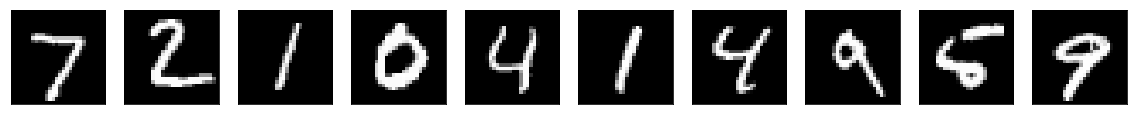

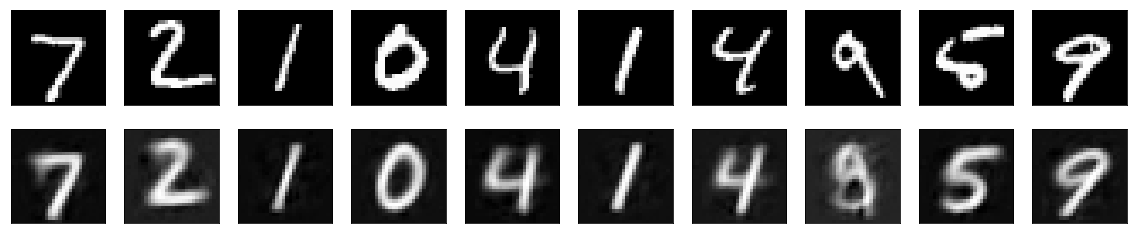

In [19]:
plotCompDecode(xTest, decodeTest, xNoise=xTestNoise)


## Plot the scatter of the encoding space

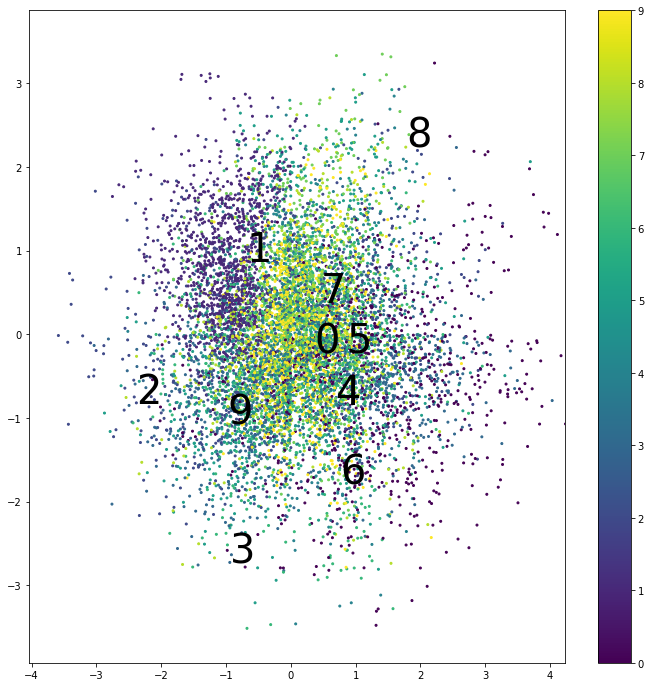

-0.10795592


In [20]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000, markersize=4)
scoreSilh = silhouette_score(encodeTest, yTest)
print(scoreSilh)

## Plot the decoding results from the encoding scatter 

In [21]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, (sizeDigit, sizeDigit), xlim, ylim)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[-4.04160897, -3.9281075 ]])]...

In [28]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

NameError: name 'history' is not defined

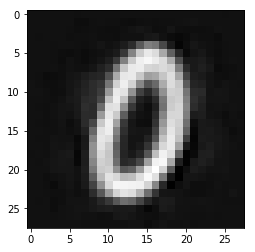

In [50]:
plt.imshow(decoder.predict([[[0,0]], dummy([0], dimOneHot)]).reshape(28,28))

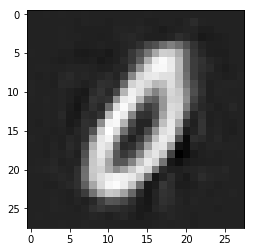

In [51]:
plt.imshow(decoder.predict([[[0,1]], dummy([0], dimOneHot)]).reshape(28,28))

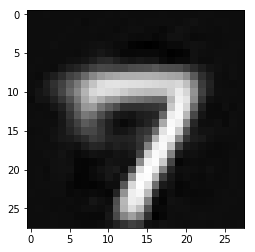

In [54]:
plt.imshow(decoder.predict([[[1,0]], dummy([7], dimOneHot)]).reshape(28,28))

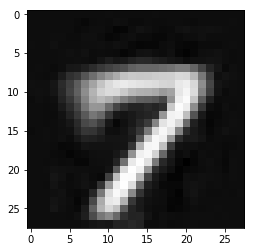

In [55]:
plt.imshow(decoder.predict([[[1,1]], dummy([7], dimOneHot)]).reshape(28,28))